#**DSCI 521 Final Project: Securities Data Analysis and Sentiment Analysis and BERT Modelling of FOMC Textual Data**

- Group member
    - Name: Kasonde Chewe
    - Email: kc3745@drexel.edu
- Group member
    - Name: Jonathan Watkins
    - Email: jfw68@drexel.edu
- Group member
    - Name: Jake Jarosik
    - Email: jj3268@drexel.edu
- Group member
    - Name: Jimmy Zhang
    - Email: jz876@drexel.edu


# **00. System and Environment Setup**

In [8]:
# Comment in and out as need
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# install packages here
%pip install transformers
%pip install spacy
%pip install yfinance --upgrade --no-cache-dir
%pip install FedTools
%pip install tokenization
%pip install bert

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 38.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for bert: filename=bert-2.2.0-py3-none-any.whl size=3744 sha256=72b364558d541d59c66215b44142a3502ff2074f2cf7baa00c1da2996e3d30f1
  Stored in directory: /root/.cache/pip/wheels/d0/97/c8/5775d57c323970511488d9b53ce66cf0ded394fe4b4f6e0afb
  Created wheel for erlastic: filename=erlastic-2.0.0-py3-none-any.whl size=6779 sha256=0fbdebd645b717da58a2bbddecdf44828533cddd3d1b9ab80d0ea9949a879fb1
  Stored in directory: /root/.cache/pip/wheels/f5/ca/b1/ce71c2e0e9e0df3786697d06d53574be03ef86cd4fb0e2cb99
Successfully built bert erlastic


In [9]:
# import standard modules here
import sys
import os
import datetime
import requests
import bs4
import nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')

import string
import pickle
import threading
import torch
import transformers
import tokenization
import bert

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


ModuleNotFoundError: ignored

In [2]:
# import standard modules with aliases here
import random as ra
import regex as re
import numpy as np
import pandas as pd
import seaborn as sb
import spacy as sc
import tensorflow as tf
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

In [3]:
# import individual objects from standard modules here
from dateutil import parser
from datetime import date

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from collections import Counter

from scipy.stats import jarque_bera

In [11]:
# import non-standard modules / python scripts / objects here
sys.path.append('/content/drive/MyDrive/DSCI 521 Assignments and Project/Project/fomc_get_data')
from FomcStatement import FomcStatement

ModuleNotFoundError: ignored

# **01. Data Acquistion and Pre-Processing**

In [6]:
# this function access stock price data via the yahoo finance api and save it as a csv to to the specified path.
def download_stock_price(myTicker = '^GSPC', start_time='2008-01-01', path = '/content/drive/MyDrive/DSCI 521 Assignments and Project/Project/StockData/All Current S&P 500 Constituents/'):
  myData = yf.Ticker(myTicker).history(start=start_time)
  myData.to_csv(path + myTicker + '.csv')
  return myData

In [7]:
# usage
mrk = download_stock_price('MRK')
mrk.head()

OSError: ignored

In [ ]:
# this function gets a list of the current S&P 500 constituents from web scrape
def download_s_and_p_500_data (path = '/content/drive/MyDrive/DSCI 521 Assignments and Project/Project/StockData/All Current S&P 500 Constituents/'):
  link = (
    "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies#S&P_500_component_stocks"
  )
  data = pd.read_html(link, header=0)[0]
  data.to_csv(path + "constituents.csv", index=False)
  return data

In [ ]:
#usage
sp_500_data = download_s_and_p_500_data()

#download price information for each stock
for i, stock in sp_500_data.iterrows():
  download_stock_price(stock['Symbol'])

ERROR:yfinance:BRK.B: No timezone found, symbol may be delisted
ERROR:yfinance:BF.B: No price data found, symbol may be delisted (1d 2008-01-01 -> 2023-09-03)


In [ ]:
#get basic info from yfinance api
def download_yf_basic_info(stock_df, path = '/content/drive/MyDrive/DSCI 521 Assignments and Project/Project/StockData/'): #stock_df must contain a column called 'Symbol'

  basic_info_df = pd.DataFrame() # initalize

  for i, r in stock_df.iterrows():
    try:
      each_ticker = str(r['Symbol'])
      ticker_basic_info = yf.Ticker(each_ticker).basic_info.items()
      ticker_info_series = pd.Series([x[1] for x in ticker_basic_info], index = [x[0] for x in ticker_basic_info])
      ticker_info_df_row = ticker_info_series.to_frame().T
      ticker_info_df_row['Symbol'] = each_ticker
      basic_info_df = pd.concat([basic_info_df, ticker_info_df_row])
    except:
      pass #some tickers do not have this information available


  #join basic info dataframe to original dataframe
  df_w_basics = pd.merge(stock_df, basic_info_df, on = 'Symbol')

  df_w_basics.to_csv(path + "constituents_w_basic_info.csv", index=False)
  return df_w_basics

In [ ]:
#usage
sp_500_data_w_basic_info = download_yf_basic_info(sp_500_data)

In [ ]:
# this function access fomc statements using web scrapping, provided through the imported custom python module. do not run if the data is already downloaded.
def download_Fomc_statements(start_year= datetime.datetime(2008, 1, 1), path = '/content/drive/MyDrive/DSCI 521 Assignments and Project/Project/FOMCData/'):
  statementHandler = FomcStatement()
  statementHandler.verbose = False
  all_statements = statementHandler.get_contents()
  statements_of_interest = all_statements[all_statements['date'] >= start_year]
  for i, row in statements_of_interest.iterrows():
    textfilepath = path + row['date'].strftime('%Y-%m-%d') + '.txt'
    with open(textfilepath, 'w') as fileHandler:
      fileHandler.write(row['contents'])
  return statements_of_interest

In [ ]:
# use this function to load FOMC statements that are already saved
def load_Fomc_textfile(filename, path = '/content/drive/MyDrive/DSCI 521 Assignments and Project/Project/FOMCData/'):
  filepath = path + filename
  with open(filepath, 'r') as fileHandler:
    myFileContents = fileHandler.read()
  return myFileContents

In [ ]:
# usage
mar2009_statement = load_Fomc_textfile('2009-03-18.txt')
mar2009_statement

"The Federal Reserve, the central bank of the United States, provides\n          the nation with a safe, flexible, and stable monetary and financial\n          system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[SECTION]\n\nMonetary Policy Principles and Practice\n\n[SECTION]\n\nPolicy Implementation\n\n[SECTION]\n\nReports\n\n[SECTION]\n\nReview of Monetary Policy Strategy, Tools, and Communications\n\n[SECTION]\n\nInstitution Supervision\n\n[SECTION]\n\nReports\n\n[SECTION]\n\nReporting Forms\n\n[SECTION]\n\nSupervision & Regulation Letters\n\n[SECTION]\n\nBanking Applications & Legal Developments\n\n[SECTION]\n\nRegulatory Resources\n\n[SECTION]\n\nBanking & Data Structure\n\n[SECTION]\n\nFinancial Stability Assessments\n\n[SECTION]\n\nFinancial Stability Coordination & Actions\n\n[SECTION]\n\nReports\n\n[SECTION]\n\nRegulations & Statutes\n\n[SECTION]\n\nPayment Policies\n\n[SECTION]\n\nReserve Bank Payment Services & Data\n\n[SECTION]\n\nFinancial Market Utilities & Infrastr

# **02. EDA**

In [ ]:
#basic graphing function
def plot_stock_price(ticker = "^GSPC", data_directory = '/content/drive/MyDrive/DSCI 521 Assignments and Project/Project/StockData/', plot_title = '', start_time = '2008-01-01', end_time = ''):
  stock_data = pd.read_csv(data_directory + ticker + '.csv')
  stock_data['Date'] = stock_data['Date'].apply(parser.parse)
  stock_data['Date'] = stock_data['Date'].apply(datetime.datetime.date)
  plot_data = stock_data[stock_data['Date'] >= parser.parse(start_time).date()] if end_time == '' else stock_data.loc[(stock_data.Date >= parser.parse(start_time).date()) & (stock_data.Date <= parser.parse(end_time).date())] #by default the function will show all data
  fig = plt.figure(figsize=[14,6])
  ax = plt.subplot(111)
  ax.plot(plot_data['Date'], plot_data['Close'])
  ax.set_xlabel('Date')
  ax.set_ylabel('Stock Price at Market Close (USD)')
  if plot_title == '':
    ax.set_title(ticker + ' Stock Price')
  else:
    ax.set_title(plot_title)

  return

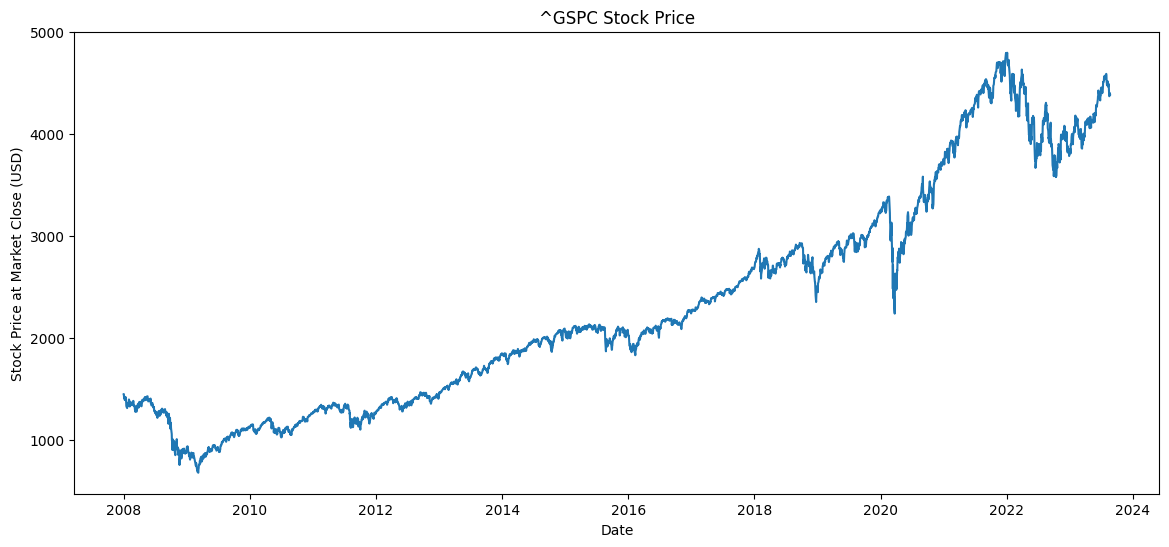

In [ ]:
#usage
plot_stock_price() # price of the index fund

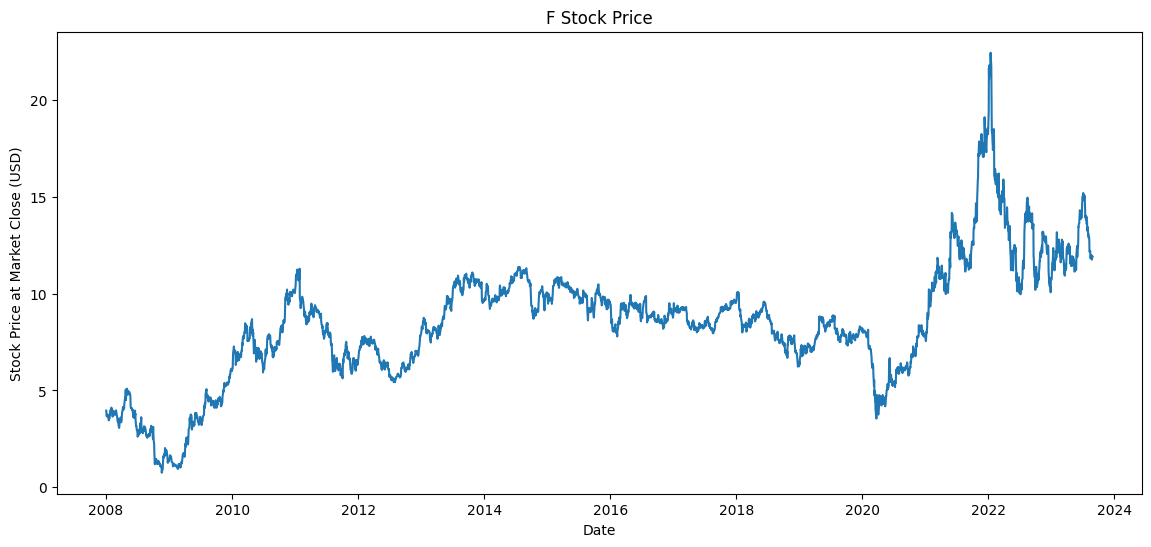

In [ ]:
plot_stock_price('F')

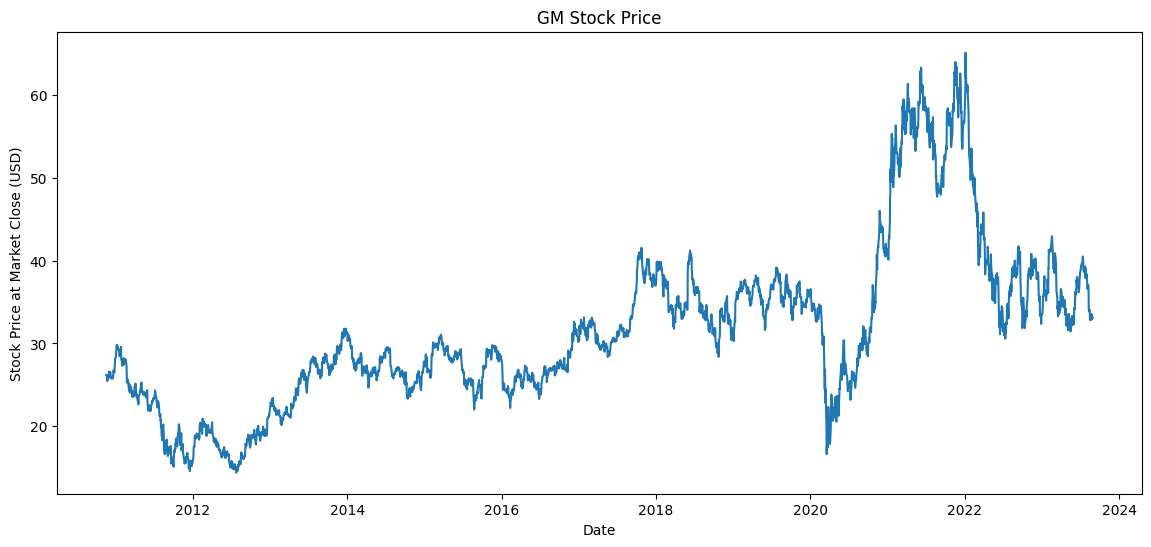

In [ ]:
plot_stock_price('GM')

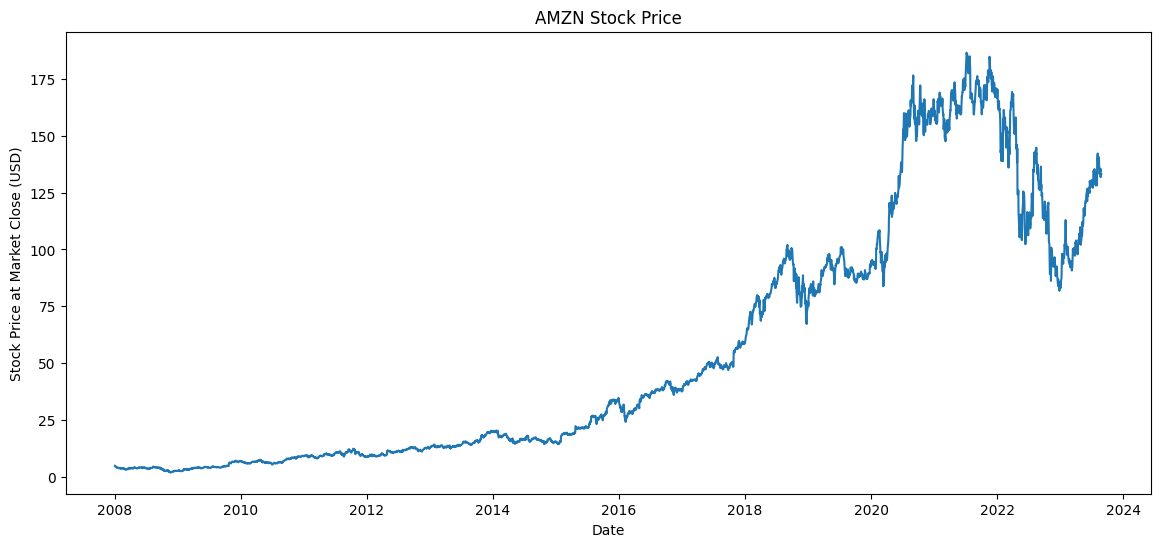

In [ ]:
plot_stock_price('AMZN')

In [ ]:
# candle graph function
def plot_stock_candle(ticker = "^GSPC", data_directory = '/content/drive/MyDrive/DSCI 521 Assignments and Project/Project/StockData/', start_time = '2008-01-01', end_time = ''):
  stock_data = pd.read_csv(data_directory + ticker + '.csv')
  stock_data['Date'] = stock_data['Date'].apply(parser.parse)
  stock_data['Date'] = stock_data['Date'].apply(datetime.datetime.date)
  plot_data = stock_data[stock_data['Date'] >= parser.parse(start_time).date()].head(52 * 5) if end_time == '' else stock_data.loc[(stock_data.Date >= parser.parse(start_time).date()) & (stock_data.Date <= parser.parse(end_time).date())] #by default the function will show data from the first year
  fig = go.Figure(data=[go.Candlestick(x = plot_data['Date'],
                open = plot_data['Open'],
                high = plot_data['High'],
                low = plot_data['Low'],
                close = plot_data['Close'])],
                layout = {'margin' : go.layout.Margin(l=50, r=50, b=50, t=50, pad=50), 'title' : ticker + ' Stock Price'})

  fig.show()

  return

In [ ]:
#usage
plot_stock_candle() # price of the index fund

In [ ]:
plot_stock_candle(end_time = '2023-08-15')

In [ ]:
plot_stock_candle('MRK')

In [ ]:
plot_stock_candle('F', start_time = '2013-01-01', end_time = '2013-07-07')

In [ ]:
#EDA with yahoo finance basic info for the constituents (data is retrieved / downloaded in section 01)
eda_data = pd.read_csv('/content/drive/MyDrive/DSCI 521 Assignments and Project/Project/StockData/constituents_w_basic_info.csv')
eda_data.columns

Index(['Symbol', 'Security', 'GICS Sector', 'GICS Sub-Industry',
       'Headquarters Location', 'Date added', 'CIK', 'Founded', 'currency',
       'dayHigh', 'dayLow', 'exchange', 'fiftyDayAverage', 'lastPrice',
       'lastVolume', 'marketCap', 'open', 'previousClose', 'quoteType',
       'regularMarketPreviousClose', 'shares', 'tenDayAverageVolume',
       'threeMonthAverageVolume', 'timezone', 'twoHundredDayAverage',
       'yearChange', 'yearHigh', 'yearLow'],
      dtype='object')

In [ ]:
#function describes numerical features in basic info returned by yahoo finance api
def descriptive_stats(data):
    if 'CIK' in data.columns:
      data = data.drop('CIK', axis = 1)
    descriptive_stats = data.describe(exclude='object').drop('count').round(3)
    skew = data.skew(numeric_only=True).round(3)
    kurt = data.kurtosis(numeric_only=True).round(3)
    jb_pvalues=[]
    for col in data.select_dtypes(exclude='object').columns:
      jb_pvalue = jarque_bera(data[col].dropna(),)[1].round(3)
      jb_pvalues.append(jb_pvalue)
    adv_stats_df = pd.DataFrame({'skewness':skew, 'kurtosis':kurt, 'JB p-value':jb_pvalues}).T
    return pd.concat([descriptive_stats,adv_stats_df])

In [ ]:
#usage
descriptive_stats(eda_data)

dayHigh    dayLow  fiftyDayAverage  lastPrice    lastVolume  \
mean         186.916   183.772          183.743    185.313  3.900877e+06   
std          376.068   369.344          361.752    374.533  8.955629e+06   
min            9.820     9.730            9.816      9.780  2.000000e+04   
25%           59.830    59.120           59.410     59.310  7.594000e+05   
50%          108.500   106.610          108.404    108.450  1.583400e+06   
75%          209.290   205.940          209.738    206.830  3.357800e+06   
max         6525.000  6393.920         6252.434   6509.350  1.322725e+08   
skewness      11.435    11.395           11.304     11.485  8.057000e+00   
kurtosis     172.375   171.108          169.150    173.567  9.310500e+01   
JB p-value     0.000     0.000            0.000      0.000  0.000000e+00   

               marketCap      open  previousClose  regularMarketPreviousClose  \
mean        8.194371e+10   185.722        184.522                     184.549   
std         2.296718e+11   372.201        369.640                     369.703   
min         4.436082e+09     9.780          9.740                       9.740   
25%         1.660910e+10    59.400         58.950                      58.960   
50%         3.116713e+10   107.960        107.180                     107.390   
75%         6.276090e+10   207.850        206.760                     206.760   
max         2.962056e+12  6422.200       6377.330                    6377.330   
skewness    8.408000e+00    11.321         11.316                      11.309   
kurtosis    8.396800e+01   169.108        168.993                     168.850   
JB p-value  0.000000e+00     0.000          0.000                       0.000   

                  shares  tenDayAverageVolume  threeMonthAverageVolume  \
mean        6.965018e+08         4.094846e+06             4.612531e+06   
std         1.423734e+09         9.755489e+06             9.505945e+06   
min         3.264330e+06         2.080000e+04             1.999300e+04   
25%         1.506420e+08         8.254100e+05             1.034467e+06   
50%         3.091920e+08         1.673030e+06             2.036807e+06   
75%         6.394390e+08         3.618350e+06             4.208518e+06   
max         1.563420e+10         1.178612e+08             1.299748e+08   
skewness    6.305000e+00         7.385000e+00             6.998000e+00   
kurtosis    4.970300e+01         6.828200e+01             7.017800e+01   
JB p-value  0.000000e+00         0.000000e+00             0.000000e+00   

            twoHundredDayAverage  yearChange  yearHigh   yearLow  
mean                     174.816       0.099   208.926   133.248  
std                      325.809       0.291   387.306   232.649  
min                       10.507      -0.560    12.400     6.110  
25%                       58.996      -0.089    70.650    46.180  
50%                      106.460       0.076   124.950    82.500  
75%                      202.856       0.247   241.860   156.470  
max                     5517.222       2.603  6525.000  3816.560  
skewness                  10.800       1.819    10.713    10.134  
kurtosis                 155.976      11.231   153.500   139.063  
JB p-value                 0.000       0.000     0.000     0.000

In [ ]:
# Speaker window
import pickle
file = open("/content/drive/MyDrive/DSCI 521 Assignments and Project/Project/preprocessed/statement.pickle", "rb")
Data = pickle.load(file)
Data['text'] = Data['contents'].apply(lambda x: x.replace('\n\n[SECTION]\n\n', '').replace('\n', ' ').replace('\r', ' ').strip())
Data.drop(columns=['title'], axis=1, inplace=True)
#Dictionary tone assessment will compare them by Index (need the numbers back)
Data['Index'] = range(0, len(Data))

# Make 'date' column as the index of Data
Data.set_index(['date'], inplace=True)
Data.head()

contents         speaker  \
date                                                                            
1994-02-04  \n\n[SECTION]\n\nChairman Alan Greenspan annou...  Alan Greenspan   
1994-03-22  \n\n[SECTION]\n\nChairman Alan Greenspan annou...  Alan Greenspan   
1994-04-18  \n\n[SECTION]\n\nChairman Alan Greenspan annou...  Alan Greenspan   
1994-05-17  \n\n[SECTION]\n\nThe Federal Reserve today ann...  Alan Greenspan   
1994-08-16  \n\n[SECTION]\n\nThe Federal Reserve announced...  Alan Greenspan   

                                                         text  Index  
date                                                                  
1994-02-04  Chairman Alan Greenspan announced today that t...      0  
1994-03-22  Chairman Alan Greenspan announced today that t...      1  
1994-04-18  Chairman Alan Greenspan announced today that t...      2  
1994-05-17  The Federal Reserve today announced two action...      3  
1994-08-16  The Federal Reserve announced today the follow...      4

In [ ]:
# FRB changed to range from 2008. So use Upper side from 2008.
filename_till08 = '/content/drive/MyDrive/DSCI 521 Assignments and Project/Project/MarketData/Quandl/FRED_DFEDTAR.csv'
filename_from08u = '/content/drive/MyDrive/DSCI 521 Assignments and Project/Project/MarketData/Quandl/FRED_DFEDTARU.csv'
filename_from08l = '/content/drive/MyDrive/DSCI 521 Assignments and Project/Project/MarketData/Quandl/FRED_DFEDTARL.csv'

fedtar = pd.read_csv(filename_till08, names=['Date', 'Rate'], header=0)
fedtaru = pd.read_csv(filename_from08u, names=['Date', 'Rate'], header=0)
fedtarl = pd.read_csv(filename_from08l, names=['Date', 'Rate'], header=0)
fedrate_df = pd.concat([fedtar, fedtaru], axis=0)
fedrate_df.index = pd.to_datetime(fedrate_df.Date, format="%Y-%m-%d")
fedrate_df.drop(columns=['Date'], inplace=True)
fedrate_df['Rate'] = fedrate_df['Rate'].map(lambda x: np.float64(x))
fedrate_df


Rate
Date             
1982-09-27  10.25
1982-09-28  10.25
1982-09-29  10.25
1982-09-30  10.25
1982-10-01  10.00
...           ...
2022-07-14   1.75
2022-07-15   1.75
2022-07-16   1.75
2022-07-17   1.75
2022-07-18   1.75

[14540 rows x 1 columns]

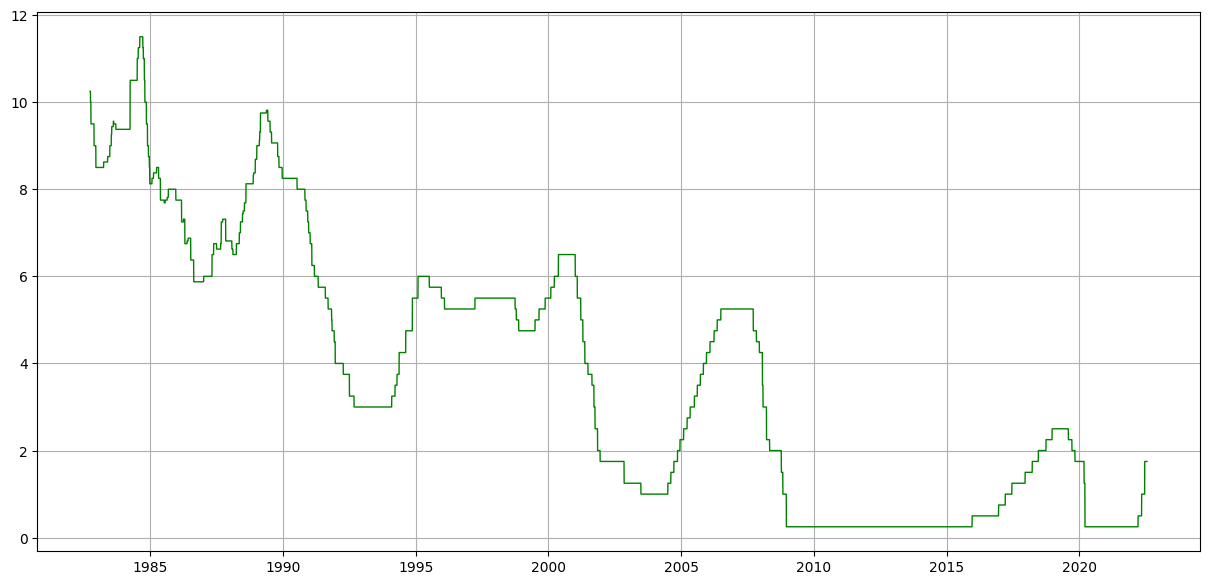

In [ ]:
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(fedrate_df.index, fedrate_df['Rate'].values, c = 'green', linewidth= 1.0)
ax.grid(True)
plt.show()

In [ ]:
Data['RateDecision'] = None
Data['Rate'] = None

for i in range(len(Data)):
    for j in range(len(fedrate_df)):
        if Data.index[i] == fedrate_df.index[j]:
            Data['Rate'][i] = float(fedrate_df['Rate'][j+1])
            if fedrate_df['Rate'][j-1] == fedrate_df['Rate'][j+1]:
                Data['RateDecision'][i] = 0
            elif fedrate_df['Rate'][j-1] < fedrate_df['Rate'][j+1]:
                Data['RateDecision'][i] = 1
            elif fedrate_df['Rate'][j-1] > fedrate_df['Rate'][j+1]:
                Data['RateDecision'][i] = -1

Data.head(10)

<ipython-input-32-08e74b406909>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-32-08e74b406909>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-32-08e74b406909>:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-32-08e74b406909>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pa

contents         speaker  \
date                                                                            
1994-02-04  \n\n[SECTION]\n\nChairman Alan Greenspan annou...  Alan Greenspan   
1994-03-22  \n\n[SECTION]\n\nChairman Alan Greenspan annou...  Alan Greenspan   
1994-04-18  \n\n[SECTION]\n\nChairman Alan Greenspan annou...  Alan Greenspan   
1994-05-17  \n\n[SECTION]\n\nThe Federal Reserve today ann...  Alan Greenspan   
1994-08-16  \n\n[SECTION]\n\nThe Federal Reserve announced...  Alan Greenspan   
1994-11-15  \n\n[SECTION]\n\nThe Federal Reserve Board tod...  Alan Greenspan   
1995-02-01  \n\n[SECTION]\n\nFor immediate release\n\n[SEC...  Alan Greenspan   
1995-07-06  \n\n[SECTION]\n\nFor immediate release\n\n[SEC...  Alan Greenspan   
1995-12-19  \n\n[SECTION]\n\nFor immediate release\n\n[SEC...  Alan Greenspan   
1996-01-31  For immediate release\n\n\n\n\n\n\r\n\r\nThe F...  Alan Greenspan   

                                                         text  Index  \
date                                                                   
1994-02-04  Chairman Alan Greenspan announced today that t...      0   
1994-03-22  Chairman Alan Greenspan announced today that t...      1   
1994-04-18  Chairman Alan Greenspan announced today that t...      2   
1994-05-17  The Federal Reserve today announced two action...      3   
1994-08-16  The Federal Reserve announced today the follow...      4   
1994-11-15  The Federal Reserve Board today approved an in...      5   
1995-02-01  For immediate releaseThe Federal Reserve Board...      6   
1995-07-06  For immediate releaseChairman Alan Greenspan a...      7   
1995-12-19  For immediate releaseChairman Alan Greenspan a...      8   
1996-01-31  For immediate release          The Federal Res...      9   

           RateDecision  Rate  
date                           
1994-02-04            1  3.25  
1994-03-22            1   3.5  
1994-04-18            1  3.75  
1994-05-17            1  4.25  
1994-08-16            1  4.75  
1994-11-15            1   5.5  
1995-02-01            1   6.0  
1995-07-06           -1  5.75  
1995-12-19           -1   5.5  
1996-01-31           -1  5.25

In [ ]:
#inline sector information
sectors = set(list(eda_data['GICS Sector']))
print(f'Total number of sectors = {len(sectors)}:\n')
sectors

Total number of sectors = 11:



{'Communication Services',
 'Consumer Discretionary',
 'Consumer Staples',
 'Energy',
 'Financials',
 'Health Care',
 'Industrials',
 'Information Technology',
 'Materials',
 'Real Estate',
 'Utilities'}

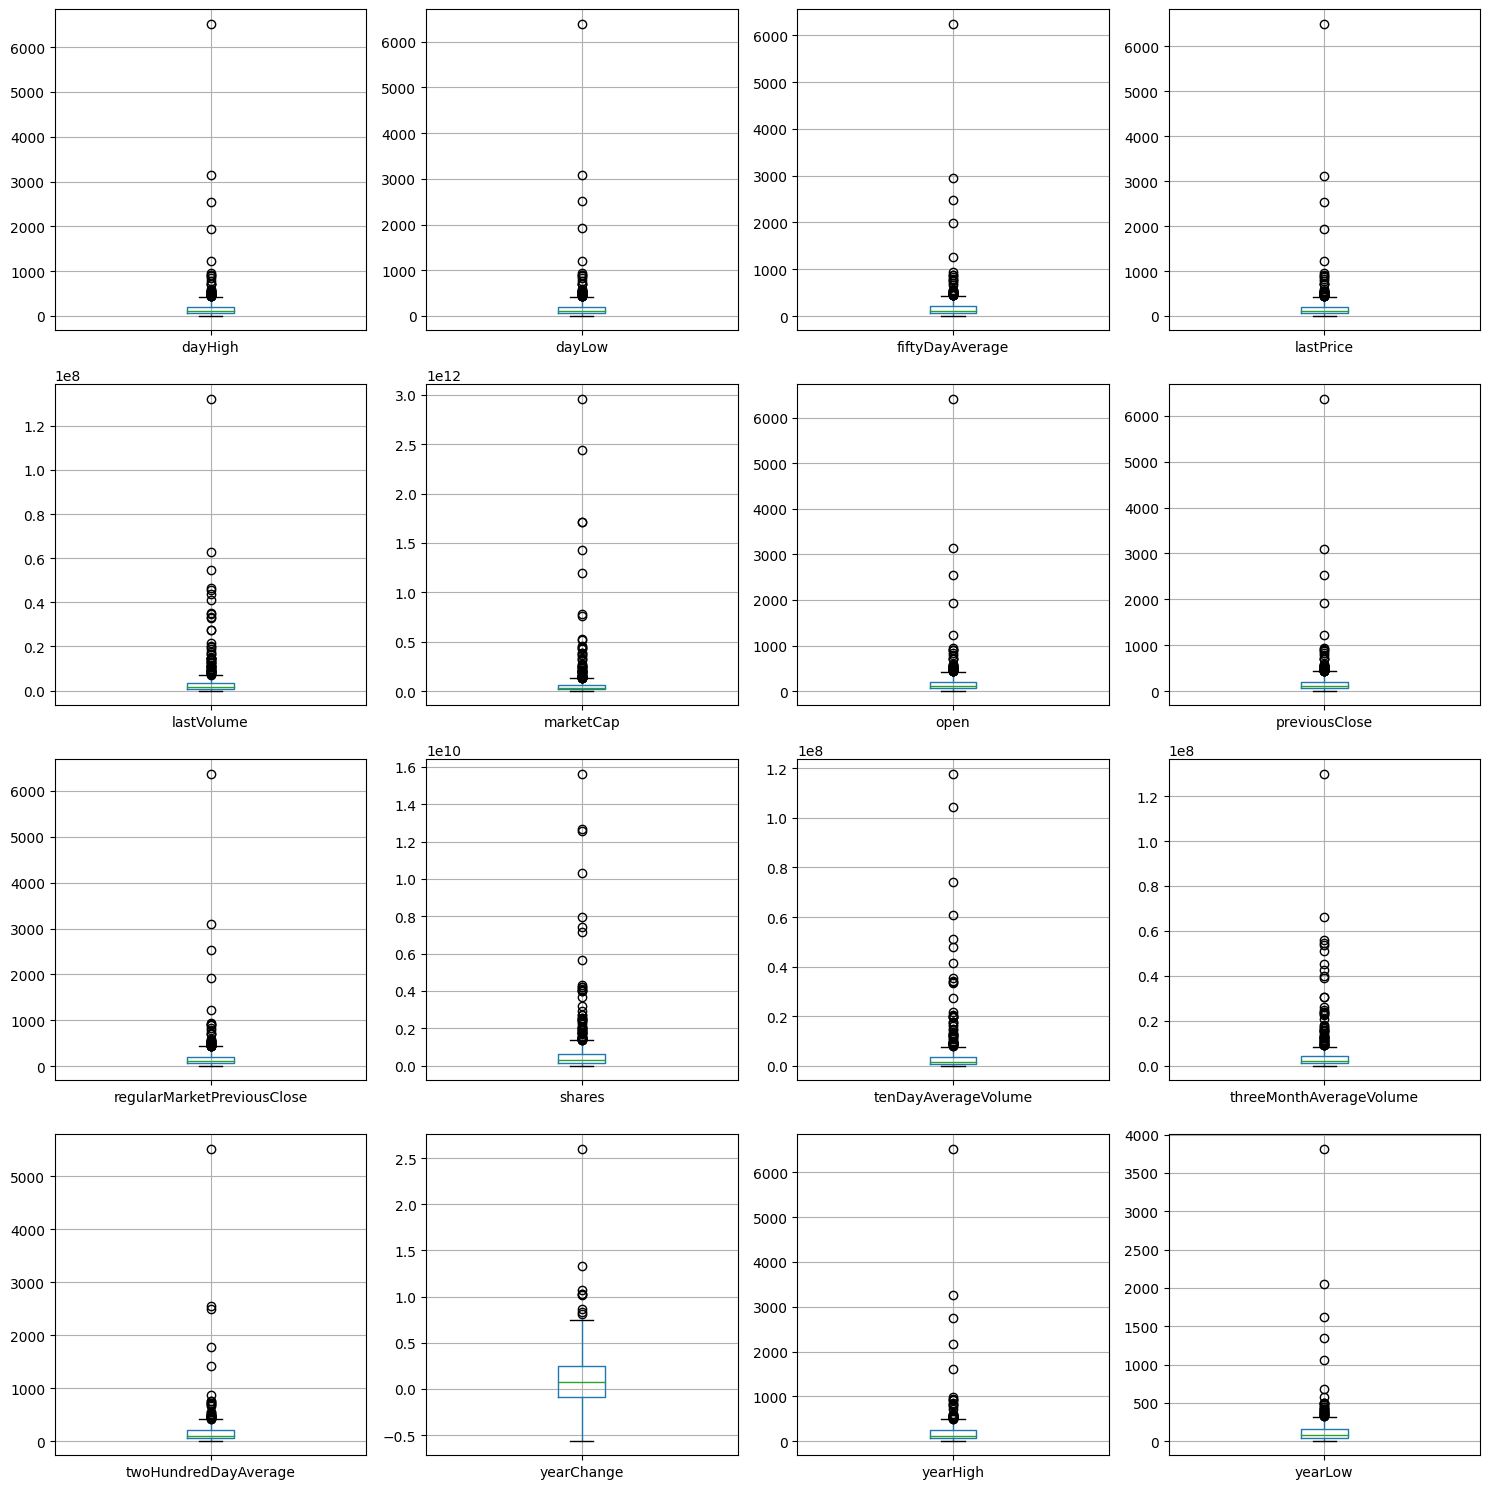

In [ ]:
# Checking for the presence of outliers with box plots
data1 = eda_data.drop('CIK', axis = 1).select_dtypes(exclude=['object'])
plt.figure(figsize=(15,15))
for column,num in zip(data1.columns, range(len(data1.columns))):
    plt.subplot(4,4,num+1)
    data1.boxplot([column])
plt.tight_layout()

Text(0.5, 1.0, 'Correlation Heatmap\n')

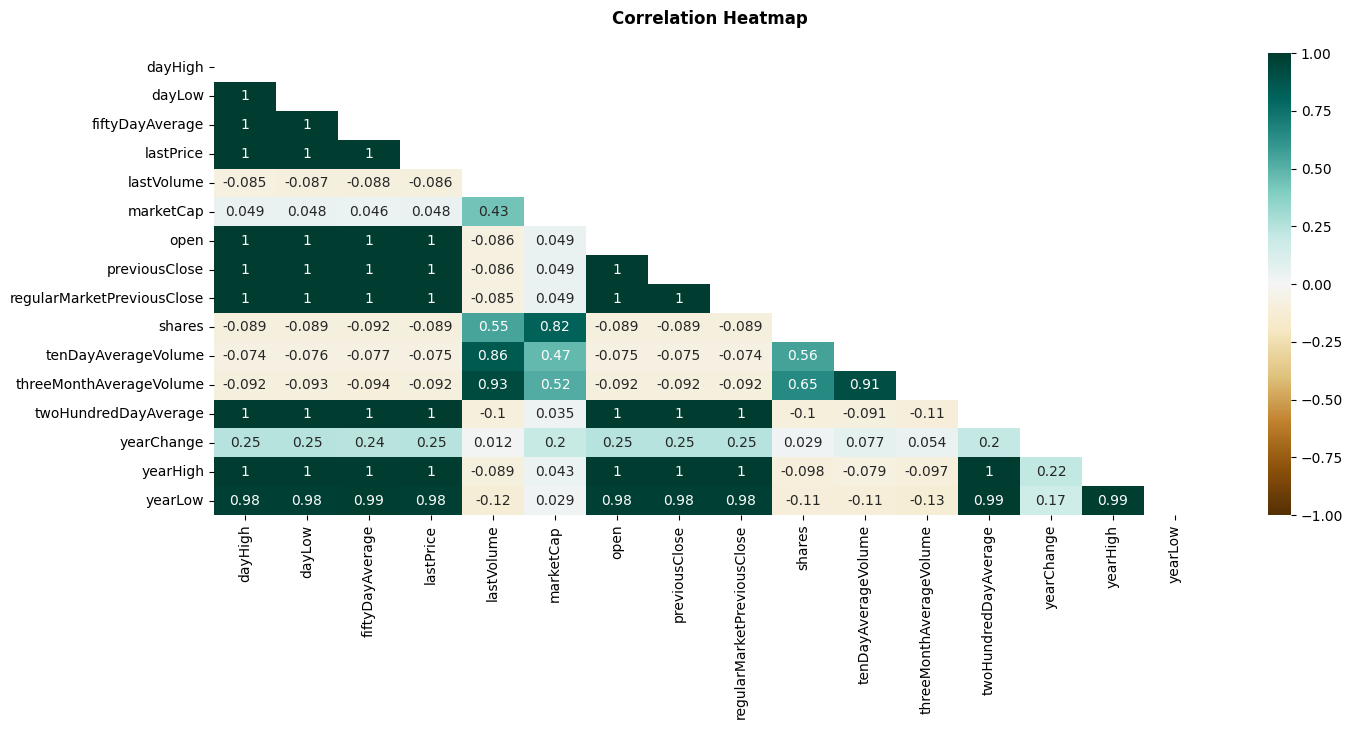

In [ ]:
# Correlation between numeric variables
plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(eda_data.drop('CIK', axis = 1).iloc[:,4:].corr(numeric_only = True), dtype=bool))
heatmap = sb.heatmap(eda_data.drop('CIK', axis = 1).iloc[:,4:].corr(numeric_only = True), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
plt.title('Correlation Heatmap\n', weight='bold')

In [ ]:
# Now let's process the textual data:
# first, tokenize words
def preprocess_fomc_statement(file):
    # loading/ pre-processing data
    fomc_statement = load_Fomc_textfile(file, path = '/content/drive/MyDrive/DSCI 521 Assignments and Project/Project/FOMCData/')
    fomc_statement = fomc_statement.lower()
    fomc_statement = fomc_statement.translate(str.maketrans('', '', string.punctuation))

    # Tokenize words
    words = word_tokenize(fomc_statement)
    stop_words = set(stopwords.words('english'))
    stop_words.update(["federal", "reserve", "financial", "committee", "market", "would", "also"])
    filtered_words = [word for word in words if word not in stop_words]

    return filtered_words

file_path = '2009-03-18.txt'
preprocessed_words = preprocess_fomc_statement( file_path)
preprocessed_words

['central',
 'bank',
 'united',
 'states',
 'provides',
 'nation',
 'safe',
 'flexible',
 'stable',
 'monetary',
 'system',
 'section',
 'open',
 'section',
 'monetary',
 'policy',
 'principles',
 'practice',
 'section',
 'policy',
 'implementation',
 'section',
 'reports',
 'section',
 'review',
 'monetary',
 'policy',
 'strategy',
 'tools',
 'communications',
 'section',
 'institution',
 'supervision',
 'section',
 'reports',
 'section',
 'reporting',
 'forms',
 'section',
 'supervision',
 'regulation',
 'letters',
 'section',
 'banking',
 'applications',
 'legal',
 'developments',
 'section',
 'regulatory',
 'resources',
 'section',
 'banking',
 'data',
 'structure',
 'section',
 'stability',
 'assessments',
 'section',
 'stability',
 'coordination',
 'actions',
 'section',
 'reports',
 'section',
 'regulations',
 'statutes',
 'section',
 'payment',
 'policies',
 'section',
 'bank',
 'payment',
 'services',
 'data',
 'section',
 'utilities',
 'infrastructures',
 'section',
 'researc

['central', 'bank', 'united', 'states', 'provides', 'nation', 'safe', 'flexible', 'stable', 'monetary', 'system', 'section', 'open', 'section', 'monetary', 'policy', 'principles', 'practice', 'section', 'policy', 'implementation', 'section', 'reports', 'section', 'review', 'monetary', 'policy', 'strategy', 'tools', 'communications', 'section', 'institution', 'supervision', 'section', 'reports', 'section', 'reporting', 'forms', 'section', 'supervision', 'regulation', 'letters', 'section', 'banking', 'applications', 'legal', 'developments', 'section', 'regulatory', 'resources', 'section', 'banking', 'data', 'structure', 'section', 'stability', 'assessments', 'section', 'stability', 'coordination', 'actions', 'section', 'reports', 'section', 'regulations', 'statutes', 'section', 'payment', 'policies', 'section', 'bank', 'payment', 'services', 'data', 'section', 'utilities', 'infrastructures', 'section', 'research', 'committees', 'forums', 'section', 'working', 'papers', 'notes', 'section'

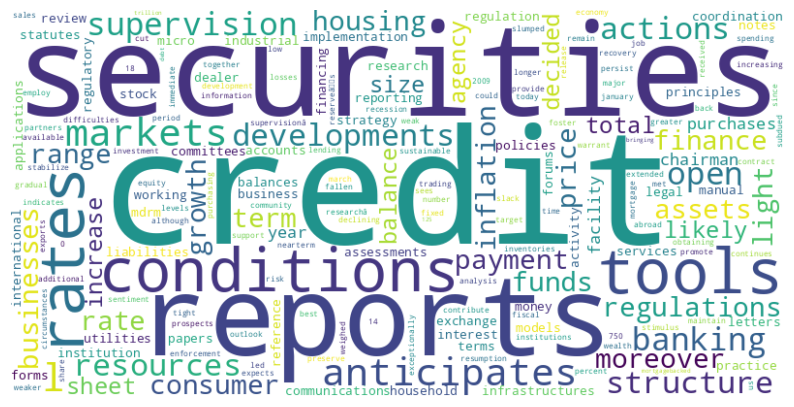

In [ ]:
# let's make word clouds

def analyze_word_frequencies(preprocessed_words, verbose = True):
    # Get a set of English stopwords and punctuation characters
    stop_words = set(stopwords.words('english'))
    punctuations = set(string.punctuation)

    # Filter out stop words and punctuations from the preprocessed words
    filtered_words = [word for word in preprocessed_words if word not in stop_words and word not in punctuations]
    if verbose == True:
      print(filtered_words)

    # List of common words to filter out
    common_words_to_filter = ["federal", "reserve", "central", "bank", "united", "states", "provides",
                              "nation", "safe", "flexible", "stable", "monetary", "financial", "system",
                              "section", "economic", "policy", "data", "billion", "stability"]

    # Filter out common words from the filtered words
    filtered_words = [word for word in filtered_words if word.lower() not in common_words_to_filter]

    # Calculate word frequencies
    word_freq = Counter(filtered_words)

    # Display the 20 most common words
    if verbose == True:
      print("Most common words:")
      print(word_freq.most_common(20))

    # Create a word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

    # Plot the word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    return

# Call the function with preprocessed words
analyze_word_frequencies(preprocessed_words)


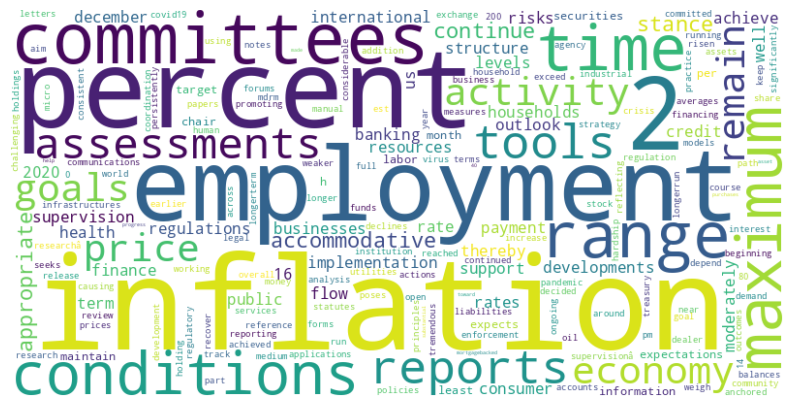

In [ ]:
analyze_word_frequencies(preprocess_fomc_statement('2020-12-16.txt'), False)

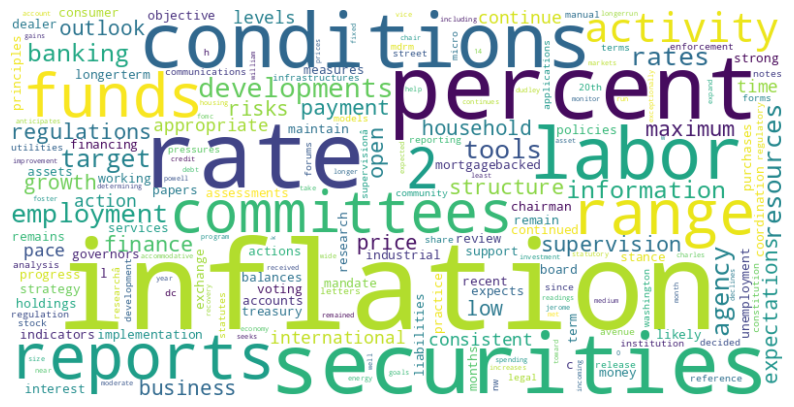

In [ ]:
# let's make a word cloud of all downloaded / retrieved FOMC statements
dir_path_to_fomc_statements = '/content/drive/MyDrive/DSCI 521 Assignments and Project/Project/FOMCData'
preprocessed_words_all = []
for statement in os.listdir(dir_path_to_fomc_statements):
  preprocessed_words_all += preprocess_fomc_statement(statement)
analyze_word_frequencies(preprocessed_words_all, False)

# **03. Sentiment Analysis of FOMC Textual Data**

In [ ]:
#Load FOMC text file and return its content as df
def load_Fomc_textfile(filename):
    with open(filename, 'r') as file:
        date_str = filename.split('/')[-1].replace('.txt', '')
        contents = file.read()
        return pd.DataFrame({'date': [pd.Timestamp(date_str)], 'contents': [contents]})

In [ ]:
#Consolidate all text files in directory into a single DataFrame
def consolidate_textfiles_in_directory(directory_path):
    all_statements = pd.DataFrame()

    for filename in os.listdir(directory_path):
        if filename.endswith(".txt"):
            file_path = os.path.join(directory_path, filename)
            df = load_Fomc_textfile(file_path)
            all_statements = pd.concat([all_statements, df], ignore_index=True)

    return all_statements

In [ ]:
directory_path = '/content/drive/MyDrive/DSCI 521 Assignments and Project/Project/FOMCData/'
fomc_data = consolidate_textfiles_in_directory(directory_path)

In [ ]:
#Dictionary tone assessment will compare them by Index (need the numbers back)
fomc_data['Index'] = range(0, len(fomc_data))

# Make 'date' column as the index of fomc_data
fomc_data.set_index(['date'], inplace=True)
fomc_data.head()
#print(len(fomc_data))

contents  Index
date                                                                
2008-01-21  The Federal Reserve, the central bank of the U...      0
2008-01-30  The Federal Reserve, the central bank of the U...      1
2008-08-05  The Federal Reserve, the central bank of the U...      2
2008-04-30  The Federal Reserve, the central bank of the U...      3
2008-06-25  The Federal Reserve, the central bank of the U...      4

In [ ]:
import re

# Loughran and McDonald Sentiment Word Lists (https://sraf.nd.edu/textual-analysis/resources/)
lmdict = {'Negative': ['abandon', 'abandoned', 'abandoning', 'abandonment', 'abandonments', 'abandons', 'abdicated',
                       'abdicates', 'abdicating', 'abdication', 'abdications', 'aberrant', 'aberration', 'aberrational',
                       'aberrations', 'abetting', 'abnormal', 'abnormalities', 'abnormality', 'abnormally', 'abolish',
                       'abolished', 'abolishes', 'abolishing', 'abrogate', 'abrogated', 'abrogates', 'abrogating',
                       'abrogation', 'abrogations', 'abrupt', 'abruptly', 'abruptness', 'absence', 'absences',
                       'absenteeism', 'abuse', 'abused', 'abuses', 'abusing', 'abusive', 'abusively', 'abusiveness',
                       'accident', 'accidental', 'accidentally', 'accidents', 'accusation', 'accusations', 'accuse',
                       'accused', 'accuses', 'accusing', 'acquiesce', 'acquiesced', 'acquiesces', 'acquiescing',
                       'acquit', 'acquits', 'acquittal', 'acquittals', 'acquitted', 'acquitting', 'adulterate',
                       'adulterated', 'adulterating', 'adulteration', 'adulterations', 'adversarial', 'adversaries',
                       'adversary', 'adverse', 'adversely', 'adversities', 'adversity', 'aftermath', 'aftermaths',
                       'against', 'aggravate', 'aggravated', 'aggravates', 'aggravating', 'aggravation', 'aggravations',
                       'alerted', 'alerting', 'alienate', 'alienated', 'alienates', 'alienating', 'alienation',
                       'alienations', 'allegation', 'allegations', 'allege', 'alleged', 'allegedly', 'alleges',
                       'alleging', 'annoy', 'annoyance', 'annoyances', 'annoyed', 'annoying', 'annoys', 'annul',
                       'annulled', 'annulling', 'annulment', 'annulments', 'annuls', 'anomalies', 'anomalous',
                       'anomalously', 'anomaly', 'anticompetitive', 'antitrust', 'argue', 'argued', 'arguing',
                       'argument', 'argumentative', 'arguments', 'arrearage', 'arrearages', 'arrears', 'arrest',
                       'arrested', 'arrests', 'artificially', 'assault', 'assaulted', 'assaulting', 'assaults',
                       'assertions', 'attrition', 'aversely', 'backdating', 'bad', 'bail', 'bailout', 'balk', 'balked',
                       'bankrupt', 'bankruptcies', 'bankruptcy', 'bankrupted', 'bankrupting', 'bankrupts', 'bans',
                       'barred', 'barrier', 'barriers', 'bottleneck', 'bottlenecks', 'boycott', 'boycotted',
                       'boycotting', 'boycotts', 'breach', 'breached', 'breaches', 'breaching', 'break', 'breakage',
                       'breakages', 'breakdown', 'breakdowns', 'breaking', 'breaks', 'bribe', 'bribed', 'briberies',
                       'bribery', 'bribes', 'bribing', 'bridge', 'broken', 'burden', 'burdened', 'burdening', 'burdens',
                       'burdensome', 'burned', 'calamities', 'calamitous', 'calamity', 'cancel', 'canceled',
                       'canceling', 'cancellation', 'cancellations', 'cancelled', 'cancelling', 'cancels', 'careless',
                       'carelessly', 'carelessness', 'catastrophe', 'catastrophes', 'catastrophic', 'catastrophically',
                       'caution', 'cautionary', 'cautioned', 'cautioning', 'cautions', 'cease', 'ceased', 'ceases',
                       'ceasing', 'censure', 'censured', 'censures', 'censuring', 'challenge', 'challenged',
                       'challenges', 'challenging', 'chargeoffs', 'circumvent', 'circumvented', 'circumventing',
                       'circumvention', 'circumventions', 'circumvents', 'claiming', 'claims', 'clawback', 'closed',
                       'closeout', 'closeouts', 'closing', 'closings', 'closure', 'closures', 'coerce', 'coerced',
                       'coerces', 'coercing', 'coercion', 'coercive', 'collapse', 'collapsed', 'collapses',
                       'collapsing', 'collision', 'collisions', 'collude', 'colluded', 'colludes', 'colluding',
                       'collusion', 'collusions', 'collusive', 'complain', 'complained', 'complaining', 'complains',
                       'complaint', 'complaints', 'complicate', 'complicated', 'complicates', 'complicating',
                       'complication', 'complications', 'compulsion', 'concealed', 'concealing', 'concede', 'conceded',
                       'concedes', 'conceding', 'concern', 'concerned', 'concerns', 'conciliating', 'conciliation',
                       'conciliations', 'condemn', 'condemnation', 'condemnations', 'condemned', 'condemning',
                       'condemns', 'condone', 'condoned', 'confess', 'confessed', 'confesses', 'confessing',
                       'confession', 'confine', 'confined', 'confinement', 'confinements', 'confines', 'confining',
                       'confiscate', 'confiscated', 'confiscates', 'confiscating', 'confiscation', 'confiscations',
                       'conflict', 'conflicted', 'conflicting', 'conflicts', 'confront', 'confrontation',
                       'confrontational', 'confrontations', 'confronted', 'confronting', 'confronts', 'confuse',
                       'confused', 'confuses', 'confusing', 'confusingly', 'confusion', 'conspiracies', 'conspiracy',
                       'conspirator', 'conspiratorial', 'conspirators', 'conspire', 'conspired', 'conspires',
                       'conspiring', 'contempt', 'contend', 'contended', 'contending', 'contends', 'contention',
                       'contentions', 'contentious', 'contentiously', 'contested', 'contesting', 'contraction',
                       'contractions', 'contradict', 'contradicted', 'contradicting', 'contradiction', 'contradictions',
                       'contradictory', 'contradicts', 'contrary', 'controversial', 'controversies', 'controversy',
                       'convict', 'convicted', 'convicting', 'conviction', 'convictions', 'corrected', 'correcting',
                       'correction', 'corrections', 'corrects', 'corrupt', 'corrupted', 'corrupting', 'corruption',
                       'corruptions', 'corruptly', 'corruptness', 'costly', 'counterclaim', 'counterclaimed',
                       'counterclaiming', 'counterclaims', 'counterfeit', 'counterfeited', 'counterfeiter',
                       'counterfeiters', 'counterfeiting', 'counterfeits', 'countermeasure', 'countermeasures', 'crime',
                       'crimes', 'criminal', 'criminally', 'criminals', 'crises', 'crisis', 'critical', 'critically',
                       'criticism', 'criticisms', 'criticize', 'criticized', 'criticizes', 'criticizing', 'crucial',
                       'crucially', 'culpability', 'culpable', 'culpably', 'cumbersome', 'curtail', 'curtailed',
                       'curtailing', 'curtailment', 'curtailments', 'curtails', 'cut', 'cutback', 'cutbacks',
                       'cyberattack', 'cyberattacks', 'cyberbullying', 'cybercrime', 'cybercrimes', 'cybercriminal',
                       'cybercriminals', 'damage', 'damaged', 'damages', 'damaging', 'dampen', 'dampened', 'danger',
                       'dangerous', 'dangerously', 'dangers', 'deadlock', 'deadlocked', 'deadlocking', 'deadlocks',
                       'deadweight', 'deadweights', 'debarment', 'debarments', 'debarred', 'deceased', 'deceit',
                       'deceitful', 'deceitfulness', 'deceive', 'deceived', 'deceives', 'deceiving', 'deception',
                       'deceptions', 'deceptive', 'deceptively', 'decline', 'declined', 'declines', 'declining',
                       'deface', 'defaced', 'defacement', 'defamation', 'defamations', 'defamatory', 'defame',
                       'defamed', 'defames', 'defaming', 'default', 'defaulted', 'defaulting', 'defaults', 'defeat',
                       'defeated', 'defeating', 'defeats', 'defect', 'defective', 'defects', 'defend', 'defendant',
                       'defendants', 'defended', 'defending', 'defends', 'defensive', 'defer', 'deficiencies',
                       'deficiency', 'deficient', 'deficit', 'deficits', 'defraud', 'defrauded', 'defrauding',
                       'defrauds', 'defunct', 'degradation', 'degradations', 'degrade', 'degraded', 'degrades',
                       'degrading', 'delay', 'delayed', 'delaying', 'delays', 'deleterious', 'deliberate',
                       'deliberated', 'deliberately', 'delinquencies', 'delinquency', 'delinquent', 'delinquently',
                       'delinquents', 'delist', 'delisted', 'delisting', 'delists', 'demise', 'demised', 'demises',
                       'demising', 'demolish', 'demolished', 'demolishes', 'demolishing', 'demolition', 'demolitions',
                       'demote', 'demoted', 'demotes', 'demoting', 'demotion', 'demotions', 'denial', 'denials',
                       'denied', 'denies', 'denigrate', 'denigrated', 'denigrates', 'denigrating', 'denigration',
                       'deny', 'denying', 'deplete', 'depleted', 'depletes', 'depleting', 'depletion', 'depletions',
                       'deprecation', 'depress', 'depressed', 'depresses', 'depressing', 'deprivation', 'deprive',
                       'deprived', 'deprives', 'depriving', 'derelict', 'dereliction', 'derogatory', 'destabilization',
                       'destabilize', 'destabilized', 'destabilizing', 'destroy', 'destroyed', 'destroying', 'destroys',
                       'destruction', 'destructive', 'detain', 'detained', 'detention', 'detentions', 'deter',
                       'deteriorate', 'deteriorated', 'deteriorates', 'deteriorating', 'deterioration',
                       'deteriorations', 'deterred', 'deterrence', 'deterrences', 'deterrent', 'deterrents',
                       'deterring', 'deters', 'detract', 'detracted', 'detracting', 'detriment', 'detrimental',
                       'detrimentally', 'detriments', 'devalue', 'devalued', 'devalues', 'devaluing', 'devastate',
                       'devastated', 'devastating', 'devastation', 'deviate', 'deviated', 'deviates', 'deviating',
                       'deviation', 'deviations', 'devolve', 'devolved', 'devolves', 'devolving', 'difficult',
                       'difficulties', 'difficultly', 'difficulty', 'diminish', 'diminished', 'diminishes',
                       'diminishing', 'diminution', 'disadvantage', 'disadvantaged', 'disadvantageous', 'disadvantages',
                       'disaffiliation', 'disagree', 'disagreeable', 'disagreed', 'disagreeing', 'disagreement',
                       'disagreements', 'disagrees', 'disallow', 'disallowance', 'disallowances', 'disallowed',
                       'disallowing', 'disallows', 'disappear', 'disappearance', 'disappearances', 'disappeared',
                       'disappearing', 'disappears', 'disappoint', 'disappointed', 'disappointing', 'disappointingly',
                       'disappointment', 'disappointments', 'disappoints', 'disapproval', 'disapprovals', 'disapprove',
                       'disapproved', 'disapproves', 'disapproving', 'disassociates', 'disassociating',
                       'disassociation', 'disassociations', 'disaster', 'disasters', 'disastrous', 'disastrously',
                       'disavow', 'disavowal', 'disavowed', 'disavowing', 'disavows', 'disciplinary', 'disclaim',
                       'disclaimed', 'disclaimer', 'disclaimers', 'disclaiming', 'disclaims', 'disclose', 'disclosed',
                       'discloses', 'disclosing', 'discontinuance', 'discontinuances', 'discontinuation',
                       'discontinuations', 'discontinue', 'discontinued', 'discontinues', 'discontinuing', 'discourage',
                       'discouraged', 'discourages', 'discouraging', 'discredit', 'discredited', 'discrediting',
                       'discredits', 'discrepancies', 'discrepancy', 'disfavor', 'disfavored', 'disfavoring',
                       'disfavors', 'disgorge', 'disgorged', 'disgorgement', 'disgorgements', 'disgorges', 'disgorging',
                       'disgrace', 'disgraceful', 'disgracefully', 'dishonest', 'dishonestly', 'dishonesty', 'dishonor',
                       'dishonorable', 'dishonorably', 'dishonored', 'dishonoring', 'dishonors', 'disincentives',
                       'disinterested', 'disinterestedly', 'disinterestedness', 'disloyal', 'disloyally', 'disloyalty',
                       'dismal', 'dismally', 'dismiss', 'dismissal', 'dismissals', 'dismissed', 'dismisses',
                       'dismissing', 'disorderly', 'disparage', 'disparaged', 'disparagement', 'disparagements',
                       'disparages', 'disparaging', 'disparagingly', 'disparities', 'disparity', 'displace',
                       'displaced', 'displacement', 'displacements', 'displaces', 'displacing', 'dispose', 'dispossess',
                       'dispossessed', 'dispossesses', 'dispossessing', 'disproportion', 'disproportional',
                       'disproportionate', 'disproportionately', 'dispute', 'disputed', 'disputes', 'disputing',
                       'disqualification', 'disqualifications', 'disqualified', 'disqualifies', 'disqualify',
                       'disqualifying', 'disregard', 'disregarded', 'disregarding', 'disregards', 'disreputable',
                       'disrepute', 'disrupt', 'disrupted', 'disrupting', 'disruption', 'disruptions', 'disruptive',
                       'disrupts', 'dissatisfaction', 'dissatisfied', 'dissent', 'dissented', 'dissenter', 'dissenters',
                       'dissenting', 'dissents', 'dissident', 'dissidents', 'dissolution', 'dissolutions', 'distort',
                       'distorted', 'distorting', 'distortion', 'distortions', 'distorts', 'distract', 'distracted',
                       'distracting', 'distraction', 'distractions', 'distracts', 'distress', 'distressed', 'disturb',
                       'disturbance', 'disturbances', 'disturbed', 'disturbing', 'disturbs', 'diversion', 'divert',
                       'diverted', 'diverting', 'diverts', 'divest', 'divested', 'divesting', 'divestiture',
                       'divestitures', 'divestment', 'divestments', 'divests', 'divorce', 'divorced', 'divulge',
                       'divulged', 'divulges', 'divulging', 'doubt', 'doubted', 'doubtful', 'doubts', 'downgrade',
                       'downgraded', 'downgrades', 'downgrading', 'downsize', 'downsized', 'downsizes', 'downsizing',
                       'downsizings', 'downtime', 'downtimes', 'downturn', 'downturns', 'downward', 'downwards', 'drag',
                       'drastic', 'drastically', 'drawback', 'drawbacks', 'drop', 'dropped', 'drought', 'droughts', 'duress',
                       'dysfunction', 'dysfunctional', 'dysfunctions', 'easing', 'egregious', 'egregiously', 'embargo',
                       'embargoed', 'embargoes', 'embargoing', 'embarrass', 'embarrassed', 'embarrasses',
                       'embarrassing', 'embarrassment', 'embarrassments', 'embezzle', 'embezzled', 'embezzlement',
                       'embezzlements', 'embezzler', 'embezzles', 'embezzling', 'encroach', 'encroached', 'encroaches',
                       'encroaching', 'encroachment', 'encroachments', 'encumber', 'encumbered', 'encumbering',
                       'encumbers', 'encumbrance', 'encumbrances', 'endanger', 'endangered', 'endangering',
                       'endangerment', 'endangers', 'enjoin', 'enjoined', 'enjoining', 'enjoins', 'erode', 'eroded',
                       'erodes', 'eroding', 'erosion', 'erratic', 'erratically', 'erred', 'erring', 'erroneous',
                       'erroneously', 'error', 'errors', 'errs', 'escalate', 'escalated', 'escalates', 'escalating',
                       'evade', 'evaded', 'evades', 'evading', 'evasion', 'evasions', 'evasive', 'evict', 'evicted',
                       'evicting', 'eviction', 'evictions', 'evicts', 'exacerbate', 'exacerbated', 'exacerbates',
                       'exacerbating', 'exacerbation', 'exacerbations', 'exaggerate', 'exaggerated', 'exaggerates',
                       'exaggerating', 'exaggeration', 'excessive', 'excessively', 'exculpate', 'exculpated',
                       'exculpates', 'exculpating', 'exculpation', 'exculpations', 'exculpatory', 'exonerate',
                       'exonerated', 'exonerates', 'exonerating', 'exoneration', 'exonerations', 'exploit',
                       'exploitation', 'exploitations', 'exploitative', 'exploited', 'exploiting', 'exploits', 'expose',
                       'exposed', 'exposes', 'exposing', 'expropriate', 'expropriated', 'expropriates', 'expropriating',
                       'expropriation', 'expropriations', 'expulsion', 'expulsions', 'extenuating', 'fail', 'failed',
                       'failing', 'failings', 'fails', 'failure', 'failures', 'fallout', 'false', 'falsely',
                       'falsification', 'falsifications', 'falsified', 'falsifies', 'falsify', 'falsifying', 'falsity',
                       'fatalities', 'fatality', 'fatally', 'fault', 'faulted', 'faults', 'faulty', 'fear', 'fears',
                       'felonies', 'felonious', 'felony', 'fictitious', 'fined', 'fines', 'fired', 'firing', 'flaw',
                       'flawed', 'flaws', 'forbid', 'forbidden', 'forbidding', 'forbids', 'force', 'forced', 'forcing',
                       'foreclose', 'foreclosed', 'forecloses', 'foreclosing', 'foreclosure', 'foreclosures', 'forego',
                       'foregoes', 'foregone', 'forestall', 'forestalled', 'forestalling', 'forestalls', 'forfeit',
                       'forfeited', 'forfeiting', 'forfeits', 'forfeiture', 'forfeitures', 'forgers', 'forgery',
                       'fraud', 'frauds', 'fraudulence', 'fraudulent', 'fraudulently', 'frivolous', 'frivolously',
                       'frustrate', 'frustrated', 'frustrates', 'frustrating', 'frustratingly', 'frustration',
                       'frustrations', 'fugitive', 'fugitives', 'gratuitous', 'gratuitously', 'grievance', 'grievances',
                       'grossly', 'groundless', 'guilty', 'halt', 'halted', 'hamper', 'hampered', 'hampering',
                       'hampers', 'harass', 'harassed', 'harassing', 'harassment', 'hardship', 'hardships', 'harm',
                       'harmed', 'harmful', 'harmfully', 'harming', 'harms', 'harsh', 'harsher', 'harshest', 'harshly',
                       'harshness', 'hazard', 'hazardous', 'hazards', 'hinder', 'hindered', 'hindering', 'hinders',
                       'hindrance', 'hindrances', 'hostile', 'hostility', 'hurt', 'hurting', 'idle', 'idled', 'idling',
                       'ignore', 'ignored', 'ignores', 'ignoring', 'ill', 'illegal', 'illegalities', 'illegality',
                       'illegally', 'illegible', 'illicit', 'illicitly', 'illiquid', 'illiquidity', 'imbalance',
                       'imbalances', 'immature', 'immoral', 'impair', 'impaired', 'impairing', 'impairment',
                       'impairments', 'impairs', 'impasse', 'impasses', 'impede', 'impeded', 'impedes', 'impediment',
                       'impediments', 'impeding', 'impending', 'imperative', 'imperfection', 'imperfections', 'imperil',
                       'impermissible', 'implicate', 'implicated', 'implicates', 'implicating', 'impossibility',
                       'impossible', 'impound', 'impounded', 'impounding', 'impounds', 'impracticable', 'impractical',
                       'impracticalities', 'impracticality', 'imprisonment', 'improper', 'improperly', 'improprieties',
                       'impropriety', 'imprudent', 'imprudently', 'inability', 'inaccessible', 'inaccuracies',
                       'inaccuracy', 'inaccurate', 'inaccurately', 'inaction', 'inactions', 'inactivate', 'inactivated',
                       'inactivates', 'inactivating', 'inactivation', 'inactivations', 'inactivity', 'inadequacies',
                       'inadequacy', 'inadequate', 'inadequately', 'inadvertent', 'inadvertently', 'inadvisability',
                       'inadvisable', 'inappropriate', 'inappropriately', 'inattention', 'incapable', 'incapacitated',
                       'incapacity', 'incarcerate', 'incarcerated', 'incarcerates', 'incarcerating', 'incarceration',
                       'incarcerations', 'incidence', 'incidences', 'incident', 'incidents', 'incompatibilities',
                       'incompatibility', 'incompatible', 'incompetence', 'incompetency', 'incompetent',
                       'incompetently', 'incompetents', 'incomplete', 'incompletely', 'incompleteness', 'inconclusive',
                       'inconsistencies', 'inconsistency', 'inconsistent', 'inconsistently', 'inconvenience',
                       'inconveniences', 'inconvenient', 'incorrect', 'incorrectly', 'incorrectness', 'indecency',
                       'indecent', 'indefeasible', 'indefeasibly', 'indict', 'indictable', 'indicted', 'indicting',
                       'indictment', 'indictments', 'ineffective', 'ineffectively', 'ineffectiveness', 'inefficiencies',
                       'inefficiency', 'inefficient', 'inefficiently', 'ineligibility', 'ineligible', 'inequitable',
                       'inequitably', 'inequities', 'inequity', 'inevitable', 'inexperience', 'inexperienced',
                       'inferior', 'inflicted', 'infraction', 'infractions', 'infringe', 'infringed', 'infringement',
                       'infringements', 'infringes', 'infringing', 'inhibited', 'inimical', 'injunction', 'injunctions',
                       'injure', 'injured', 'injures', 'injuries', 'injuring', 'injurious', 'injury', 'inordinate',
                       'inordinately', 'inquiry', 'insecure', 'insensitive', 'insolvencies', 'insolvency', 'insolvent',
                       'instability', 'insubordination', 'insufficiency', 'insufficient', 'insufficiently',
                       'insurrection', 'insurrections', 'intentional', 'interfere', 'interfered', 'interference',
                       'interferences', 'interferes', 'interfering', 'intermittent', 'intermittently', 'interrupt',
                       'interrupted', 'interrupting', 'interruption', 'interruptions', 'interrupts', 'intimidation',
                       'intrusion', 'invalid', 'invalidate', 'invalidated', 'invalidates', 'invalidating',
                       'invalidation', 'invalidity', 'investigate', 'investigated', 'investigates', 'investigating',
                       'investigation', 'investigations', 'involuntarily', 'involuntary', 'irreconcilable',
                       'irreconcilably', 'irrecoverable', 'irrecoverably', 'irregular', 'irregularities',
                       'irregularity', 'irregularly', 'irreparable', 'irreparably', 'irreversible', 'jeopardize',
                       'jeopardized', 'justifiable', 'kickback', 'kickbacks', 'knowingly', 'lack', 'lacked', 'lacking',
                       'lackluster', 'lacks', 'lag', 'lagged', 'lagging', 'lags', 'lapse', 'lapsed', 'lapses',
                       'lapsing', 'late', 'laundering', 'layoff', 'layoffs', 'lie', 'limitation', 'limitations',
                       'lingering', 'liquidate', 'liquidated', 'liquidates', 'liquidating', 'liquidation',
                       'liquidations', 'liquidator', 'liquidators', 'litigant', 'litigants', 'litigate', 'litigated',
                       'litigates', 'litigating', 'litigation', 'litigations', 'lockout', 'lockouts', 'lose', 'loses',
                       'losing', 'loss', 'losses', 'lost', 'lying', 'malfeasance', 'malfunction', 'malfunctioned',
                       'malfunctioning', 'malfunctions', 'malice', 'malicious', 'maliciously', 'malpractice',
                       'manipulate', 'manipulated', 'manipulates', 'manipulating', 'manipulation', 'manipulations',
                       'manipulative', 'markdown', 'markdowns', 'misapplication', 'misapplications', 'misapplied',
                       'misapplies', 'misapply', 'misapplying', 'misappropriate', 'misappropriated', 'misappropriates',
                       'misappropriating', 'misappropriation', 'misappropriations', 'misbranded', 'miscalculate',
                       'miscalculated', 'miscalculates', 'miscalculating', 'miscalculation', 'miscalculations',
                       'mischaracterization', 'mischief', 'misclassification', 'misclassifications', 'misclassified',
                       'misclassify', 'miscommunication', 'misconduct', 'misdated', 'misdemeanor', 'misdemeanors',
                       'misdirected', 'mishandle', 'mishandled', 'mishandles', 'mishandling', 'misinform',
                       'misinformation', 'misinformed', 'misinforming', 'misinforms', 'misinterpret',
                       'misinterpretation', 'misinterpretations', 'misinterpreted', 'misinterpreting', 'misinterprets',
                       'misjudge', 'misjudged', 'misjudges', 'misjudging', 'misjudgment', 'misjudgments', 'mislabel',
                       'mislabeled', 'mislabeling', 'mislabelled', 'mislabels', 'mislead', 'misleading', 'misleadingly',
                       'misleads', 'misled', 'mismanage', 'mismanaged', 'mismanagement', 'mismanages', 'mismanaging',
                       'mismatch', 'mismatched', 'mismatches', 'mismatching', 'misplaced', 'misprice', 'mispricing',
                       'mispricings', 'misrepresent', 'misrepresentation', 'misrepresentations', 'misrepresented',
                       'misrepresenting', 'misrepresents', 'miss', 'missed', 'misses', 'misstate', 'misstated',
                       'misstatement', 'misstatements', 'misstates', 'misstating', 'misstep', 'missteps', 'mistake',
                       'mistaken', 'mistakenly', 'mistakes', 'mistaking', 'mistrial', 'mistrials', 'misunderstand',
                       'misunderstanding', 'misunderstandings', 'misunderstood', 'misuse', 'misused', 'misuses',
                       'misusing', 'monopolistic', 'monopolists', 'monopolization', 'monopolize', 'monopolized',
                       'monopolizes', 'monopolizing', 'monopoly', 'moratoria', 'moratorium', 'moratoriums',
                       'mothballed', 'mothballing', 'negative', 'negatively', 'negatives', 'neglect', 'neglected',
                       'neglectful', 'neglecting', 'neglects', 'negligence', 'negligences', 'negligent', 'negligently',
                       'nonattainment', 'noncompetitive', 'noncompliance', 'noncompliances', 'noncompliant',
                       'noncomplying', 'nonconforming', 'nonconformities', 'nonconformity', 'nondisclosure',
                       'nonfunctional', 'nonpayment', 'nonpayments', 'nonperformance', 'nonperformances',
                       'nonperforming', 'nonproducing', 'nonproductive', 'nonrecoverable', 'nonrenewal', 'nuisance',
                       'nuisances', 'nullification', 'nullifications', 'nullified', 'nullifies', 'nullify',
                       'nullifying', 'objected', 'objecting', 'objection', 'objectionable', 'objectionably',
                       'objections', 'obscene', 'obscenity', 'obsolescence', 'obsolete', 'obstacle', 'obstacles',
                       'obstruct', 'obstructed', 'obstructing', 'obstruction', 'obstructions', 'offence', 'offences',
                       'offend', 'offended', 'offender', 'offenders', 'offending', 'offends', 'omission', 'omissions',
                       'omit', 'omits', 'omitted', 'omitting', 'onerous', 'opportunistic', 'opportunistically',
                       'oppose', 'opposed', 'opposes', 'opposing', 'opposition', 'oppositions', 'outage', 'outages',
                       'outdated', 'outmoded', 'overage', 'overages', 'overbuild', 'overbuilding', 'overbuilds',
                       'overbuilt', 'overburden', 'overburdened', 'overburdening', 'overcapacities', 'overcapacity',
                       'overcharge', 'overcharged', 'overcharges', 'overcharging', 'overcome', 'overcomes',
                       'overcoming', 'overdue', 'overestimate', 'overestimated', 'overestimates', 'overestimating',
                       'overestimation', 'overestimations', 'overload', 'overloaded', 'overloading', 'overloads',
                       'overlook', 'overlooked', 'overlooking', 'overlooks', 'overpaid', 'overpayment', 'overpayments',
                       'overproduced', 'overproduces', 'overproducing', 'overproduction', 'overrun', 'overrunning',
                       'overruns', 'overshadow', 'overshadowed', 'overshadowing', 'overshadows', 'overstate',
                       'overstated', 'overstatement', 'overstatements', 'overstates', 'overstating', 'oversupplied',
                       'oversupplies', 'oversupply', 'oversupplying', 'overtly', 'overturn', 'overturned',
                       'overturning', 'overturns', 'overvalue', 'overvalued', 'overvaluing', 'panic', 'panics',
                       'penalize', 'penalized', 'penalizes', 'penalizing', 'penalties', 'penalty', 'peril', 'perils',
                       'perjury', 'perpetrate', 'perpetrated', 'perpetrates', 'perpetrating', 'perpetration', 'persist',
                       'persisted', 'persistence', 'persistent', 'persistently', 'persisting', 'persists', 'pervasive',
                       'pervasively', 'pervasiveness', 'petty', 'picket', 'picketed', 'picketing', 'plaintiff',
                       'plaintiffs', 'plea', 'plead', 'pleaded', 'pleading', 'pleadings', 'pleads', 'pleas', 'pled',
                       'poor', 'poorly', 'poses', 'posing', 'postpone', 'postponed', 'postponement', 'postponements',
                       'postpones', 'postponing', 'precipitated', 'precipitous', 'precipitously', 'preclude',
                       'precluded', 'precludes', 'precluding', 'predatory', 'prejudice', 'prejudiced', 'prejudices',
                       'prejudicial', 'prejudicing', 'premature', 'prematurely', 'pressing', 'pretrial', 'preventing',
                       'prevention', 'prevents', 'problem', 'problematic', 'problematical', 'problems', 'prolong',
                       'prolongation', 'prolongations', 'prolonged', 'prolonging', 'prolongs', 'prone', 'prosecute',
                       'prosecuted', 'prosecutes', 'prosecuting', 'prosecution', 'prosecutions', 'protest', 'protested',
                       'protester', 'protesters', 'protesting', 'protestor', 'protestors', 'protests', 'protracted',
                       'protraction', 'provoke', 'provoked', 'provokes', 'provoking', 'punished', 'punishes',
                       'punishing', 'punishment', 'punishments', 'punitive', 'purport', 'purported', 'purportedly',
                       'purporting', 'purports', 'question', 'questionable', 'questionably', 'questioned',
                       'questioning', 'questions', 'quit', 'quitting', 'racketeer', 'racketeering', 'rationalization',
                       'rationalizations', 'rationalize', 'rationalized', 'rationalizes', 'rationalizing',
                       'reassessment', 'reassessments', 'reassign', 'reassigned', 'reassigning', 'reassignment',
                       'reassignments', 'reassigns', 'recall', 'recalled', 'recalling', 'recalls', 'recession',
                       'recessionary', 'recessions', 'reckless', 'recklessly', 'recklessness', 'redact', 'redacted',
                       'redacting', 'redaction', 'redactions', 'redefault', 'redefaulted', 'redefaults', 'redress',
                       'redressed', 'redresses', 'redressing', 'refusal', 'refusals', 'refuse', 'refused', 'refuses',
                       'refusing', 'reject', 'rejected', 'rejecting', 'rejection', 'rejections', 'rejects',
                       'relinquish', 'relinquished', 'relinquishes', 'relinquishing', 'relinquishment',
                       'relinquishments', 'reluctance', 'reluctant', 'renegotiate', 'renegotiated', 'renegotiates',
                       'renegotiating', 'renegotiation', 'renegotiations', 'renounce', 'renounced', 'renouncement',
                       'renouncements', 'renounces', 'renouncing', 'reparation', 'reparations', 'repossessed',
                       'repossesses', 'repossessing', 'repossession', 'repossessions', 'repudiate', 'repudiated',
                       'repudiates', 'repudiating', 'repudiation', 'repudiations', 'resign', 'resignation',
                       'resignations', 'resigned', 'resigning', 'resigns', 'restate', 'restated', 'restatement',
                       'restatements', 'restates', 'restating', 'restructure', 'restructured', 'restructures',
                       'restructuring', 'restructurings', 'retaliate', 'retaliated', 'retaliates', 'retaliating',
                       'retaliation', 'retaliations', 'retaliatory', 'retribution', 'retributions', 'revocation',
                       'revocations', 'revoke', 'revoked', 'revokes', 'revoking', 'ridicule', 'ridiculed', 'ridicules',
                       'ridiculing', 'riskier', 'riskiest', 'risky', 'sabotage', 'sacrifice', 'sacrificed',
                       'sacrifices', 'sacrificial', 'sacrificing', 'scandalous', 'scandals', 'scrutinize',
                       'scrutinized', 'scrutinizes', 'scrutinizing', 'scrutiny', 'secrecy', 'seize', 'seized', 'seizes',
                       'seizing', 'sentenced', 'sentencing', 'serious', 'seriously', 'seriousness', 'setback',
                       'setbacks', 'sever', 'severe', 'severed', 'severely', 'severities', 'severity', 'sharply',
                       'shocked', 'shortage', 'shortages', 'shortfall', 'shortfalls', 'shrinkage', 'shrinkages', 'shut',
                       'shutdown', 'shutdowns', 'shuts', 'shutting', 'slander', 'slandered', 'slanderous', 'slanders',
                       'slippage', 'slippages', 'slow', 'slowdown', 'slowdowns', 'slowed', 'slower', 'slowest',
                       'slowing', 'slowly', 'slowness', 'sluggish', 'sluggishly', 'sluggishness', 'solvencies',
                       'solvency', 'spam', 'spammers', 'spamming', 'staggering', 'stagnant', 'stagnate', 'stagnated',
                       'stagnates', 'stagnating', 'stagnation', 'standstill', 'standstills', 'stolen', 'stoppage',
                       'stoppages', 'stopped', 'stopping', 'stops', 'strain', 'strained', 'straining', 'strains',
                       'stress', 'stressed', 'stresses', 'stressful', 'stressing', 'stringent', 'strong', 'subjected',
                       'subjecting', 'subjection', 'subpoena', 'subpoenaed', 'subpoenas', 'substandard', 'sue', 'sued',
                       'sues', 'suffer', 'suffered', 'suffering', 'suffers', 'suing', 'summoned', 'summoning',
                       'summons', 'summonses', 'susceptibility', 'susceptible', 'suspect', 'suspected', 'suspects',
                       'suspend', 'suspended', 'suspending', 'suspends', 'suspension', 'suspensions', 'suspicion',
                       'suspicions', 'suspicious', 'suspiciously', 'taint', 'tainted', 'tainting', 'taints', 'tampered',
                       'tense', 'terminate', 'terminated', 'terminates', 'terminating', 'termination', 'terminations',
                       'testify', 'testifying', 'threat', 'threaten', 'threatened', 'threatening', 'threatens',
                       'threats', 'tightening', 'tolerate', 'tolerated', 'tolerates', 'tolerating', 'toleration',
                       'tortuous', 'tortuously', 'tragedies', 'tragedy', 'tragic', 'tragically', 'traumatic', 'trouble',
                       'troubled', 'troubles', 'turbulence', 'turmoil', 'unable', 'unacceptable', 'unacceptably',
                       'unaccounted', 'unannounced', 'unanticipated', 'unapproved', 'unattractive', 'unauthorized',
                       'unavailability', 'unavailable', 'unavoidable', 'unavoidably', 'unaware', 'uncollectable',
                       'uncollected', 'uncollectibility', 'uncollectible', 'uncollectibles', 'uncompetitive',
                       'uncompleted', 'unconscionable', 'unconscionably', 'uncontrollable', 'uncontrollably',
                       'uncontrolled', 'uncorrected', 'uncover', 'uncovered', 'uncovering', 'uncovers', 'undeliverable',
                       'undelivered', 'undercapitalized', 'undercut', 'undercuts', 'undercutting', 'underestimate',
                       'underestimated', 'underestimates', 'underestimating', 'underestimation', 'underfunded',
                       'underinsured', 'undermine', 'undermined', 'undermines', 'undermining', 'underpaid',
                       'underpayment', 'underpayments', 'underpays', 'underperform', 'underperformance',
                       'underperformed', 'underperforming', 'underperforms', 'underproduced', 'underproduction',
                       'underreporting', 'understate', 'understated', 'understatement', 'understatements',
                       'understates', 'understating', 'underutilization', 'underutilized', 'undesirable', 'undesired',
                       'undetected', 'undetermined', 'undisclosed', 'undocumented', 'undue', 'unduly', 'uneconomic',
                       'uneconomical', 'uneconomically', 'unemployed', 'unemployment', 'unethical', 'unethically',
                       'unexcused', 'unexpected', 'unexpectedly', 'unfair', 'unfairly', 'unfavorability', 'unfavorable',
                       'unfavorably', 'unfavourable', 'unfeasible', 'unfit', 'unfitness', 'unforeseeable', 'unforeseen',
                       'unforseen', 'unfortunate', 'unfortunately', 'unfounded', 'unfriendly', 'unfulfilled',
                       'unfunded', 'uninsured', 'unintended', 'unintentional', 'unintentionally', 'unjust',
                       'unjustifiable', 'unjustifiably', 'unjustified', 'unjustly', 'unknowing', 'unknowingly',
                       'unlawful', 'unlawfully', 'unlicensed', 'unliquidated', 'unmarketable', 'unmerchantable',
                       'unmeritorious', 'unnecessarily', 'unnecessary', 'unneeded', 'unobtainable', 'unoccupied',
                       'unpaid', 'unperformed', 'unplanned', 'unpopular', 'unpredictability', 'unpredictable',
                       'unpredictably', 'unpredicted', 'unproductive', 'unprofitability', 'unprofitable', 'unqualified',
                       'unrealistic', 'unreasonable', 'unreasonableness', 'unreasonably', 'unreceptive',
                       'unrecoverable', 'unrecovered', 'unreimbursed', 'unreliable', 'unremedied', 'unreported',
                       'unresolved', 'unrest', 'unsafe', 'unsalable', 'unsaleable', 'unsatisfactory', 'unsatisfied',
                       'unsavory', 'unscheduled', 'unsellable', 'unsold', 'unsound', 'unstabilized', 'unstable',
                       'unsubstantiated', 'unsuccessful', 'unsuccessfully', 'unsuitability', 'unsuitable', 'unsuitably',
                       'unsuited', 'unsure', 'unsuspected', 'unsuspecting', 'unsustainable', 'untenable', 'untimely',
                       'untrusted', 'untruth', 'untruthful', 'untruthfully', 'untruthfulness', 'untruths', 'unusable',
                       'unwanted', 'unwarranted', 'unwelcome', 'unwilling', 'unwillingness', 'upset', 'urgency',
                       'urgent', 'usurious', 'usurp', 'usurped', 'usurping', 'usurps', 'usury', 'vandalism', 'verdict',
                       'verdicts', 'vetoed', 'victims', 'violate', 'violated', 'violates', 'violating', 'violation',
                       'violations', 'violative', 'violator', 'violators', 'violence', 'violent', 'violently',
                       'vitiate', 'vitiated', 'vitiates', 'vitiating', 'vitiation', 'voided', 'voiding', 'volatile',
                       'volatility', 'vulnerabilities', 'vulnerability', 'vulnerable', 'vulnerably', 'warn', 'warned',
                       'warning', 'warnings', 'warns', 'wasted', 'wasteful', 'wasting', 'weak', 'weaken', 'weakened',
                       'weakening', 'weakens', 'weaker', 'weakest', 'weakly', 'weakness', 'weaknesses', 'willfully',
                       'worries', 'worry', 'worrying', 'worse', 'worsen', 'worsened', 'worsening', 'worsens', 'worst',
                       'worthless', 'writedown', 'writedowns', 'writeoff', 'writeoffs', 'wrong', 'wrongdoing',
                       'wrongdoings', 'wrongful', 'wrongfully', 'wrongly',
                       'negative', 'negatives', 'fail', 'fails', 'failing', 'failure', 'weak', 'weakness', 'weaknesses',
                       'difficult', 'difficulty', 'hurdle', 'hurdles', 'obstacle', 'obstacles', 'slump', 'slumps',
                       'slumping', 'slumped', 'uncertain', 'uncertainty', 'unsettled', 'unfavorable', 'downturn',
                       'depressed', 'disappoint', 'disappoints', 'disappointing', 'disappointed', 'disappointment',
                       'risk', 'risks', 'risky', 'threat', 'threats', 'penalty', 'penalties', 'down', 'decrease',
                       'decreases', 'decreasing', 'decreased', 'decline', 'declines', 'declining', 'declined', 'fall',
                       'falls', 'falling', 'fell', 'fallen', 'drop', 'drops', 'dropping', 'dropped', 'deteriorate',
                       'deteriorates', 'deteriorating', 'deteriorated', 'worsen', 'worsens', 'worsening', 'weaken',
                       'weakens', 'weakening', 'weakened', 'worse', 'worst', 'low', 'lower', 'lowest', 'less', 'least',
                       'smaller', 'smallest', 'shrink', 'shrinks', 'shrinking', 'shrunk', 'below', 'under', 'challenge',
                       'challenges', 'challenging', 'challenged'
                      ],
          'Positive': ['able', 'abundance', 'abundant', 'acclaimed', 'accomplish', 'accomplished', 'accomplishes',
                       'accomplishing', 'accomplishment', 'accomplishments', 'achieve', 'achieved', 'achievement',
                       'achievements', 'achieves', 'achieving', 'adequately', 'advancement', 'advancements', 'advances',
                       'advancing', 'advantage', 'advantaged', 'advantageous', 'advantageously', 'advantages',
                       'alliance', 'alliances', 'assure', 'assured', 'assures', 'assuring', 'attain', 'attained',
                       'attaining', 'attainment', 'attainments', 'attains', 'attractive', 'attractiveness', 'beautiful',
                       'beautifully', 'beneficial', 'beneficially', 'benefit', 'benefited', 'benefiting', 'benefitted',
                       'benefitting', 'best', 'better', 'bolstered', 'bolstering', 'bolsters', 'boom', 'booming',
                       'boost', 'boosted', 'breakthrough', 'breakthroughs', 'brilliant', 'charitable', 'collaborate',
                       'collaborated', 'collaborates', 'collaborating', 'collaboration', 'collaborations',
                       'collaborative', 'collaborator', 'collaborators', 'compliment', 'complimentary', 'complimented',
                       'complimenting', 'compliments', 'conclusive', 'conclusively', 'conducive', 'confident',
                       'constructive', 'constructively', 'courteous', 'creative', 'creatively', 'creativeness',
                       'creativity', 'delight', 'delighted', 'delightful', 'delightfully', 'delighting', 'delights',
                       'dependability', 'dependable', 'desirable', 'desired', 'despite', 'destined', 'diligent',
                       'diligently', 'distinction', 'distinctions', 'distinctive', 'distinctively', 'distinctiveness',
                       'dream', 'easier', 'easily', 'easy', 'effective', 'efficiencies', 'efficiency', 'efficient',
                       'efficiently', 'empower', 'empowered', 'empowering', 'empowers', 'enable', 'enabled', 'enables',
                       'enabling', 'encouraged', 'encouragement', 'encourages', 'encouraging', 'enhance', 'enhanced',
                       'enhancement', 'enhancements', 'enhances', 'enhancing', 'enjoy', 'enjoyable', 'enjoyably',
                       'enjoyed', 'enjoying', 'enjoyment', 'enjoys', 'enthusiasm', 'enthusiastic', 'enthusiastically',
                       'excellence', 'excellent', 'excelling', 'excels', 'exceptional', 'exceptionally', 'excited',
                       'excitement', 'exciting', 'exclusive', 'exclusively', 'exclusiveness', 'exclusives',
                       'exclusivity', 'exemplary', 'fantastic', 'favorable', 'favorably', 'favored', 'favoring',
                       'favorite', 'favorites', 'friendly', 'gain', 'gained', 'gaining', 'gains', 'good', 'great',
                       'greater', 'greatest', 'greatly', 'greatness', 'happiest', 'happily', 'happiness', 'happy',
                       'highest', 'honor', 'honorable', 'honored', 'honoring', 'honors', 'ideal', 'impress',
                       'impressed', 'impresses', 'impressing', 'impressive', 'impressively', 'improve', 'improved',
                       'improvement', 'improvements', 'improves', 'improving', 'incredible', 'incredibly',
                       'influential', 'informative', 'ingenuity', 'innovate', 'innovated', 'innovates', 'innovating',
                       'innovation', 'innovations', 'innovative', 'innovativeness', 'innovator', 'innovators',
                       'insightful', 'inspiration', 'inspirational', 'integrity', 'invent', 'invented', 'inventing',
                       'invention', 'inventions', 'inventive', 'inventiveness', 'inventor', 'inventors', 'leadership',
                       'leading', 'loyal', 'lucrative', 'meritorious', 'opportunities', 'opportunity', 'optimistic',
                       'outperform', 'outperformed', 'outperforming', 'outperforms', 'perfect', 'perfected',
                       'perfectly', 'perfects', 'pleasant', 'pleasantly', 'pleased', 'pleasure', 'plentiful', 'popular',
                       'popularity', 'positive', 'positively', 'preeminence', 'preeminent', 'premier', 'premiere',
                       'prestige', 'prestigious', 'proactive', 'proactively', 'proficiency', 'proficient',
                       'proficiently', 'profitability', 'profitable', 'profitably', 'progress', 'progressed',
                       'progresses', 'progressing', 'prospered', 'prospering', 'prosperity', 'prosperous', 'prospers',
                       'rebound', 'rebounded', 'rebounding', 'receptive', 'regain', 'regained', 'regaining', 'resolve',
                       'revolutionize', 'revolutionized', 'revolutionizes', 'revolutionizing', 'reward', 'rewarded',
                       'rewarding', 'rewards', 'satisfaction', 'satisfactorily', 'satisfactory', 'satisfied',
                       'satisfies', 'satisfy', 'satisfying', 'smooth', 'smoothing', 'smoothly', 'smooths', 'solves',
                       'solving', 'spectacular', 'spectacularly', 'stability', 'stabilization', 'stabilizations',
                       'stabilize', 'stabilized', 'stabilizes', 'stabilizing', 'stable', 'strength', 'strengthen',
                       'strengthened', 'strengthening', 'strengthens', 'strengths', 'strong', 'stronger', 'strongest',
                       'succeed', 'succeeded', 'succeeding', 'succeeds', 'success', 'successes', 'successful',
                       'successfully', 'superior', 'surpass', 'surpassed', 'surpasses', 'surpassing', "sustainable", 'transparency',
                       'tremendous', 'tremendously', 'unmatched', 'unparalleled', 'unsurpassed', 'upturn', 'upturns',
                       'valuable', 'versatile', 'versatility', 'vibrancy', 'vibrant', 'win', 'winner', 'winners', 'winning', 'worthy',
                       'positive', 'positives', 'success', 'successes', 'successful', 'succeed', 'succeeds',
                       'succeeding', 'succeeded', 'accomplish', 'accomplishes', 'accomplishing', 'accomplished',
                       'accomplishment', 'accomplishments', 'strong', 'strength', 'strengths', 'certain', 'certainty',
                       'definite', 'solid', 'excellent', 'good', 'leading', 'achieve', 'achieves', 'achieved',
                       'achieving', 'achievement', 'achievements', 'progress', 'progressing', 'deliver', 'delivers',
                       'delivered', 'delivering', 'leader', 'leading', 'pleased', 'reward', 'rewards', 'rewarding',
                       'rewarded', 'opportunity', 'opportunities', 'enjoy', 'enjoys', 'enjoying', 'enjoyed',
                       'encouraged', 'encouraging', 'up', 'increase', 'increases', 'increasing', 'increased', 'rise',
                       'rises', 'rising', 'rose', 'risen', 'improve', 'improves', 'improving', 'improved', 'improvement',
                       'improvements', 'strengthen', 'strengthens', 'strengthening', 'strengthened', 'stronger',
                       'strongest', 'better', 'best', 'more', 'most', 'above', 'record', 'high', 'higher', 'highest',
                       'greater', 'greatest', 'larger', 'largest', 'grow', 'grows', 'growing', 'grew', 'grown', 'growth',
                       'expand', 'expands', 'expanding', 'expanded', 'expansion', 'exceed', 'exceeds', 'exceeded',
                       'exceeding', 'beat', 'beats', 'beating']
         }

negate = ["aint", "arent", "cannot", "cant", "couldnt", "darent", "didnt", "doesnt", "ain't", "aren't", "can't",
          "couldn't", "daren't", "didn't", "doesn't", "dont", "hadnt", "hasnt", "havent", "isnt", "mightnt", "mustnt",
          "neither", "don't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't", "neednt", "needn't",
          "never", "none", "nope", "nor", "not", "nothing", "nowhere", "oughtnt", "shant", "shouldnt", "wasnt",
          "werent", "oughtn't", "shan't", "shouldn't", "wasn't", "weren't", "without", "wont", "wouldnt", "won't",
          "wouldn't", "rarely", "seldom", "despite", "no", "nobody"]

In [ ]:
def negated(word):
    """
    Determine if preceding word is a negation word
    """
    if word.lower() in negate:
        return True
    else:
        return False

In [ ]:
def tone_count_with_negation_check(dict, article):
    """
    Count positive and negative words with negation check. Account for simple negation only for positive words.
    Simple negation is taken to be observations of one of negate words occurring within three words
    preceding a positive words.
    """
    pos_count = 0
    neg_count = 0

    pos_words = []
    neg_words = []

    input_words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', article.lower())

    word_count = len(input_words)

    for i in range(0, word_count):
        if input_words[i] in dict['Negative']:
            neg_count += 1
            neg_words.append(input_words[i])
        if input_words[i] in dict['Positive']:
            if i >= 3:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]) or negated(input_words[i - 3]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 2:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 1:
                if negated(input_words[i - 1]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 0:
                pos_count += 1
                pos_words.append(input_words[i])

    results = [word_count, pos_count, neg_count, pos_words, neg_words]

    return results

In [ ]:
print(len(fomc_data))
temp = [tone_count_with_negation_check(lmdict,x) for x in fomc_data.contents]
temp = pd.DataFrame(temp)

fomc_data['wordcount'] = temp.iloc[:,0].values
fomc_data['NPositiveWords'] = temp.iloc[:,1].values
fomc_data['NNegativeWords'] = temp.iloc[:,2].values

#Sentiment Score normalized by the number of words
fomc_data['sentiment'] = (fomc_data['NPositiveWords'] - fomc_data['NNegativeWords']) / fomc_data['wordcount'] * 100

fomc_data['Poswords'] = temp.iloc[:,3].values
fomc_data['Negwords'] = temp.iloc[:,4].values

134


In [ ]:
#Sanity Check
temp.head()
#fomc_data.head()

0   1   2                                                  3  \
0  457   6  10  [stable, stability, stability, increasing, gro...   
1  455   5   9     [stable, stability, stability, growth, growth]   
2  447  14   9  [stable, stability, stability, expanded, growt...   
3  509  12  11  [stable, stability, stability, growth, improve...   
4  453  15   9  [stable, stability, stability, expand, rise, g...   

                                                   4  
0  [lower, weakening, risks, strains, deteriorate...  
1  [lower, under, stress, contraction, risks, ris...  
2  [under, stress, contraction, easing, uncertain...  
3  [lower, weak, under, stress, contraction, easi...  
4  [under, stress, contraction, uncertainty, easi...

In [ ]:
#Sanity Check
#temp.head()
fomc_data.head()

contents  Index  \
date                                                                   
2008-01-21  The Federal Reserve, the central bank of the U...      0   
2008-01-30  The Federal Reserve, the central bank of the U...      1   
2008-08-05  The Federal Reserve, the central bank of the U...      2   
2008-04-30  The Federal Reserve, the central bank of the U...      3   
2008-06-25  The Federal Reserve, the central bank of the U...      4   

            wordcount  NPositiveWords  NNegativeWords  sentiment  \
date                                                               
2008-01-21        457               6              10  -0.875274   
2008-01-30        455               5               9  -0.879121   
2008-08-05        447              14               9   1.118568   
2008-04-30        509              12              11   0.196464   
2008-06-25        453              15               9   1.324503   

                                                     Poswords  \
date                                                            
2008-01-21  [stable, stability, stability, increasing, gro...   
2008-01-30     [stable, stability, stability, growth, growth]   
2008-08-05  [stable, stability, stability, expanded, growt...   
2008-04-30  [stable, stability, stability, growth, improve...   
2008-06-25  [stable, stability, stability, expand, rise, g...   

                                                     Negwords  
date                                                           
2008-01-21  [lower, weakening, risks, strains, deteriorate...  
2008-01-30  [lower, under, stress, contraction, risks, ris...  
2008-08-05  [under, stress, contraction, easing, uncertain...  
2008-04-30  [lower, weak, under, stress, contraction, easi...  
2008-06-25  [under, stress, contraction, uncertainty, easi...

In [ ]:
# download results
fomc_data.to_csv('/content/drive/MyDrive/DSCI 521 Assignments and Project/Project/FOMCData/fomc_sentiment_analysis.csv')

## 03.1 Plots for the Sentiment Analysis

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
#Ensure that all FOMC Statements are correctly Sorted
fomc_data = fomc_data.sort_index()

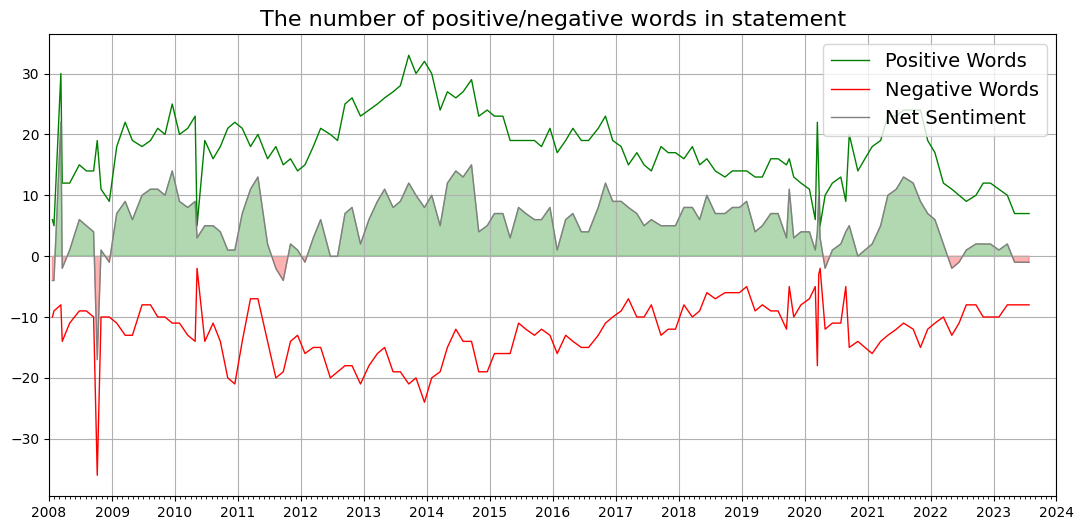

In [ ]:
NetSentiment = fomc_data['NPositiveWords'] - fomc_data['NNegativeWords']

plt.figure(figsize=(13,6))
ax = plt.subplot()

plt.plot(fomc_data.index, fomc_data['NPositiveWords'], c='green', linewidth= 1.0)
plt.plot(fomc_data.index, fomc_data['NNegativeWords']*-1, c='red', linewidth=1.0)
plt.plot(fomc_data.index, NetSentiment, c='grey', linewidth=1.0)

plt.title('The number of positive/negative words in statement', fontsize=16)
plt.legend(['Positive Words', 'Negative Words', 'Net Sentiment'], prop={'size': 14}, loc=1)

ax.fill_between(fomc_data.index, NetSentiment, where=(NetSentiment > 0), color='green', alpha=0.3, interpolate=True)
ax.fill_between(fomc_data.index, NetSentiment, where=(NetSentiment <= 0), color='red', alpha=0.3, interpolate=True)

import matplotlib.dates as mdates
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)

datemin = np.datetime64(fomc_data.index[0], 'Y')
datemax = np.datetime64(fomc_data.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

ax.grid(True)

plt.show()

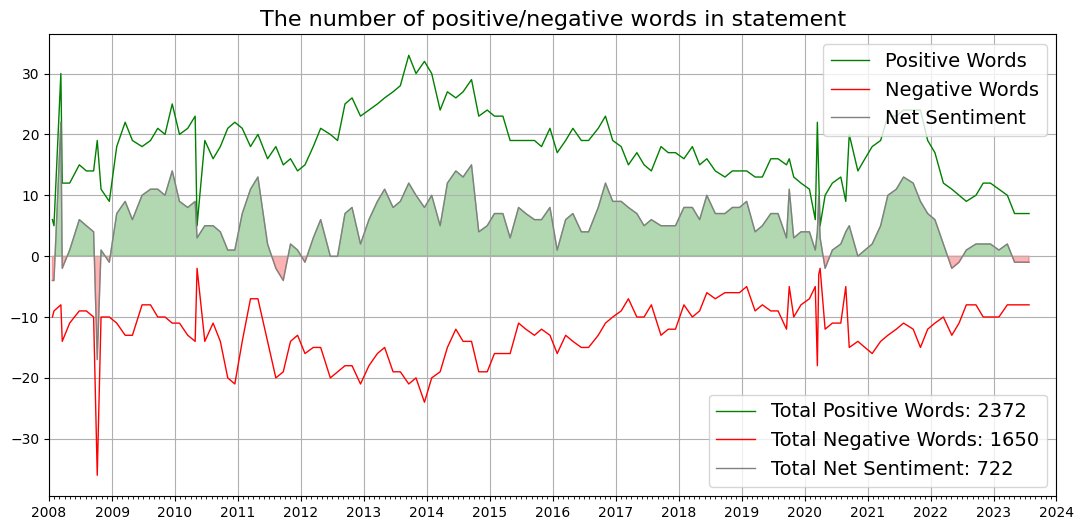

In [ ]:
# Calculate NetSentiment
NetSentiment = fomc_data['NPositiveWords'] - fomc_data['NNegativeWords']

plt.figure(figsize=(13, 6))
ax1 = plt.subplot()  # Storing subplot in ax1

# Plotting
plt.plot(fomc_data.index, fomc_data['NPositiveWords'], c='green', linewidth=1.0)
plt.plot(fomc_data.index, fomc_data['NNegativeWords']*-1, c='red', linewidth=1.0)
plt.plot(fomc_data.index, NetSentiment, c='grey', linewidth=1.0)

plt.title('The number of positive/negative words in statement', fontsize=16)

# First Legend
first_legend = plt.legend(['Positive Words', 'Negative Words', 'Net Sentiment'], prop={'size': 14}, loc=1)
plt.gca().add_artist(first_legend)

# Second Legend
total_positive = np.sum(fomc_data['NPositiveWords'])
total_negative = np.sum(fomc_data['NNegativeWords'])
total_net = np.sum(NetSentiment)

plt.legend([f'Total Positive Words: {total_positive}',
            f'Total Negative Words: {total_negative}',
            f'Total Net Sentiment: {total_net}'], prop={'size': 14}, loc=4)

# Fill between
ax1.fill_between(fomc_data.index, NetSentiment, where=(NetSentiment > 0), color='green', alpha=0.3, interpolate=True)
ax1.fill_between(fomc_data.index, NetSentiment, where=(NetSentiment <= 0), color='red', alpha=0.3, interpolate=True)

# Date formatting
import matplotlib.dates as mdates
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

# Format the ticks
ax1.xaxis.set_major_locator(years)
ax1.xaxis.set_major_formatter(years_fmt)
ax1.xaxis.set_minor_locator(months)

datemin = np.datetime64(fomc_data.index[0], 'Y')
datemax = np.datetime64(fomc_data.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax1.set_xlim(datemin, datemax)

ax1.grid(True)

plt.show()

Positive and negative word counts highly correlate... likely because the total number of words varies. Take the positive - negative as Net Sentiment.

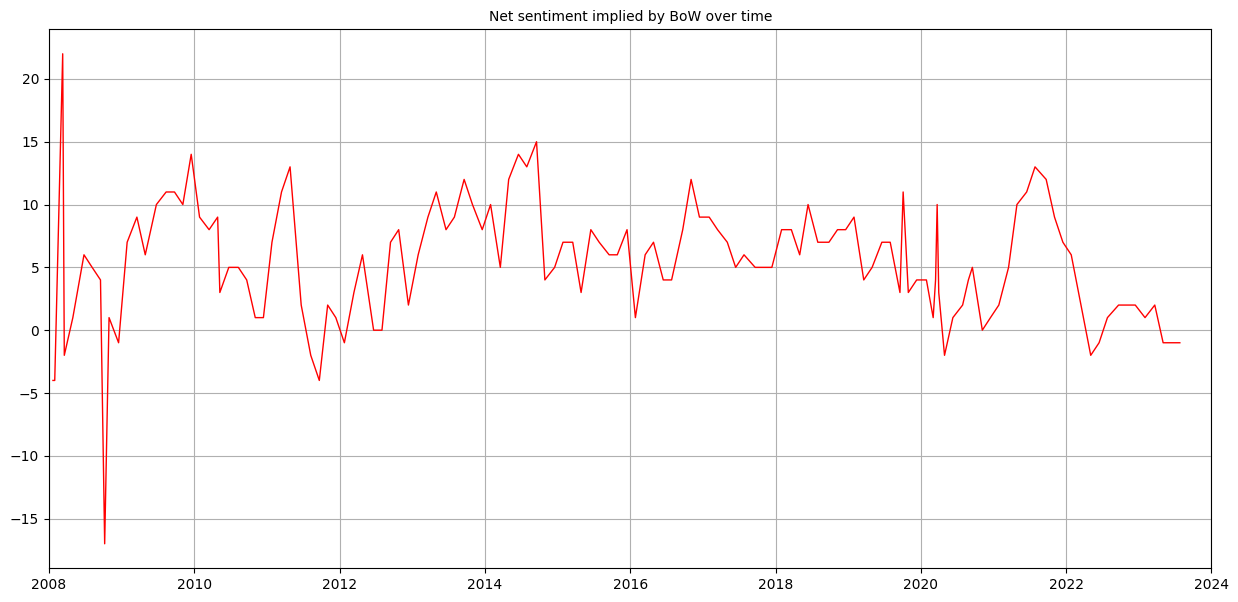

In [ ]:
NetSentiment = fomc_data['NPositiveWords'] - fomc_data['NNegativeWords']

fig, ax = plt.subplots(figsize=(15,7))

ax.plot(fomc_data.index, NetSentiment,
         c = 'red',
         linewidth= 1.0)

plt.title('Net sentiment implied by BoW over time',size = 'medium')

# format the ticks
# round to nearest years.
datemin = np.datetime64(fomc_data.index[0], 'Y')
datemax = np.datetime64(fomc_data.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.grid(True)


plt.show()

## 03.2 Plot the first derivative to see changes in the net sentiment


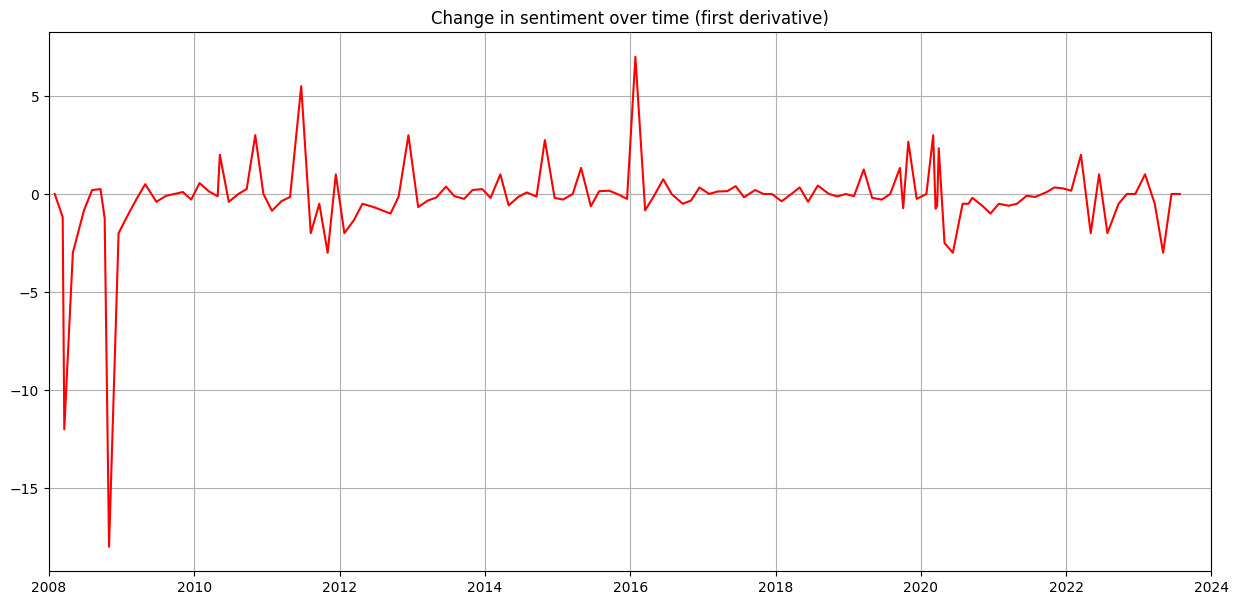

In [ ]:
firstderivative = (NetSentiment.shift(1) - NetSentiment) / NetSentiment

# Replace infinite values with NaN
firstderivative.replace([np.inf, -np.inf], np.nan, inplace=True)

# Interpolation to handle NaN values
firstderivative.interpolate(method='linear', inplace=True)

# Forward Fill NaN Values/ Backfill =bfill
#firstderivative.fillna(method='ffill', inplace=True)


fig, ax = plt.subplots(figsize=(15,7))

ax.plot(fomc_data.index, firstderivative,
         c = 'red')

plt.title('Change in sentiment over time (first derivative)')

# format the ticks
# round to nearest years.
datemin = np.datetime64(fomc_data.index[0], 'Y')
datemax = np.datetime64(fomc_data.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.grid(True)


plt.show()

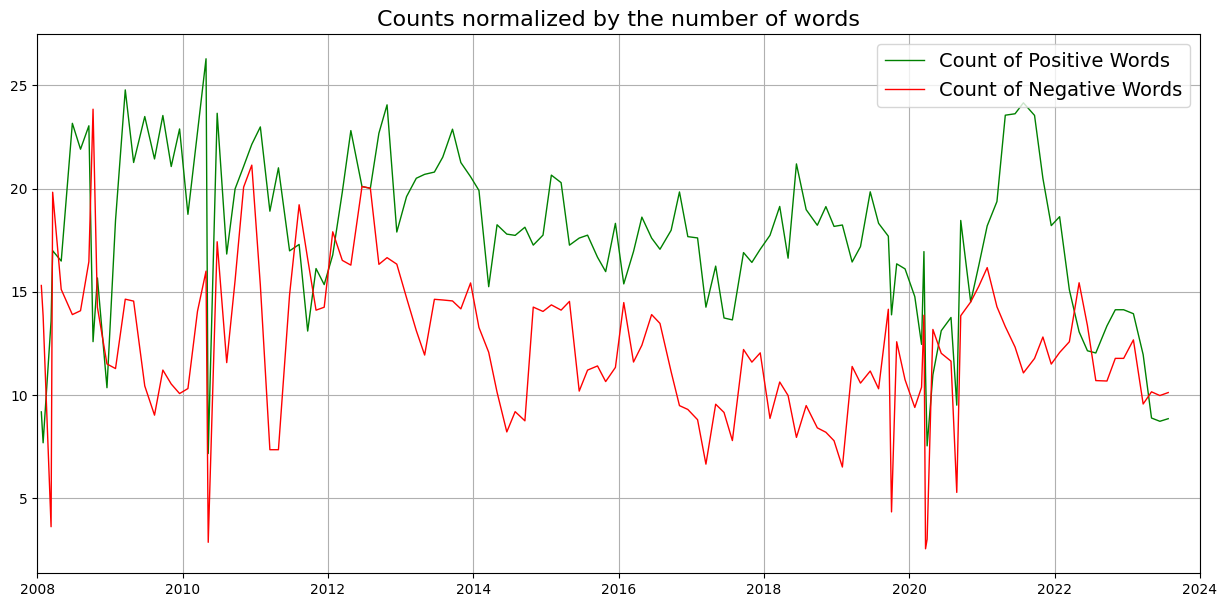

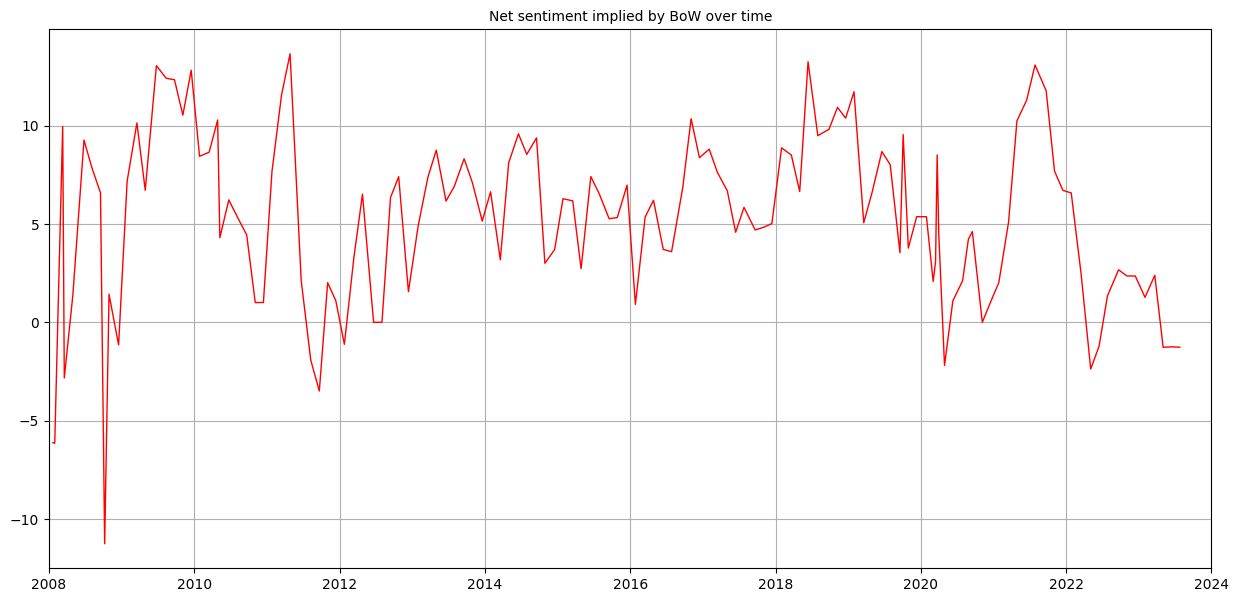

In [ ]:
# Normalize data
NPositiveWordsNorm = fomc_data['NPositiveWords'] / fomc_data['wordcount'] * np.mean(fomc_data['wordcount'])
NNegativeWordsNorm = fomc_data['NNegativeWords'] / fomc_data['wordcount'] * np.mean(fomc_data['wordcount'])
NetSentimentNorm = (NPositiveWordsNorm - NNegativeWordsNorm)

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(fomc_data.index, NPositiveWordsNorm, c='green', linewidth= 1.0)
plt.plot(fomc_data.index, NNegativeWordsNorm, c='red', linewidth=1.0)

plt.title('Counts normalized by the number of words', fontsize=16)
plt.legend(['Count of Positive Words', 'Count of Negative Words'],
           prop={'size': 14},
           loc = 1
           )

# format the ticks
# round to nearest years.
import matplotlib.dates as mdates
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

datemin = np.datetime64(fomc_data.index[0], 'Y')
datemax = np.datetime64(fomc_data.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.grid(True)

plt.show()


fig, ax = plt.subplots(figsize=(15,7))
ax.plot(fomc_data.index, NetSentimentNorm, c='red', linewidth=1.0)

plt.title('Net sentiment implied by BoW over time',size = 'medium')

# format the ticks
# round to nearest years.
datemin = np.datetime64(fomc_data.index[0], 'Y')
datemax = np.datetime64(fomc_data.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.grid(True)


plt.show()

## 03.3 Plot the results and compare to the economical uncertainty / systemic risk periods


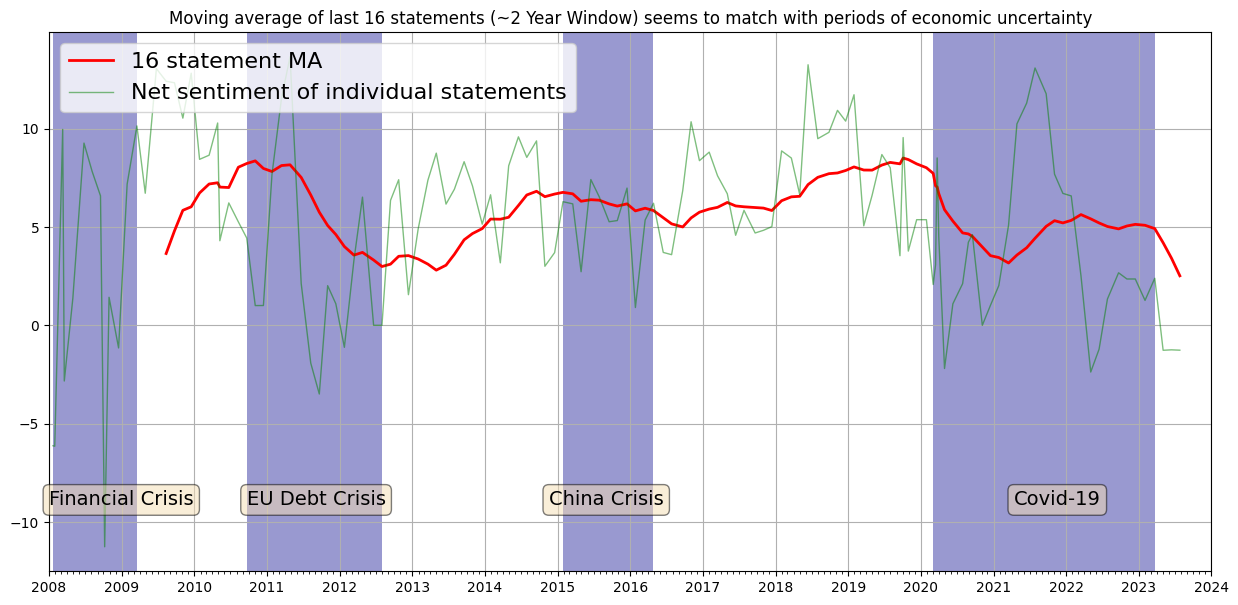

In [ ]:
#Financial crisis of 2007–2008
#https://en.wikipedia.org/wiki/Financial_crisis_of_2007%E2%80%932008
FinCrisis = np.logical_and(fomc_data.index >= '2008-01-01', fomc_data.index <= '2009-03-31')

#European debt crisis
#https://en.wikipedia.org/wiki/European_debt_crisis
EuroDebt = np.logical_and(fomc_data.index > '2010-09', fomc_data.index < '2012-09')

#2015–16 Chinese stock market turbulence
#https://en.wikipedia.org/wiki/2015%E2%80%9316_Chinese_stock_market_turbulence
Asian = np.logical_and(fomc_data.index > '2015-01', fomc_data.index < '2016-06')

#2020- Covid-19 Pandemic
#https://en.wikipedia.org/wiki/COVID-19_pandemic
Covid = np.logical_and(fomc_data.index > '2020-02', fomc_data.index < '2023-05')

Recessions = np.logical_or.reduce((FinCrisis, EuroDebt, Asian, Covid))

Window = 16
CompToMA = NetSentimentNorm.rolling(Window).mean()

fig, ax = plt.subplots(figsize=(15,7))

ax.plot(fomc_data.index, CompToMA, c = 'r', linewidth= 2)
ax.plot(fomc_data.index, NetSentimentNorm, c = 'green', linewidth= 1, alpha = 0.5)

# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)

# round to nearest years.
datemin = np.datetime64(fomc_data.index[0], 'Y')
datemax = np.datetime64(fomc_data.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.grid(True)

plt.title( str('Moving average of last ' + str(Window) + ' statements (~2 Year Window) seems to match with periods of economic uncertainty'))

ax.legend([str(str(Window) + ' statement MA'), 'Net sentiment of individual statements'],
           prop={'size': 16},
           loc = 2
          )

import matplotlib.transforms as mtransforms
trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
theta = 0.9
ax.fill_between(fomc_data.index, 0, 10, where = Recessions,
                facecolor='darkblue', alpha=0.4, transform=trans)

# Add text
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.00, 0.15, "Financial Crisis", transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
ax.text(0.17, 0.15, "EU Debt Crisis", transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
ax.text(0.43, 0.15, "China Crisis", transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
ax.text(0.83, 0.15, "Covid-19", transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)

plt.show()

# **04. Textual Modelling**

In [ ]:
# import the preprocessed economic and stock data from the stored pickle files
preprocessed_dir = "/content/drive/MyDrive/DSCI 521 Assignments and Project/Project/preprocessed"
train_dir = "/content/drive/MyDrive/DSCI 521 Assignments and Project/Project/train_data"
file_path = os.path.join(train_dir, 'nontext_train_small.pickle')

# Check if the file exists
if not os.path.exists(file_path):
    print(f"The file does not exist: {file_path}")
else:
    # Load data
    with open(file_path, 'rb') as file:
        train_df = pickle.load(file)

    print(train_df.shape)
    print(train_df)


(392, 10)
            target  prev_decision  GDP_diff_prev  PMI_value  Employ_diff_prev  \
date                                                                            
1982-10-05    -1.0            0.0       0.456199       38.8            -169.0   
1982-11-16    -1.0           -1.0      -0.382299       39.4            -228.0   
1982-12-21     0.0           -1.0      -0.382299       39.2            -198.5   
1983-01-14     0.0            0.0      -0.382299       42.8             -68.0   
1983-01-21     0.0            0.0      -0.382299       42.8             -68.0   
...            ...            ...            ...        ...               ...   
2021-12-15     0.0            0.0       0.570948       60.6             662.0   
2022-01-26     0.0            0.0       0.570948       58.8             578.5   
2022-03-16     1.0            0.0       1.679094       58.6             488.5   
2022-05-04     1.0            1.0       1.679094       57.1             488.5   
2022-06-15     1.0

In [ ]:
# List of Non-text columns
nontext_columns = train_df.drop(columns=['target']).columns.tolist()
nontext_columns

['prev_decision',
 'GDP_diff_prev',
 'PMI_value',
 'Employ_diff_prev',
 'Rsales_diff_year',
 'Unemp_diff_prev',
 'Inertia_diff',
 'Hsales_diff_year',
 'Balanced_diff']

In [ ]:
import os
import pickle

# Load text data
preprocessed_dir = "/content/drive/MyDrive/DSCI 521 Assignments and Project/Project/preprocessed"

def load_pickle_file(file_path):
    if not os.path.exists(file_path):
        print(f"The file does not exist: {file_path}")
        return None
    with open(file_path, 'rb') as file:
        return pickle.load(file)

text_no_split = load_pickle_file(os.path.join(preprocessed_dir, 'text_no_split.pickle'))
text_split_200 = load_pickle_file(os.path.join(preprocessed_dir, 'text_split_200.pickle'))
text_keyword = load_pickle_file(os.path.join(preprocessed_dir, 'text_keyword.pickle'))




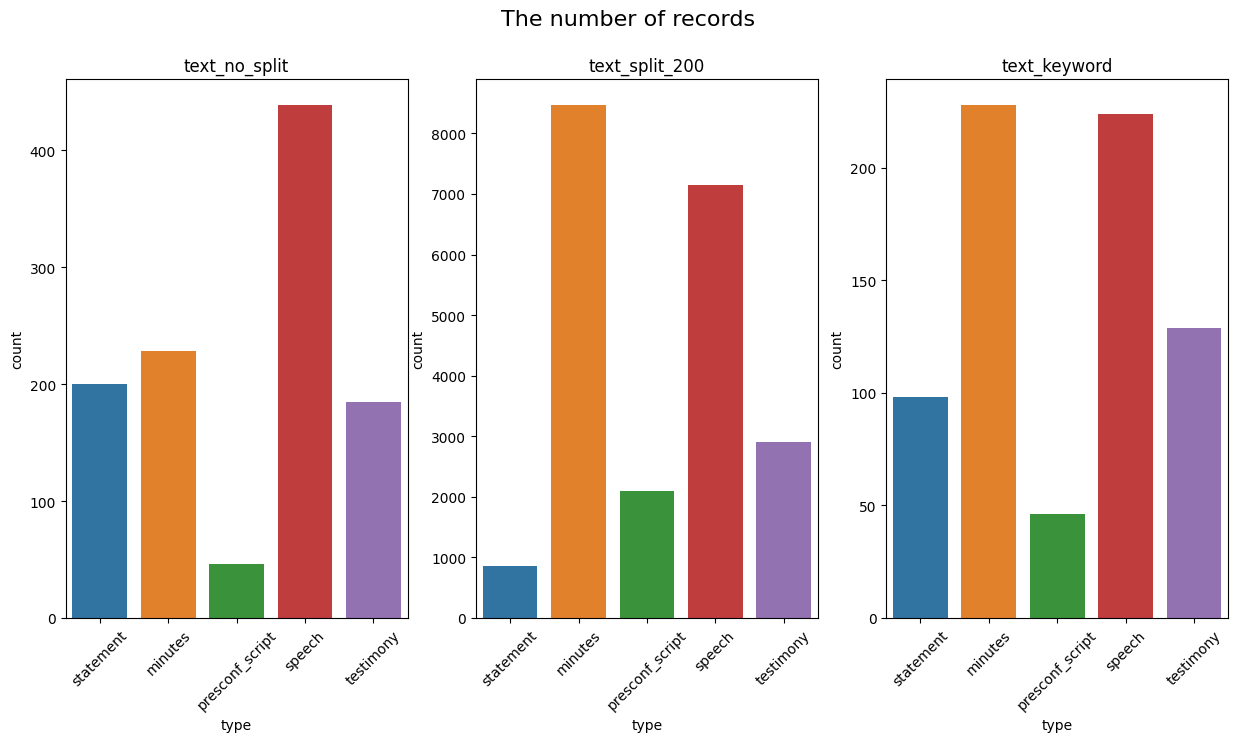

In [ ]:
import seaborn as sns
# retrieve the evaluation metrics and statistics for text data
# Drop meeting script data
text_no_split = text_no_split.loc[text_no_split['type'] != 'meeting_script']
text_split_200 = text_split_200.loc[text_split_200['type'] != 'meeting_script']
text_keyword = text_keyword.loc[text_keyword['type'] != 'meeting_script']

# Check the number of records per document type
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,7))
sns.countplot(x='type', data=text_no_split, ax=ax1)
ax1.set_title('text_no_split')
ax1.tick_params('x', labelrotation=45)
sns.countplot(x='type', data=text_split_200, ax=ax2)
ax2.set_title('text_split_200')
ax2.tick_params('x', labelrotation=45)
sns.countplot(x='type', data=text_keyword, ax=ax3)
ax3.set_title('text_keyword')
ax3.tick_params('x', labelrotation=45)
fig.suptitle("The number of records", fontsize=16)
plt.show()


In [ ]:
# Select one from the above different pre-processed data
text_df = text_no_split
text_df.reset_index(drop=True, inplace=True)
print(text_df.shape)
text_df

(1098, 11)


type       date                                              title  \
0     statement 1994-02-04                                     FOMC Statement   
1     statement 1994-03-22                                     FOMC Statement   
2     statement 1994-04-18                                     FOMC Statement   
3     statement 1994-05-17                                     FOMC Statement   
4     statement 1994-08-16                                     FOMC Statement   
...         ...        ...                                                ...   
1093  testimony 2021-06-22  The Federal Reserve&#39;s Response to the Coro...   
1094  testimony 2021-07-14  Semiannual Monetary Policy Report to the Congress   
1095  testimony 2021-09-28                          Coronavirus and CARES Act   
1096  testimony 2021-11-30                          Coronavirus and CARES Act   
1097  testimony 2022-01-11                                 Nomination hearing   

             speaker  word_count decision  rate next_meeting  next_decision  \
0     Alan Greenspan          99        1  3.25   1994-02-28              0   
1     Alan Greenspan          40        1   3.5   1994-04-18              1   
2     Alan Greenspan          37        1  3.75   1994-05-17              1   
3     Alan Greenspan          57        1  4.25   1994-07-06              0   
4     Alan Greenspan          51        1  4.75   1994-09-27              0   
...              ...         ...      ...   ...          ...            ...   
1093   Jerome Powell        1353     <NA>  None   2021-07-28              0   
1094   Jerome Powell         991     <NA>  None   2021-07-28              0   
1095   Jerome Powell         931     <NA>  None   2021-11-03              0   
1096   Jerome Powell         507     <NA>  None   2021-12-15              0   
1097   Jerome Powell         654     <NA>  None   2022-01-26              0   

      next_rate                                               text  
0          3.25  Chairman Alan Greenspan announced today that t...  
1          3.75  Chairman Alan Greenspan announced today that t...  
2          4.25  Chairman Alan Greenspan announced today that t...  
3          4.25  In taking the discount action, the Board appro...  
4          4.75  In taking the discount rate action, the Board ...  
...         ...                                                ...  
1093       0.00  Since we last met, the economy has shown susta...  
1094       0.00  At the Federal Reserve, we are strongly commit...  
1095       0.00  Chairman Brown, Ranking Member Toomey, and oth...  
1096       0.00  The economy has continued to strengthen. The r...  
1097       0.00  Chairman Brown, Ranking Member Toomey, and oth...  

[1098 rows x 11 columns]

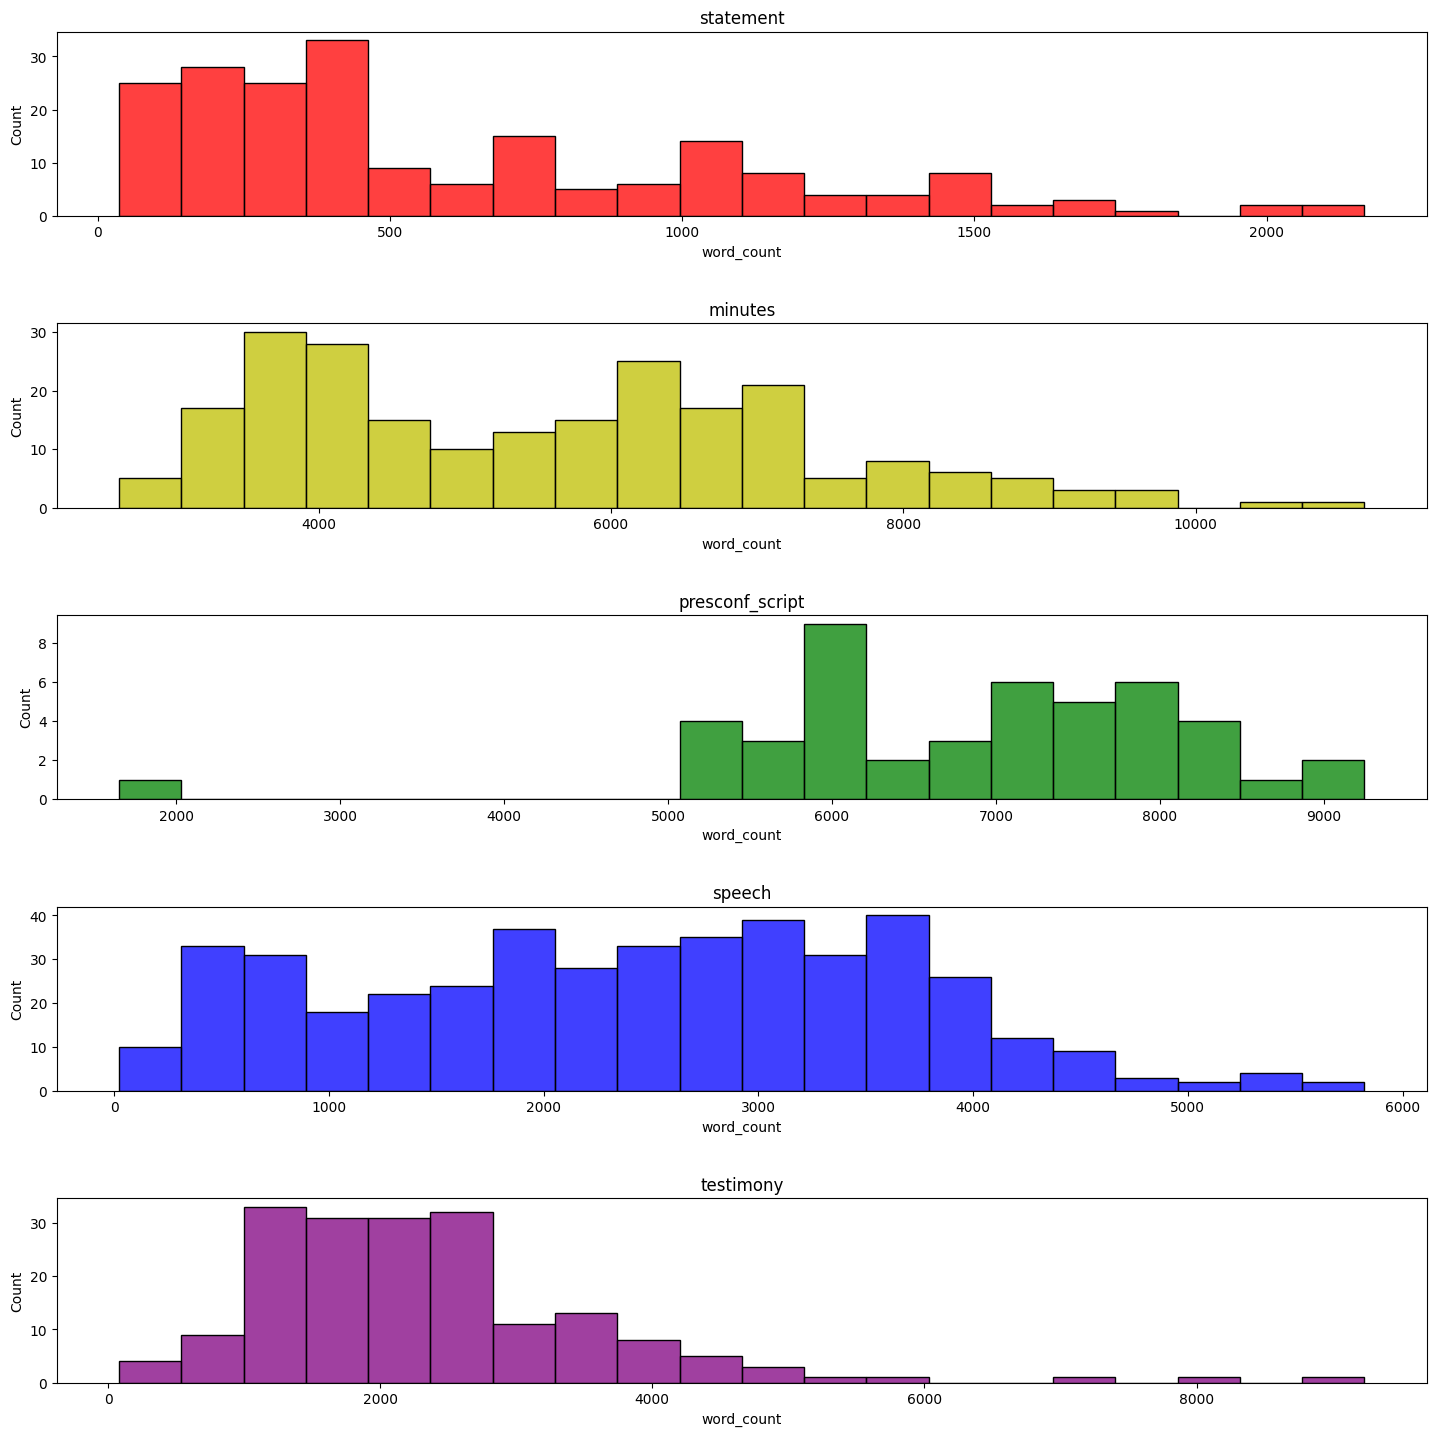

In [ ]:
# Check distribution

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(15,15))
doc_type = 'statement'
sns.histplot(text_df.loc[text_df['type'] == doc_type]['word_count'], bins=20, ax=ax1, color='r')
ax1.set_title(doc_type)
doc_type = 'minutes'
sns.histplot(text_df.loc[text_df['type'] == doc_type]['word_count'], bins=20, ax=ax2, color='y')
ax2.set_title(doc_type)
doc_type = 'presconf_script'
sns.histplot(text_df.loc[text_df['type'] == doc_type]['word_count'], bins=20, ax=ax3, color='g')
ax3.set_title(doc_type)
doc_type = 'speech'
sns.histplot(text_df.loc[text_df['type'] == doc_type]['word_count'], bins=20, ax=ax4, color='b')
ax4.set_title(doc_type)
doc_type = 'testimony'
sns.histplot(text_df.loc[text_df['type'] == doc_type]['word_count'], bins=20, ax=ax5, color='purple')
ax5.set_title(doc_type)

fig.tight_layout(pad=3.0)
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:712: UserWarning:

Using the countplot function without specifying `order` is likely to produce an incorrect plot.



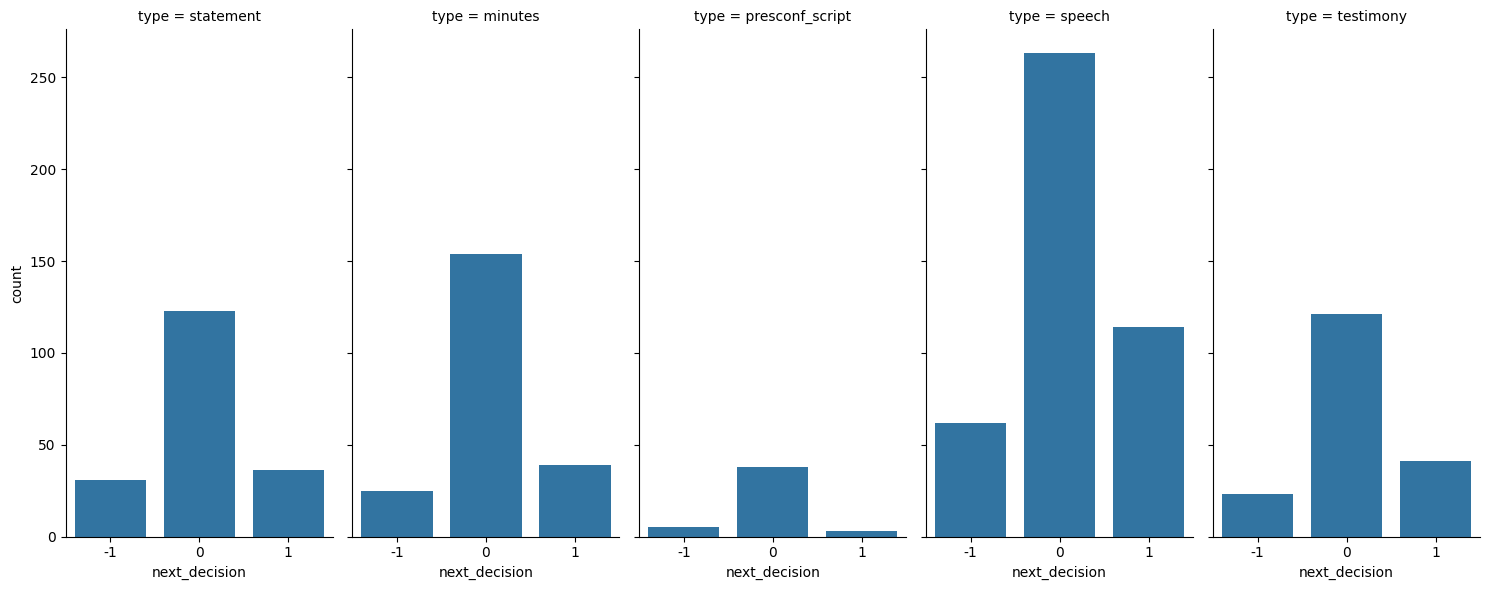

In [ ]:
# Check balance of Rate Decision

text_df = text_df.dropna(subset=['next_decision', 'type'])
g = sns.FacetGrid(text_df, col='type', height=6, aspect=0.5)
g.map(sns.countplot, 'next_decision')
plt.show()

In [ ]:
# MERGE TEXT INTO TRAINING DATAFRAME
from collections import defaultdict

doc_types = text_df['type'].unique()

merged_dict = defaultdict(list)

for i, row in train_df.iterrows():
    text_rows = text_df.loc[text_df['next_meeting'] == i]
    merged_text_all = ""
    for doc_type in doc_types:
        merged_text = ""
        for text in text_rows.loc[text_rows['type'] == doc_type]['text']:
            merged_text += " " + text
        merged_dict[doc_type].append(merged_text)
        merged_text_all += merged_text
    merged_dict['text'].append(merged_text_all)


In [ ]:
for key in merged_dict.keys():
    train_df[key] = merged_dict[key]
train_df

target  prev_decision  GDP_diff_prev  PMI_value  Employ_diff_prev  \
date                                                                            
1982-10-05    -1.0            0.0       0.456199       38.8            -169.0   
1982-11-16    -1.0           -1.0      -0.382299       39.4            -228.0   
1982-12-21     0.0           -1.0      -0.382299       39.2            -198.5   
1983-01-14     0.0            0.0      -0.382299       42.8             -68.0   
1983-01-21     0.0            0.0      -0.382299       42.8             -68.0   
...            ...            ...            ...        ...               ...   
2021-12-15     0.0            0.0       0.570948       60.6             662.0   
2022-01-26     0.0            0.0       0.570948       58.8             578.5   
2022-03-16     1.0            0.0       1.679094       58.6             488.5   
2022-05-04     1.0            1.0       1.679094       57.1             488.5   
2022-06-15     1.0            1.0       1.679094       57.1             488.5   

            Rsales_diff_year  Unemp_diff_prev  Inertia_diff  Hsales_diff_year  \
date                                                                            
1982-10-05          2.147714        -0.166667     -0.020483        -15.485275   
1982-11-16          2.147714        -0.200000     -0.020483         -9.537496   
1982-12-21          2.147714        -0.333333     -0.020483         -3.116275   
1983-01-14          2.147714        -0.233333     -0.020483         -0.774432   
1983-01-21          2.147714        -0.233333     -0.044066         -0.774432   
...                      ...              ...           ...               ...   
2021-12-15         10.359026         0.333333     -0.032410          0.118282   
2022-01-26         10.136027         0.266667     -0.094735         -3.435657   
2022-03-16          7.012346         0.200000     -0.206324         -3.435657   
2022-05-04          7.012346         0.200000     -0.013753         -3.435657   
2022-06-15          7.012346         0.200000      0.329787         -3.435657   

            Balanced_diff                                          statement  \
date                                                                           
1982-10-05       0.009908                                                      
1982-11-16       0.009908                                                      
1982-12-21       0.009908                                                      
1983-01-14       0.009908                                                      
1983-01-21       0.009908                                                      
...                   ...                                                ...   
2021-12-15       0.602821   With progress on vaccinations and strong poli...   
2022-01-26       0.708145   With progress on vaccinations and strong poli...   
2022-03-16       1.042328   Indicators of economic activity and employmen...   
2022-05-04       1.030935   The Committee seeks to achieve maximum employ...   
2022-06-15       0.629776   Although overall economic activity edged down...   

                                                      minutes  \
date                                                            
1982-10-05                                                      
1982-11-16                                                      
1982-12-21                                                      
1983-01-14                                                      
1983-01-21                                                      
...                                                       ...   
2021-12-15   Discussion of Financial Markets and Open Mark...   
2022-01-26   Developments in Financial Markets and Open Ma...   
2022-03-16   By unanimous vote, the Committee voted to rea...   
2022-05-04   Developments in Financial Markets and Open Ma...   
2022-06-15   Developments in Financial Markets and Open Ma...   

                 

In [ ]:
# Check if most of docs are merged

count_text, count_train = 0, 0

for doc_type in doc_types:
    count = 0
    for text in text_df.loc[text_df['type']==doc_type]['text']:
        count += len(text.split())
    print("{} words in original text for {}".format(count, doc_type))
    count_text += count

    count = 0
    for text in train_df[doc_type]:
        count += len(text.split())
    print("{} words in merged text for {}".format(count, doc_type))
    count_train += count

print("Total: {} words in original text".format(count_text))
print("Total: {} words in merged text".format(count_train))
print("Total: {} words in text column of merged text".format(train_df['text'].apply(lambda x: len(x.split())).sum()))

119944 words in original text for statement
119243 words in merged text for statement
1195343 words in original text for minutes
1189817 words in merged text for minutes
300551 words in original text for presconf_script
294700 words in merged text for presconf_script
1053788 words in original text for speech
976444 words in merged text for speech
428460 words in original text for testimony
407718 words in merged text for testimony
Total: 3098086 words in original text
Total: 2987922 words in merged text
Total: 2987922 words in text column of merged text


In [ ]:
# Load sentiment data

cvs_path = "/content/drive/MyDrive/DSCI 521 Assignments and Project/Project/LoughranMcDonald_SentimentWordLists_2018.csv"
sentiment_df = pd.read_csv(cvs_path)
print(sentiment_df.shape)
print(sentiment_df.head())

# Make all words lower case
sentiment_df['word'] = sentiment_df['word'].str.lower()
sentiments = sentiment_df['sentiment'].unique()
sentiment_df.groupby(by=['sentiment']).count()

sentiment_dict = { sentiment: sentiment_df.loc[sentiment_df['sentiment']==sentiment]['word'].values.tolist() for sentiment in sentiments}

(4133, 2)
  sentiment          word
0  Negative     ABANDONED
1  Negative    ABANDONING
2  Negative   ABANDONMENT
3  Negative  ABANDONMENTS
4  Negative      ABANDONS


In [ ]:
# Consider Negation
negate = ["aint", "arent", "cannot", "cant", "couldnt", "darent", "didnt", "doesnt", "ain't", "aren't", "can't",
          "couldn't", "daren't", "didn't", "doesn't", "dont", "hadnt", "hasnt", "havent", "isnt", "mightnt", "mustnt",
          "neither", "don't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't", "neednt", "needn't",
          "never", "none", "nope", "nor", "not", "nothing", "nowhere", "oughtnt", "shant", "shouldnt", "wasnt",
          "werent", "oughtn't", "shan't", "shouldn't", "wasn't", "weren't", "without", "wont", "wouldnt", "won't",
          "wouldn't", "rarely", "seldom", "despite", "no", "nobody"]

def negated(word):
    """
    Determine if preceding word is a negation word
    """
    if word.lower() in negate:
        return True
    else:
        return False

def tone_count_with_negation_check(dict, article):
    """
    Count positive and negative words with negation check. Account for simple negation only for positive words.
    Simple negation is taken to be observations of one of negate words occurring within three words
    preceding a positive words.
    """
    pos_count = 0
    neg_count = 0
    tone_score = 0

    pos_words = []
    neg_words = []

    input_words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', article.lower())
    word_count = len(input_words)

    for i in range(0, word_count):
        if input_words[i] in dict['Negative']:
            neg_count += 1
            neg_words.append(input_words[i])
        if input_words[i] in dict['Positive']:
            if i >= 3:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]) or negated(input_words[i - 3]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 2:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 1:
                if negated(input_words[i - 1]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 0:
                pos_count += 1
                pos_words.append(input_words[i])

    if word_count > 0:
        tone_score = 100 * (pos_count - neg_count) / word_count
    else:
        tone_score = 0

    results = [tone_score, word_count, pos_count, neg_count, pos_words, neg_words]

    return results

columns = ['tone_score', 'word_count', 'n_pos_words', 'n_neg_words', 'pos_words', 'neg_words']

In [ ]:
# Analyze tone for original text dataframe
import tqdm
print(text_df.shape)
tone_lmdict = [tone_count_with_negation_check(sentiment_dict, x) for x in tqdm.tqdm(text_df['text'], total=text_df.shape[0])]
tone_lmdict_df = pd.DataFrame(tone_lmdict, columns=columns)
text_df = pd.concat([text_df, tone_lmdict_df.reindex(text_df.index)], axis=1)
text_df

(1078, 11)


100%|██████████| 1078/1078 [02:16<00:00,  7.91it/s]


type       date                                              title  \
0     statement 1994-02-04                                     FOMC Statement   
1     statement 1994-03-22                                     FOMC Statement   
2     statement 1994-04-18                                     FOMC Statement   
3     statement 1994-05-17                                     FOMC Statement   
4     statement 1994-08-16                                     FOMC Statement   
...         ...        ...                                                ...   
1093  testimony 2021-06-22  The Federal Reserve&#39;s Response to the Coro...   
1094  testimony 2021-07-14  Semiannual Monetary Policy Report to the Congress   
1095  testimony 2021-09-28                          Coronavirus and CARES Act   
1096  testimony 2021-11-30                          Coronavirus and CARES Act   
1097  testimony 2022-01-11                                 Nomination hearing   

             speaker  word_count decision  rate next_meeting  next_decision  \
0     Alan Greenspan          99        1  3.25   1994-02-28              0   
1     Alan Greenspan          40        1   3.5   1994-04-18              1   
2     Alan Greenspan          37        1  3.75   1994-05-17              1   
3     Alan Greenspan          57        1  4.25   1994-07-06              0   
4     Alan Greenspan          51        1  4.75   1994-09-27              0   
...              ...         ...      ...   ...          ...            ...   
1093   Jerome Powell        1353      NaN   NaN   2021-07-28              0   
1094   Jerome Powell         991      NaN   NaN   2021-07-28              0   
1095   Jerome Powell         931      NaN   NaN   2021-11-03              0   
1096   Jerome Powell         507      NaN   NaN   2021-12-15              0   
1097   Jerome Powell         654      NaN   NaN   2022-01-26              0   

      next_rate                                               text  \
0          3.25  Chairman Alan Greenspan announced today that t...   
1          3.75  Chairman Alan Greenspan announced today that t...   
2          4.25  Chairman Alan Greenspan announced today that t...   
3          4.25  In taking the discount action, the Board appro...   
4          4.75  In taking the discount rate action, the Board ...   
...         ...                                                ...   
1093       0.00  Since we last met, the economy has shown susta...   
1094       0.00  At the Federal Reserve, we are strongly commit...   
1095       0.00  Chairman Brown, Ranking Member Toomey, and oth...   
1096       0.00  The economy has continued to strengthen. The r...   
1097       0.00  Chairman Brown, Ranking Member Toomey, and oth...   

      tone_score  word_count  n_pos_words  n_neg_words  pos_words  \
0            0.0        99.0          1.0          1.0  [enhance]   
1            0.0        40.0          0.0          0.0         []   
2            0.0        37.0          0.0          0.0         []   
3            0.0        57.0          0.0          0.0         []   
4            0.0        51.0          0.0          0.0         []   
...          ...         ...          ...          ...        ...   
1093         NaN         NaN          NaN          NaN        NaN   
1094         NaN         NaN          NaN          NaN        NaN   
1095         NaN         NaN          NaN          NaN        NaN   
1096         NaN         NaN          NaN          NaN        NaN   
1097         NaN         NaN          NaN          NaN        NaN   

               neg_words  
0     [misunderstanding]  
1                     []  
2                     []  
3                     []  
4                     []  
...                  ...  
1093                 NaN  
1094                 NaN  
1095                 NaN  
1096                 NaN  
1097                 NaN  

[1078 rows x 17 columns]

In [ ]:
# Analyze tone for training dataframe
import numpy as np
from tqdm import tqdm

tone_lmdict_list = []


# Assuming that `tone_count_with_negation_check` returns a single tone value for a text
for doc_type in doc_types:
    tone_lmdict = [tone_count_with_negation_check(sentiment_dict, x)[0] for x in tqdm(train_df[doc_type],
                                                                                          total=train_df.shape[0],
                                                                                          desc=doc_type)]
    tone_lmdict_list.append(tone_lmdict)

train_df['tone'] = np.mean(tone_lmdict_list, axis=0)
train_df


testimony: 100%|██████████| 392/392 [00:15<00:00, 25.05it/s]


target  prev_decision  GDP_diff_prev  PMI_value  Employ_diff_prev  \
date                                                                            
1982-10-05    -1.0            0.0       0.456199       38.8            -169.0   
1982-11-16    -1.0           -1.0      -0.382299       39.4            -228.0   
1982-12-21     0.0           -1.0      -0.382299       39.2            -198.5   
1983-01-14     0.0            0.0      -0.382299       42.8             -68.0   
1983-01-21     0.0            0.0      -0.382299       42.8             -68.0   
...            ...            ...            ...        ...               ...   
2021-12-15     0.0            0.0       0.570948       60.6             662.0   
2022-01-26     0.0            0.0       0.570948       58.8             578.5   
2022-03-16     1.0            0.0       1.679094       58.6             488.5   
2022-05-04     1.0            1.0       1.679094       57.1             488.5   
2022-06-15     1.0            1.0       1.679094       57.1             488.5   

            Rsales_diff_year  Unemp_diff_prev  Inertia_diff  Hsales_diff_year  \
date                                                                            
1982-10-05          2.147714        -0.166667     -0.020483        -15.485275   
1982-11-16          2.147714        -0.200000     -0.020483         -9.537496   
1982-12-21          2.147714        -0.333333     -0.020483         -3.116275   
1983-01-14          2.147714        -0.233333     -0.020483         -0.774432   
1983-01-21          2.147714        -0.233333     -0.044066         -0.774432   
...                      ...              ...           ...               ...   
2021-12-15         10.359026         0.333333     -0.032410          0.118282   
2022-01-26         10.136027         0.266667     -0.094735         -3.435657   
2022-03-16          7.012346         0.200000     -0.206324         -3.435657   
2022-05-04          7.012346         0.200000     -0.013753         -3.435657   
2022-06-15          7.012346         0.200000      0.329787         -3.435657   

            Balanced_diff                                          statement  \
date                                                                           
1982-10-05       0.009908                                                      
1982-11-16       0.009908                                                      
1982-12-21       0.009908                                                      
1983-01-14       0.009908                                                      
1983-01-21       0.009908                                                      
...                   ...                                                ...   
2021-12-15       0.602821   With progress on vaccinations and strong poli...   
2022-01-26       0.708145   With progress on vaccinations and strong poli...   
2022-03-16       1.042328   Indicators of economic activity and employmen...   
2022-05-04       1.030935   The Committee seeks to achieve maximum employ...   
2022-06-15       0.629776   Although overall economic activity edged down...   

                                                      minutes  \
date                                                            
1982-10-05                                                      
1982-11-16                                                      
1982-12-21                                                      
1983-01-14                                                      
1983-01-21                                                      
...                                                       ...   
2021-12-15   Discussion of Financial Markets and Open Mark...   
2022-01-26   Developments in Financial Markets and Open Ma...   
2022-03-16   By unanimous vote, the Committee voted to rea...   
2022-05-04   Developments in Financial Markets and Open Ma...   
2022-06-15   Developments in Financial Markets and Open Ma...   

                 

In [ ]:
print(text_df.columns)

# weird bug causing two calcualted columns for tone_score, dropping second column
# dropping by index may work --> index = 11

print(text_df.columns[11])
# text_df = text_df.drop(text_df.columns[<index_of_column_to_drop>], axis=1)

#text_df = text_df.drop('tone_score', axis=1)


Index(['type', 'date', 'title', 'speaker', 'word_count', 'decision', 'rate',
       'next_meeting', 'next_decision', 'next_rate', 'text', 'tone_score',
       'word_count', 'n_pos_words', 'n_neg_words', 'pos_words', 'neg_words'],
      dtype='object')
tone_score


In [ ]:
text_df['tone_score']

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
1093    NaN
1094    NaN
1095    NaN
1096    NaN
1097    NaN
Name: tone_score, Length: 1078, dtype: float64

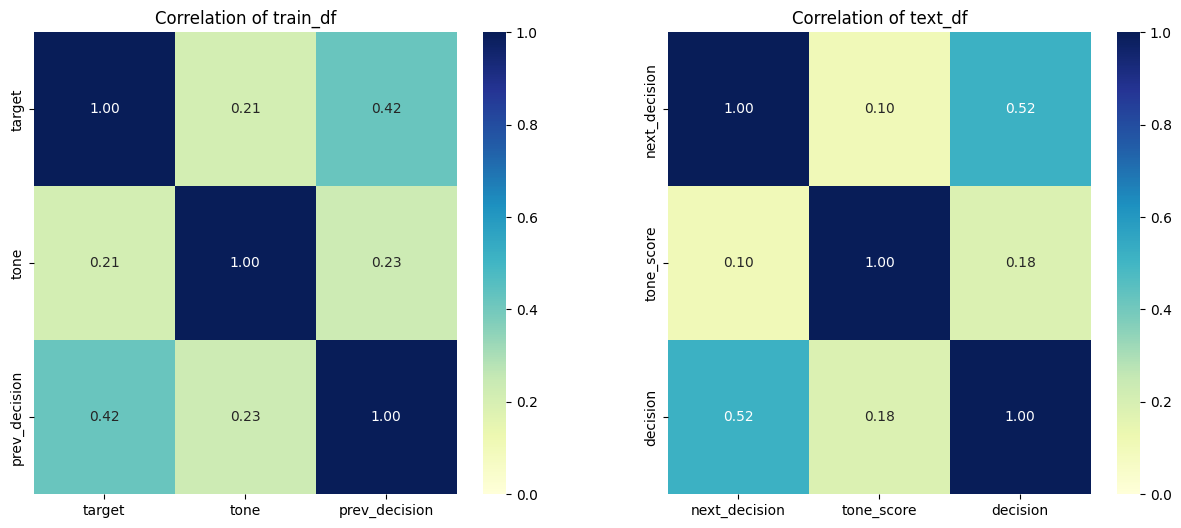

In [ ]:
# Show corelations to next_decision
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

corr_columns = ['target', 'tone', 'prev_decision']
sns.heatmap(train_df[corr_columns].astype(float).corr(), cmap="YlGnBu", annot=True, fmt=".2f", ax=ax1, vmin=0, vmax=1)
ax1.set_title("Correlation of train_df")

corr_columns = ['next_decision', 'tone_score', 'decision']
tmp_df = pd.DataFrame()
for column in corr_columns:
    tmp_df[column] = pd.to_numeric(text_df[column], errors='coerce')
sns.heatmap(tmp_df.astype(float).corr(), cmap="YlGnBu", annot=True, fmt=".2f", ax=ax2, vmin=0, vmax=1)
ax2.set_title("Correlation of text_df")

plt.show()

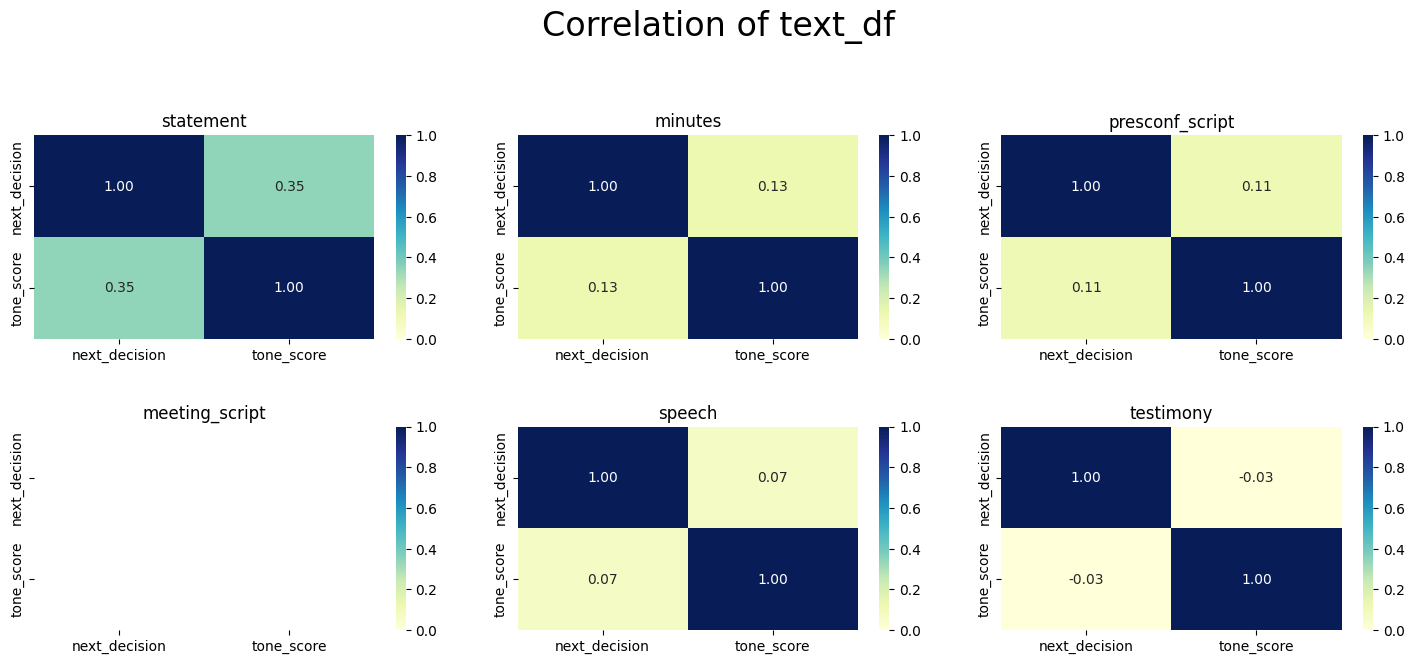

In [ ]:
# Per document type
corr_columns = ['next_decision', 'tone_score', 'type']
tmp_df = pd.DataFrame()
for column in corr_columns:
    tmp_df[column] = pd.to_numeric(text_df[column], errors='coerce')
tmp_df['type'] = text_df['type']
doc_types = ['statement', 'minutes', 'presconf_script', 'meeting_script', 'speech', 'testimony']

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15,7))

axes = [ax1, ax2, ax3, ax4, ax5, ax6]
for i, doc_type in enumerate(doc_types):
    sns.heatmap(tmp_df.loc[tmp_df['type'] == doc_type].drop(columns=['type']).astype(float).corr(), cmap="YlGnBu", annot=True, fmt=".2f", vmin=0, vmax=1, ax=axes[i])
    axes[i].set_title(doc_type)

fig.suptitle('Correlation of text_df', fontsize=24)
fig.tight_layout(pad=3.0)
plt.show()

## 04.1 Tokenization, Vectorization and Lemmentization

In [ ]:
!pip install scikit-plot

In [ ]:
# Python libraries
import datetime as dt
import re
import pickle
from tqdm.notebook import tqdm
import os
import sys
import time
import logging
import random
from collections import defaultdict, Counter

# Data Science modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('ggplot')

# Import Scikit-learn moduels
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, StratifiedKFold, learning_curve, RandomizedSearchCV
import scikitplot as skplt

# Import nltk modules and download dataset
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop = set(stopwords.words('english'))

# Import Pytorch modules
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)
from torch.autograd import Variable
from torch.optim import Adam, AdamW

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
def lemmatize_word(word):
    '''
    Return the same word after lemmatizing the input word
    '''
    wnl = nltk.stem.WordNetLemmatizer()
    return wnl.lemmatize(wnl.lemmatize(word, 'n'), 'v')

def tokenize_df(df, col='text'):
    '''
    Extract words which are only alphabet and not in stop word, convert to lower case.
    '''
    from tqdm import tqdm

    tokenized = []
    wnl = nltk.stem.WordNetLemmatizer()
    for text in tqdm(df[col]):
        # Filter alphabet words only and non stop words, make it lower case
        words = [word.lower() for word in word_tokenize(text) if ((word.isalpha()==1) & (word not in stop))]
        # Lemmatize words
        tokens = [lemmatize_word(word) for word in words]
        tokenized.append(tokens)
    return tokenized



In [ ]:
tokenized_org = tokenize_df(text_df)
print('len(tokenized_org): ', len(tokenized_org))
print(tokenized_org[0])

100%|██████████| 1078/1078 [01:38<00:00, 10.90it/s]

len(tokenized_org):  1078
['chairman', 'alan', 'greenspan', 'announce', 'today', 'federal', 'open', 'market', 'committee', 'decide', 'increase', 'slightly', 'degree', 'pressure', 'reserve', 'position', 'the', 'action', 'expect', 'associate', 'small', 'increase', 'money', 'market', 'interest', 'rate', 'the', 'decision', 'take', 'move', 'toward', 'le', 'accommodative', 'stance', 'monetary', 'policy', 'order', 'sustain', 'enhance', 'economic', 'expansion', 'chairman', 'greenspan', 'decide', 'announce', 'action', 'immediately', 'avoid', 'misunderstand', 'committee', 'purpose', 'give', 'fact', 'first', 'firm', 'reserve', 'market', 'condition', 'committee', 'since', 'early']


In [ ]:
# Concat the list to create docs
lemma_docs_org = [" ".join(words) for words in tokenized_org]
print('len(lemma_docs_org): ', len(lemma_docs_org))
print(lemma_docs_org[0])

# Create a list of all the words in the dataframe
all_words_org = [word for text in tokenized_org for word in text]
print('len(all_words_org): ', len(all_words_org))
print(all_words_org[0])

# Counter object of all the words
counts_org = Counter(all_words_org)
print('len(counts_org): ', len(counts_org))

# Create a Bag of Word, sorted by the count of words
bow_org = sorted(counts_org, key=counts_org.get, reverse=True)
print('bow_org[:20]', bow_org[:20])

# Indexing vocabrary, starting from 1.
vocab_org = {word: ii for ii, word in enumerate(counts_org, 1)}
id2vocab_org = {v: k for k, v in vocab_org.items()}

print("vocab_org['chairman']: ", vocab_org['chairman'])
print("vocab_org['market']: ", vocab_org['market'])

# Create token id list
token_ids_org = [[vocab_org[word] for word in text_words] for text_words in tokenized_org]
print(len(token_ids_org))

# Add to the dataframe
text_df['tokenized'] = tokenized_org
text_df['token_ids'] = token_ids_org

len(lemma_docs_org):  1078
chairman alan greenspan announce today federal open market committee decide increase slightly degree pressure reserve position the action expect associate small increase money market interest rate the decision take move toward le accommodative stance monetary policy order sustain enhance economic expansion chairman greenspan decide announce action immediately avoid misunderstand committee purpose give fact first firm reserve market condition committee since early
len(all_words_org):  1819928
chairman
len(counts_org):  20626
bow_org[:20] ['market', 'rate', 'the', 'inflation', 'economic', 'financial', 'policy', 'price', 'federal', 'bank', 'committee', 'would', 'increase', 'growth', 'year', 'in', 'economy', 'continue', 'i', 'reserve']
vocab_org['chairman']:  1
vocab_org['market']:  8
1078


## 04.2 Tokenzie train_df

In [ ]:
tokenized = tokenize_df(train_df)
print('len(tokenized): ', len(tokenized))
print(tokenized[0])

# Concat the list to create docs
lemma_docs = [" ".join(words) for words in tokenized]
print('len(lemma_docs): ', len(lemma_docs))
print(lemma_docs[0])

# Create a list of all the words in the dataframe
all_words = [word for text in tokenized for word in text]
print('len(all_words): ', len(all_words))
print(all_words[0])

# Counter object of all the words
counts = Counter(all_words)
print('len(counts): ', len(counts))

# Create a Bag of Word, sorted by the count of words
bow = sorted(counts, key=counts.get, reverse=True)
print('bow[:20]', bow[:20])

# Indexing vocabrary, starting from 1.
vocab = {word: ii for ii, word in enumerate(counts, 1)}
id2vocab = {v: k for k, v in vocab.items()}

# Create token id list
token_ids = [[vocab[word] for word in text_words] for text_words in tokenized]
print(len(token_ids))

# Add to the dataframe
train_df['tokenized'] = tokenized
train_df['token_ids'] = token_ids
train_df['tokenized_text'] = train_df['tokenized'].apply(lambda x: " ".join(x))

100%|██████████| 392/392 [01:31<00:00,  4.30it/s]


len(tokenized):  392
[]
len(lemma_docs):  392

len(all_words):  1755859
the
len(counts):  20465
bow[:20] ['market', 'the', 'rate', 'inflation', 'economic', 'financial', 'price', 'policy', 'bank', 'federal', 'committee', 'would', 'increase', 'growth', 'year', 'in', 'economy', 'continue', 'reserve', 'i']
392


<Axes: xlabel='tokenized_text', ylabel='Count'>

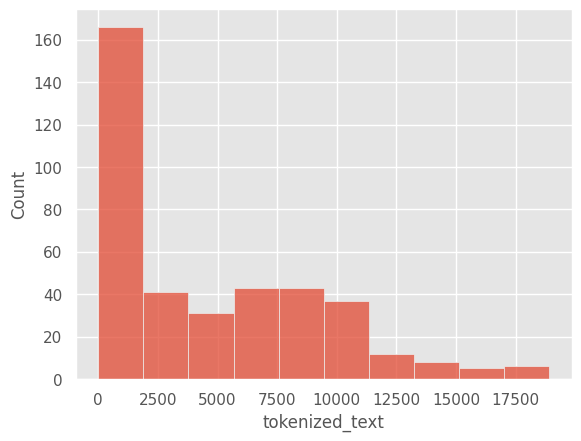

In [ ]:
sns.histplot(train_df['tokenized_text'].apply(lambda x: len(x.split())))


##04.3 Lemmentization

In [ ]:
# Lemmertize sentiment words as well
lemma_sentiment_df = sentiment_df.copy(deep=True)
lemma_sentiment_df['word'] = [lemmatize_word(word) for word in lemma_sentiment_df['word']]
# Drop duplicates
lemma_sentiment_df = sentiment_df.drop_duplicates('word')
# Sentiment list
lemma_sentiments = list(lemma_sentiment_df['sentiment'].unique())

In [ ]:
print(lemma_sentiment_df.groupby(by=['sentiment']).count())

              word
sentiment         
Constraining   144
Litigious      749
Negative      2354
Positive       353
StrongModal     14
Uncertainty    256


## 04.4 TD-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

def get_tfidf(sentiment_words, docs):
    """
    Generate TFIDF values from documents for a certain sentiment

    Parameters
    ----------
    sentiment_words: Pandas Series
        Words that signify a certain sentiment
    docs : list of str
        List of documents used to generate bag of words

    Returns
    -------
    tfidf : 2-d Numpy Ndarray of float
        TFIDF sentiment for each document
        The first dimension is the document.
        The second dimension is the word.
    """
    vectorizer = TfidfVectorizer(analyzer='word', vocabulary=sentiment_words)
    tfidf = vectorizer.fit_transform(docs)
    features = vectorizer.get_feature_names_out()

    return tfidf.toarray()

# Using the get_tfidf function, let's generate the TFIDF values for all the documents.
sentiment_tfidf_org = {
        sentiment: get_tfidf(lemma_sentiment_df.loc[lemma_sentiment_df['sentiment'] == sentiment]['word'], lemma_docs_org)
        for sentiment in lemma_sentiments}

print(len(sentiment_tfidf_org['Negative']))
print(len(sentiment_tfidf_org['Negative'][0]))

print(text_df.shape)

for sentiment in lemma_sentiments:
    text_df['tfidf_' + sentiment] = list(sentiment_tfidf_org[sentiment])

text_df

1078
2354
(1078, 19)


type       date                                              title  \
0     statement 1994-02-04                                     FOMC Statement   
1     statement 1994-03-22                                     FOMC Statement   
2     statement 1994-04-18                                     FOMC Statement   
3     statement 1994-05-17                                     FOMC Statement   
4     statement 1994-08-16                                     FOMC Statement   
...         ...        ...                                                ...   
1093  testimony 2021-06-22  The Federal Reserve&#39;s Response to the Coro...   
1094  testimony 2021-07-14  Semiannual Monetary Policy Report to the Congress   
1095  testimony 2021-09-28                          Coronavirus and CARES Act   
1096  testimony 2021-11-30                          Coronavirus and CARES Act   
1097  testimony 2022-01-11                                 Nomination hearing   

             speaker  word_count decision  rate next_meeting  next_decision  \
0     Alan Greenspan          99        1  3.25   1994-02-28              0   
1     Alan Greenspan          40        1   3.5   1994-04-18              1   
2     Alan Greenspan          37        1  3.75   1994-05-17              1   
3     Alan Greenspan          57        1  4.25   1994-07-06              0   
4     Alan Greenspan          51        1  4.75   1994-09-27              0   
...              ...         ...      ...   ...          ...            ...   
1093   Jerome Powell        1353      NaN   NaN   2021-07-28              0   
1094   Jerome Powell         991      NaN   NaN   2021-07-28              0   
1095   Jerome Powell         931      NaN   NaN   2021-11-03              0   
1096   Jerome Powell         507      NaN   NaN   2021-12-15              0   
1097   Jerome Powell         654      NaN   NaN   2022-01-26              0   

      next_rate  ...  pos_words           neg_words  \
0          3.25  ...  [enhance]  [misunderstanding]   
1          3.75  ...         []                  []   
2          4.25  ...         []                  []   
3          4.25  ...         []                  []   
4          4.75  ...         []                  []   
...         ...  ...        ...                 ...   
1093       0.00  ...        NaN                 NaN   
1094       0.00  ...        NaN                 NaN   
1095       0.00  ...        NaN                 NaN   
1096       0.00  ...        NaN                 NaN   
1097       0.00  ...        NaN                 NaN   

                                              tokenized  \
0     [chairman, alan, greenspan, announce, today, f...   
1     [chairman, alan, greenspan, announce, today, f...   
2     [chairman, alan, greenspan, announce, today, f...   
3     [in, take, discount, action, board, approve, r...   
4     [in, take, discount, rate, action, board, appr...   
...                                                 ...   
1093  [since, last, meet, economy, show, sustain, im...   
1094  [at, federal, reserve, strongly, commit, achie...   
1095  [chairman, brown, rank, member, toomey, member...   
1096  [the, economy, continue, strengthen, the, rise...   
1097  [chairman, brown, rank, member, toomey, member...   

                                              token_ids  \
0     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
1     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
2     [1, 2, 3, 4, 5, 6, 15, 11, 12, 13, 14, 15, 16,...   
3     [51, 26, 52, 18, 53, 54, 55, 56, 53, 57, 58, 6...   
4     [51, 26, 52, 24, 18, 53, 54, 55, 56, 53, 57, 6...   
...                                                 ...   
1093  [48, 120, 251, 180, 569, 35, 682, 767, 1375, 2...   
1094  [384, 6, 15, 794, 1206, 693, 32, 33, 389, 1680...   
1095  [1, 16509, 13700, 348, 20620, 348, 9, 8992, 14...   
1096  [17, 180, 296, 298, 17, 90, 10676, 1379, 885, ...   
1097  [1, 16509, 13700, 348, 20620, 348, 9, 8992, 14...   

          

In [ ]:
# Using the get_tfidf function, let's generate the TFIDF values for all the documents.
sentiment_tfidf = {
        sentiment: get_tfidf(lemma_sentiment_df.loc[lemma_sentiment_df['sentiment'] == sentiment]['word'], lemma_docs)
        for sentiment in lemma_sentiments}

print(len(sentiment_tfidf['Negative']))
print(len(sentiment_tfidf['Negative'][0]))

for sentiment in lemma_sentiments:
    train_df['tfidf_' + sentiment] = list(sentiment_tfidf[sentiment])

train_df

392
2354


target  prev_decision  GDP_diff_prev  PMI_value  Employ_diff_prev  \
date                                                                            
1982-10-05    -1.0            0.0       0.456199       38.8            -169.0   
1982-11-16    -1.0           -1.0      -0.382299       39.4            -228.0   
1982-12-21     0.0           -1.0      -0.382299       39.2            -198.5   
1983-01-14     0.0            0.0      -0.382299       42.8             -68.0   
1983-01-21     0.0            0.0      -0.382299       42.8             -68.0   
...            ...            ...            ...        ...               ...   
2021-12-15     0.0            0.0       0.570948       60.6             662.0   
2022-01-26     0.0            0.0       0.570948       58.8             578.5   
2022-03-16     1.0            0.0       1.679094       58.6             488.5   
2022-05-04     1.0            1.0       1.679094       57.1             488.5   
2022-06-15     1.0            1.0       1.679094       57.1             488.5   

            Rsales_diff_year  Unemp_diff_prev  Inertia_diff  Hsales_diff_year  \
date                                                                            
1982-10-05          2.147714        -0.166667     -0.020483        -15.485275   
1982-11-16          2.147714        -0.200000     -0.020483         -9.537496   
1982-12-21          2.147714        -0.333333     -0.020483         -3.116275   
1983-01-14          2.147714        -0.233333     -0.020483         -0.774432   
1983-01-21          2.147714        -0.233333     -0.044066         -0.774432   
...                      ...              ...           ...               ...   
2021-12-15         10.359026         0.333333     -0.032410          0.118282   
2022-01-26         10.136027         0.266667     -0.094735         -3.435657   
2022-03-16          7.012346         0.200000     -0.206324         -3.435657   
2022-05-04          7.012346         0.200000     -0.013753         -3.435657   
2022-06-15          7.012346         0.200000      0.329787         -3.435657   

            Balanced_diff  ...      tone  \
date                       ...             
1982-10-05       0.009908  ...  0.000000   
1982-11-16       0.009908  ...  0.000000   
1982-12-21       0.009908  ...  0.000000   
1983-01-14       0.009908  ...  0.000000   
1983-01-21       0.009908  ...  0.000000   
...                   ...  ...       ...   
2021-12-15       0.602821  ... -0.171046   
2022-01-26       0.708145  ...  0.280862   
2022-03-16       1.042328  ...  0.011205   
2022-05-04       1.030935  ... -0.123666   
2022-06-15       0.629776  ... -0.299071   

                                                    tokenized  \
date                                                            
1982-10-05                                                 []   
1982-11-16                                                 []   
1982-12-21                                                 []   
1983-01-14                                                 []   
1983-01-21                                                 []   
...                                                       ...   
2021-12-15  [with, progress, vaccination, strong, policy, ...   
2022-01-26  [with, progress, vaccination, strong, policy, ...   
2022-03-16  [indicator, economic, activity, employment, co...   
2022-05-04  [the, committee, seek, achieve, maximum, emplo...   
2022-06-15  [although, overall, economic, activity, edge, ...   

                                                    token_ids  \
date                                                            
1982-10-05                                                 []   
1982-11-16                                                 []   
1982-12-21                                                 []   
1983-01-14                                                 []   
1983-01-21                                                 []   
...                           

## 04.5 Cosine Integrity

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def get_cosine_similarity(tfidf_matrix):
    """
    Get cosine similarities for each neighboring TFIDF vector/document

    Parameters
    ----------
    tfidf : 2-d Numpy Ndarray of float
        TFIDF sentiment for each document
        The first dimension is the document.
        The second dimension is the word.

    Returns
    -------
    cosine_similarities : list of float
        Cosine similarities for neighboring documents
    """
    #print(tfidf_matrix)
    return [cosine_similarity(u.reshape(1,-1), v.reshape(1,-1))[0][0].tolist() for u, v in zip(tfidf_matrix, tfidf_matrix[1:])]

In [ ]:
# Tokenize and vectorize the text data
def lemmatize_word(word):
    '''
    Return the same word after lemmatizing the input word
    '''
    wnl = nltk.stem.WordNetLemmatizer()
    return wnl.lemmatize(wnl.lemmatize(word, 'n'), 'v')

def tokenize_df(df, col='text'):
    '''
    Extract words which are only aphabet and not in stop word, covert to lower case.
    '''
    tokenized = []
    wnl = nltk.stem.WordNetLemmatizer()
    for text in tqdm(df[col]):
        # Filter alphabet words only and non stop words, make it loser case
        words = [word.lower() for word in word_tokenize(text) if ((word.isalpha()==1) & (word not in stop))]
        # Lemmatize words
        tokens = [lemmatize_word(word) for word in words]
        tokenized.append(tokens)
    return tokenized


In [ ]:
cosine_similarities = {
    sentiment_name: get_cosine_similarity(sentiment_values)
    for sentiment_name, sentiment_values in sentiment_tfidf.items()}

print(len(cosine_similarities['Negative']))

391


In [ ]:
for sentiment in lemma_sentiments:
    # Add 0 to the first element as there is no comparison available to a previous value
    cosine_similarities[sentiment].insert(0, 0)
    train_df['cos_sim_' + sentiment] = cosine_similarities[sentiment]

train_df

target  prev_decision  GDP_diff_prev  PMI_value  Employ_diff_prev  \
date                                                                            
1982-10-05    -1.0            0.0       0.456199       38.8            -169.0   
1982-11-16    -1.0           -1.0      -0.382299       39.4            -228.0   
1982-12-21     0.0           -1.0      -0.382299       39.2            -198.5   
1983-01-14     0.0            0.0      -0.382299       42.8             -68.0   
1983-01-21     0.0            0.0      -0.382299       42.8             -68.0   
...            ...            ...            ...        ...               ...   
2021-12-15     0.0            0.0       0.570948       60.6             662.0   
2022-01-26     0.0            0.0       0.570948       58.8             578.5   
2022-03-16     1.0            0.0       1.679094       58.6             488.5   
2022-05-04     1.0            1.0       1.679094       57.1             488.5   
2022-06-15     1.0            1.0       1.679094       57.1             488.5   

            Rsales_diff_year  Unemp_diff_prev  Inertia_diff  Hsales_diff_year  \
date                                                                            
1982-10-05          2.147714        -0.166667     -0.020483        -15.485275   
1982-11-16          2.147714        -0.200000     -0.020483         -9.537496   
1982-12-21          2.147714        -0.333333     -0.020483         -3.116275   
1983-01-14          2.147714        -0.233333     -0.020483         -0.774432   
1983-01-21          2.147714        -0.233333     -0.044066         -0.774432   
...                      ...              ...           ...               ...   
2021-12-15         10.359026         0.333333     -0.032410          0.118282   
2022-01-26         10.136027         0.266667     -0.094735         -3.435657   
2022-03-16          7.012346         0.200000     -0.206324         -3.435657   
2022-05-04          7.012346         0.200000     -0.013753         -3.435657   
2022-06-15          7.012346         0.200000      0.329787         -3.435657   

            Balanced_diff  ...  \
date                       ...   
1982-10-05       0.009908  ...   
1982-11-16       0.009908  ...   
1982-12-21       0.009908  ...   
1983-01-14       0.009908  ...   
1983-01-21       0.009908  ...   
...                   ...  ...   
2021-12-15       0.602821  ...   
2022-01-26       0.708145  ...   
2022-03-16       1.042328  ...   
2022-05-04       1.030935  ...   
2022-06-15       0.629776  ...   

                                            tfidf_Uncertainty  \
date                                                            
1982-10-05  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1982-11-16  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1982-12-21  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1983-01-14  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1983-01-21  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
...                                                       ...   
2021-12-15  [0.0, 0.02135264869178362, 0.0, 0.0, 0.0, 0.0,...   
2022-01-26  [0.0, 0.042413876619589626, 0.0, 0.0, 0.0, 0.0...   
2022-03-16  [0.0, 0.030706473359222795, 0.0, 0.0, 0.0, 0.0...   
2022-05-04  [0.0, 0.057012019678173084, 0.0, 0.0, 0.0, 0.0...   
2022-06-15  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.33934433...   

                                              tfidf_Litigious  \
date                                                            
1982-10-05  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1982-11-16  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1982-12-21  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1983-01-14  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1983-01-21  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
...                                                       ...   
2021-12-15  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2022-01-26  [0.0, 0.0, 0.0, 0.

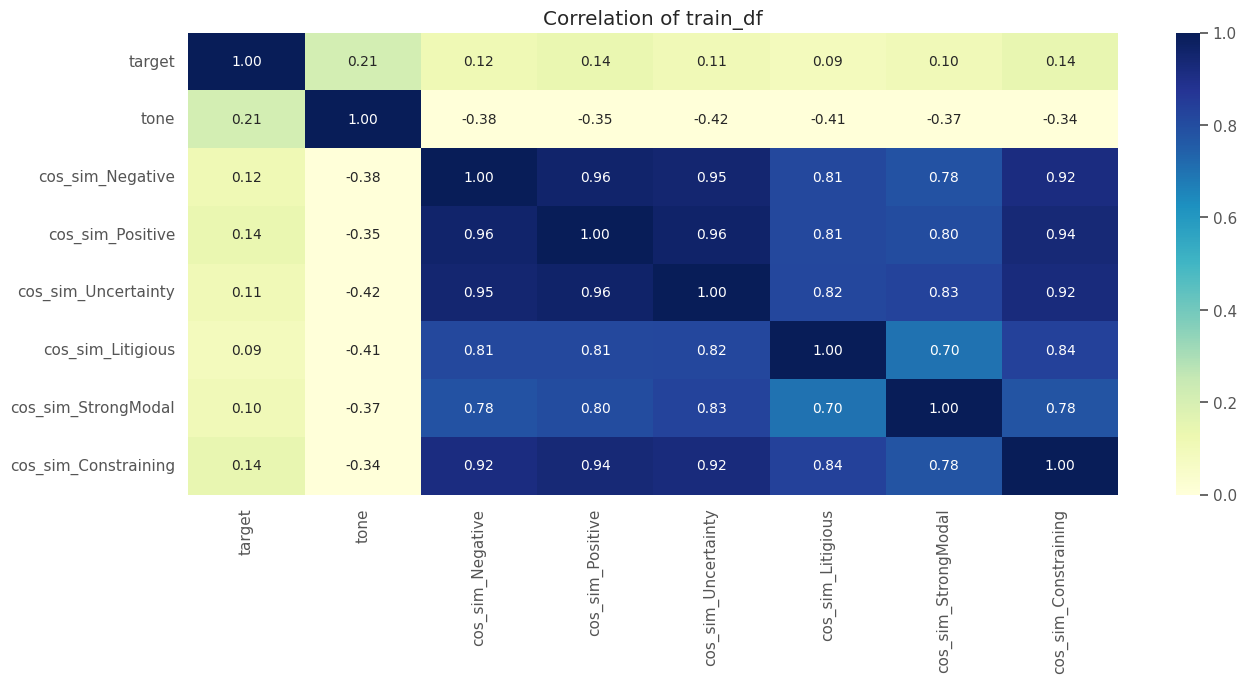

In [ ]:
# Show corelations to target
fig, ax = plt.subplots(figsize=(15,6))
corr_columns = ['target', 'tone', 'cos_sim_Negative', 'cos_sim_Positive', 'cos_sim_Uncertainty', 'cos_sim_Litigious', 'cos_sim_StrongModal', 'cos_sim_Constraining']
sns.heatmap(train_df[corr_columns].astype(float).corr(), cmap="YlGnBu", annot=True, fmt=".2f", ax=ax, vmin=0, vmax=1)
ax.set_title("Correlation of train_df")
plt.show()

In [ ]:
def convert_class(x):
    if x == 1:
        return 2
    elif x == 0:
        return 1
    elif x == -1:
        return 0

In [ ]:
train_df['target'] = train_df['target'].map(convert_class)
train_df['prev_decision'] = train_df['prev_decision'].map(convert_class)

## 04.6 K-Fold Set Up

In [ ]:
# Use Stratified KFold Cross Validation
# Training data is not so many, keep n_split <= 5
kfold = StratifiedKFold(n_splits=3)
print(kfold)


# Define metrics
# Here, use F1 Macro to evaluate the model.
def metric(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    return acc, f1

scoring = {'Accuracy': 'accuracy', 'F1': 'f1_macro'}
refit = 'F1'

StratifiedKFold(n_splits=3, random_state=None, shuffle=False)


In [ ]:
def train_grid_search(estimator, param_grid, scoring, refit, cv=5, verbose=1, plot=True):
    model = GridSearchCV(estimator, param_grid=param_grid, cv=cv, scoring=scoring, verbose=verbose,
                         refit=refit, n_jobs=-1, return_train_score=True)
    model.fit(X_train, Y_train)

    results = model.cv_results_
    best_estimator = model.best_estimator_
    train_scores = results['mean_train_' + refit]
    test_scores = results['mean_test_' + refit]
    train_time = results['mean_fit_time']

    print("Best Score: ", model.best_score_)
    print("Best Param: ", model.best_params_)

    pred_train = best_estimator.predict(X_train)
    pred_test = best_estimator.predict(X_test)

    acc, f1 = metric(Y_train, pred_train)
    logger.info('Training - acc: %.8f, f1: %.8f' % (acc, f1))
    acc, f1 = metric(Y_test, pred_test)
    logger.info('Test - acc: %.8f, f1: %.8f' % (acc, f1))

    if plot:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle("GridSearchCV Result", fontsize=20)

        ### First plot ###
        ax1.plot(train_scores, test_scores, 'bo')
        ax1.set_title("Train Score v.s. Test Score", fontsize=16)
        ax1.set_xlabel("Train Score")
        ax1.set_ylabel("Test Score")
        ax1.set_xlim(0, 1)
        ax1.set_ylim(0, 1)
        ax1.grid(True)

        ### Second plot ###
        x_param = list(param_grid.keys())[0]
        x_param_min = np.min(list(param_grid.values())[0])
        x_param_max = np.max(list(param_grid.values())[0])

        ax2.set_title("Score over the first param", fontsize=16)
        ax2.set_xlabel(x_param)
        ax2.set_ylabel("Score")
        ax2.set_xlim(x_param_min, x_param_max)
        ax2.set_ylim(0, 1)

        # Get the regular numpy array from the MaskedArray
        X_axis = np.array(results['param_' + x_param].data, dtype=float)

        for scorer, color in zip(sorted(scoring), ['r', 'g']):
            for sample, style in (('train', '--'), ('test', '-')):
                sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
                sample_score_std = results['std_%s_%s' % (sample, scorer)]
                ax2.fill_between(X_axis, sample_score_mean - sample_score_std,
                                sample_score_mean + sample_score_std,
                                alpha=0.1 if sample == 'test' else 0, color=color)
                ax2.plot(X_axis, sample_score_mean, style, color=color,
                        alpha=1 if sample == 'test' else 0.7,
                        label="%s (%s)" % (scorer, sample.capitalize()))

            best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
            best_score = results['mean_test_%s' % scorer][best_index]

            # Plot a dotted vertical line at the best score for that scorer marked by x
            ax2.plot([X_axis[best_index], ] * 2, [0, best_score],
                    linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

            # Annotate the best score for that scorer
            ax2.annotate("%0.2f" % best_score,
                        (X_axis[best_index], best_score + 0.005))

        ax2.legend(loc="best")
        ax2.grid(False)

        ### Third plot (Learning Curve) ###
        # Calculate learning curve (Accuracy)
        lc_acc_train_sizes, lc_acc_train_scores, lc_acc_test_scores = learning_curve(
            best_estimator, X_train, Y_train, cv=kfold, n_jobs=-1, scoring=scoring['Accuracy'],
            train_sizes=np.linspace(.1, 1.0, 5))
        lc_acc_train_mean = np.mean(lc_acc_train_scores, axis=1)
        lc_acc_train_std = np.std(lc_acc_train_scores, axis=1)
        lc_acc_test_mean = np.mean(lc_acc_test_scores, axis=1)
        lc_acc_test_std = np.std(lc_acc_test_scores, axis=1)

        # Calculate learning curve (F1 Score)
        lc_f1_train_sizes, lc_f1_train_scores, lc_f1_test_scores = learning_curve(
            best_estimator, X_train, Y_train, cv=kfold, n_jobs=-1, scoring=scoring['F1'],
            train_sizes=np.linspace(.1, 1.0, 5))
        lc_f1_train_mean = np.mean(lc_f1_train_scores, axis=1)
        lc_f1_train_std = np.std(lc_f1_train_scores, axis=1)
        lc_f1_test_mean = np.mean(lc_f1_test_scores, axis=1)
        lc_f1_test_std = np.std(lc_f1_test_scores, axis=1)

        ax3.set_title("Learning Curve", fontsize=16)
        ax3.set_xlabel("Training examples")
        ax3.set_ylabel("Score")

        # Plot learning curve (Accuracy)
        ax3.fill_between(lc_acc_train_sizes,
                         lc_acc_train_mean - lc_acc_train_std,
                         lc_acc_train_mean + lc_acc_train_std, alpha=0.1, color="r")
        ax3.fill_between(lc_acc_train_sizes,
                         lc_acc_test_mean - lc_acc_test_std,
                         lc_acc_test_mean + lc_acc_test_std, alpha=0.1, color="r")
        ax3.plot(lc_acc_train_sizes, lc_acc_train_mean, 'o--', color="r",
                 label="Accuracy (Train)")
        ax3.plot(lc_acc_train_sizes, lc_acc_test_mean, 'o-', color="r",
                 label="Accuracy (Test)")

        # Plot learning curve (F1 Score)
        ax3.fill_between(lc_f1_train_sizes,
                         lc_f1_train_mean - lc_f1_train_std,
                         lc_f1_train_mean + lc_f1_train_std, alpha=0.1, color="g")
        ax3.fill_between(lc_f1_train_sizes,
                         lc_f1_test_mean - lc_f1_test_std,
                         lc_f1_test_mean + lc_f1_test_std, alpha=0.1, color="g")
        ax3.plot(lc_f1_train_sizes, lc_f1_train_mean, 'o--', color="g",
                 label="F1 (Train)")
        ax3.plot(lc_f1_train_sizes, lc_f1_test_mean, 'o-', color="g",
                 label="F1 (Test)")

        ax3.legend(loc="best")
        ax3.grid(True)

        plt.tight_layout(pad=3.0)
        plt.show()

        ### Confusion Matrix ###
        class_names = ['Lower', 'Hold', 'Raise']
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle("Confusion Matrix", fontsize=20)

        ConfusionMatrixDisplay.from_estimator(best_estimator, X_train, Y_train, display_labels=class_names,
                                            cmap=plt.cm.Blues, normalize=None, ax=ax1)
        ax1.set_title("Train Data: Actual Count")
        ax1.grid(False)

        ConfusionMatrixDisplay.from_estimator(best_estimator, X_train, Y_train, display_labels=class_names,
                                            cmap=plt.cm.Blues, normalize='all', ax=ax2)
        ax2.set_title("Train Data: Normalized")
        ax2.grid(False)

        ConfusionMatrixDisplay.from_estimator(best_estimator, X_test, Y_test, display_labels=class_names,
                                            cmap=plt.cm.Blues, normalize=None, ax=ax3)
        ax3.set_title("Test Data: Actual Count")
        ax3.grid(False)

        ConfusionMatrixDisplay.from_estimator(best_estimator, X_test, Y_test, display_labels=class_names,
                                            cmap=plt.cm.Blues, normalize='all', ax=ax4)
        ax4.set_title("Test Data: Normalized")
        ax4.grid(False)

        plt.tight_layout(pad=3.0)
        plt.show()

    return model


In [ ]:
# create copy of the train
split_train_df = train_df.drop(columns=['statement',
       'minutes', 'presconf_script', 'speech', 'testimony',
       'tokenized', 'token_ids', 'tokenized_text', 'tfidf_Negative',
       'tfidf_Positive', 'tfidf_Uncertainty', 'tfidf_Litigious',
       'tfidf_StrongModal', 'tfidf_Constraining', 'cos_sim_Negative',
       'cos_sim_Positive', 'cos_sim_Uncertainty', 'cos_sim_Litigious',
       'cos_sim_StrongModal', 'cos_sim_Constraining'])

print(split_train_df.shape)

(392, 12)


In [ ]:
train_df.columns

Index(['target', 'prev_decision', 'GDP_diff_prev', 'PMI_value',
       'Employ_diff_prev', 'Rsales_diff_year', 'Unemp_diff_prev',
       'Inertia_diff', 'Hsales_diff_year', 'Balanced_diff', 'statement',
       'minutes', 'presconf_script', 'speech', 'testimony', 'text', 'tone',
       'tokenized', 'token_ids', 'tokenized_text', 'tfidf_Negative',
       'tfidf_Positive', 'tfidf_Uncertainty', 'tfidf_Litigious',
       'tfidf_StrongModal', 'tfidf_Constraining', 'cos_sim_Negative',
       'cos_sim_Positive', 'cos_sim_Uncertainty', 'cos_sim_Litigious',
       'cos_sim_StrongModal', 'cos_sim_Constraining'],
      dtype='object')

In [ ]:

# X and Y data used
Y_data = train_df['target']
X_data = train_df[nontext_columns + ['tone', 'cos_sim_Negative', 'cos_sim_Positive', 'cos_sim_Uncertainty',
                                     'cos_sim_Litigious', 'cos_sim_StrongModal', 'cos_sim_Constraining']]

# Train test split (Shuffle=False will make the test data for the most recent ones)
X_train, X_test, Y_train, Y_test = \
model_selection.train_test_split(X_data.values, Y_data.values, test_size=0.2, shuffle=True)

In [ ]:
tokenized = tokenize_df(split_train_df)
lemma_docs = [" ".join(words) for words in tokenized]
all_words = [word for text in tokenized for word in text]
counts = Counter(all_words)
bow = sorted(counts, key=counts.get, reverse=True)
vocab = {word: ii for ii, word in enumerate(counts, 1)}
id2vocab = {v: k for k, v in vocab.items()}
token_ids = [[vocab[word] for word in text_words] for text_words in tokenized]

# Add to the dataframe
split_train_df['token_ids'] = token_ids


  0%|          | 0/392 [00:00<?, ?it/s]

In [ ]:
# Set logger
logger = logging.getLogger('mylogger')
logger.setLevel(logging.INFO)

timestamp = time.strftime("%Y.%m.%d_%H.%M.%S", time.localtime())
formatter = logging.Formatter('[%(asctime)s][%(levelname)s] ## %(message)s')

fh = logging.FileHandler('log_model.txt')
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)
logger.addHandler(fh)

ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
ch.setFormatter(formatter)
logger.addHandler(ch)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[2023-09-03 20:11:21,587][INFO] ## Training - acc: 0.96166134, f1: 0.94279249
INFO:mylogger:Training - acc: 0.96166134, f1: 0.94279249
[2023-09-03 20:11:21,596][INFO] ## Test - acc: 0.64556962, f1: 0.52202889
INFO:mylogger:Test - acc: 0.64556962, f1: 0.52202889


Best Score:  0.6087842641607765
Best Param:  {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 7, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 53}


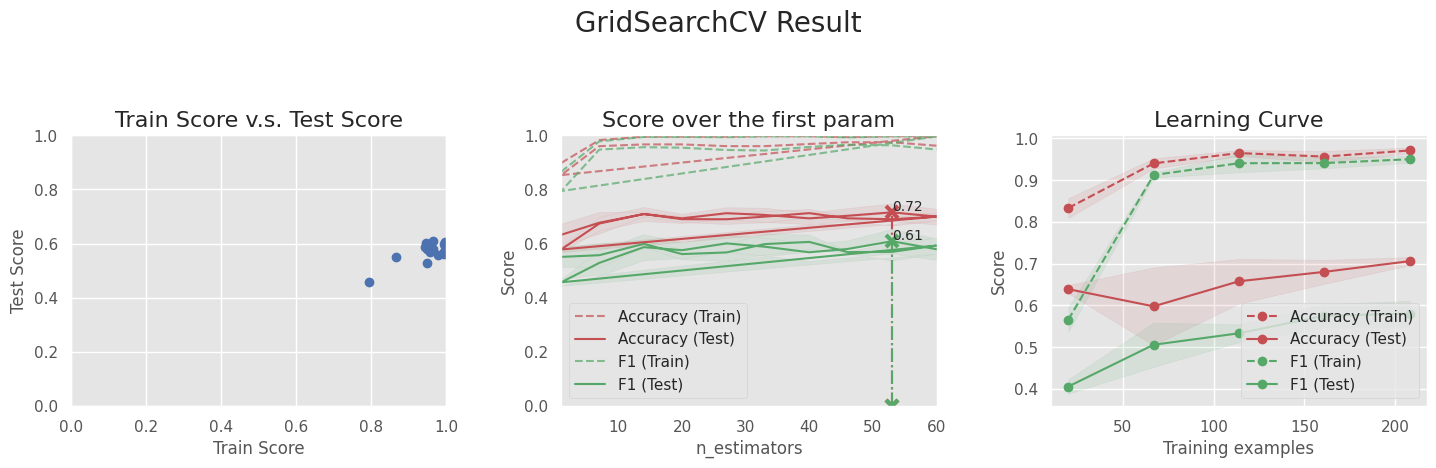

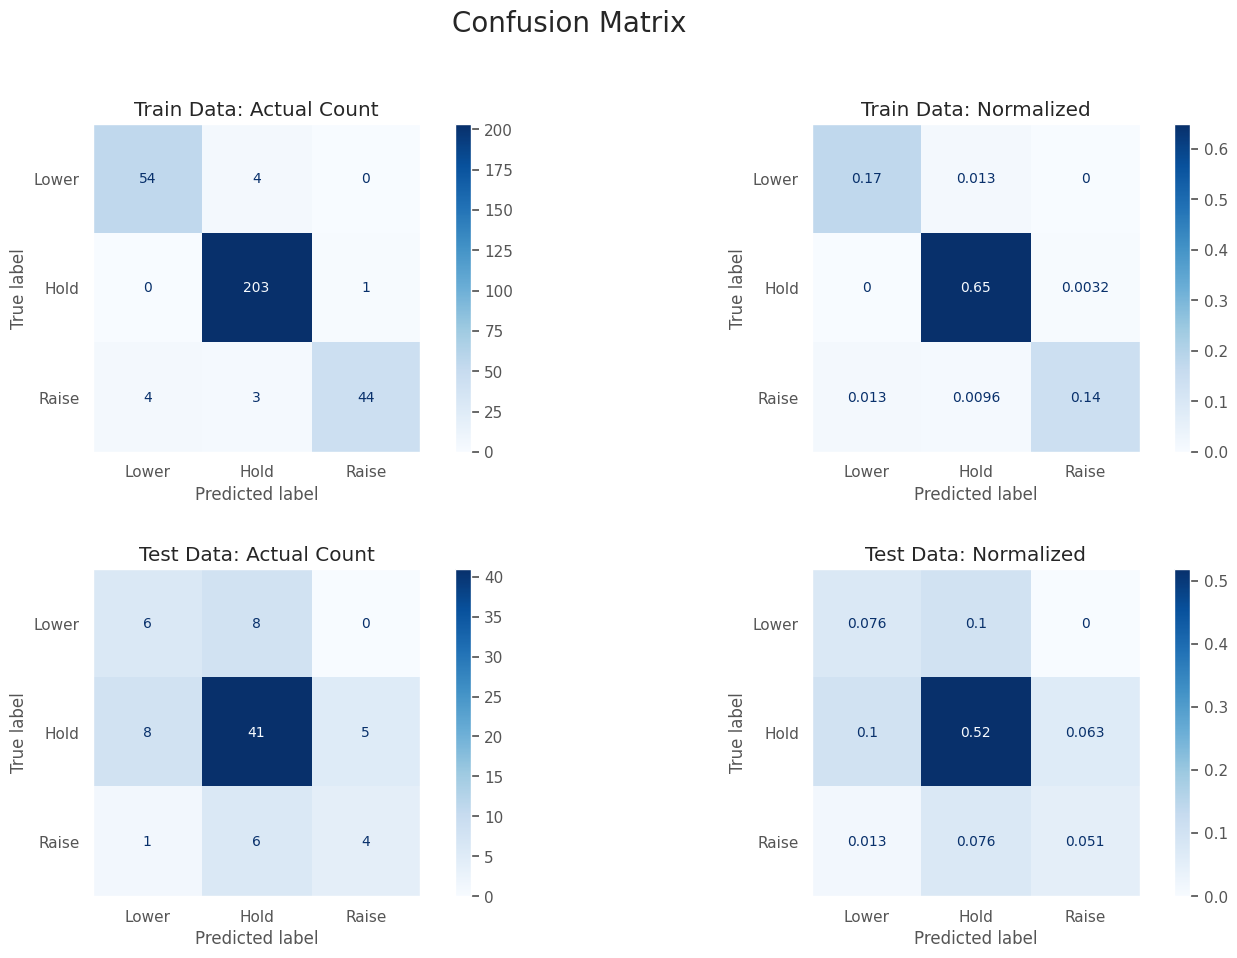

In [ ]:
# Random Forest
rf_clf = RandomForestClassifier()

# Perform Grid Search
param_grid = {'n_estimators': np.linspace(1, 60, 10, dtype=int),
              'min_samples_split': [3, 10],
              'min_samples_leaf': [3],
              'max_features': [7],
              'max_depth': [None],
              'criterion': ['gini'],
              'bootstrap': [False]}

rf_model = train_grid_search(rf_clf, param_grid, scoring, refit, cv=kfold, verbose=1, plot=True)
rf_best = rf_model.best_estimator_

## 04.7 BERT Model Training


In [ ]:
# Set logger
logger = logging.getLogger('mylogger')
logger.setLevel(logging.INFO)

timestamp = time.strftime("%Y.%m.%d_%H.%M.%S", time.localtime())
formatter = logging.Formatter('[%(asctime)s][%(levelname)s] ## %(message)s')

fh = logging.FileHandler('log_model.txt')
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)
logger.addHandler(fh)

ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
ch.setFormatter(formatter)
logger.addHandler(ch)

In [ ]:
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)
#from transformers import *
from transformers import BertTokenizer, BertForSequenceClassification, BertModel
#import torch


In [ ]:
class InputFeature(object):
    """ A single training/test data class """
    def __init__(self, id, input_ids, masks, segments, meta, label=None):
        self.id = id
        self.features = {
            'input_ids': input_ids,
            'input_mask': masks,
            'segment_ids': segments,
            'meta': meta
        }
        self.label = label

In [ ]:
#Makes the text into lower case and creates a list of unique words in the text
sentences = re.sub("[.,!?-]", '', text.lower()).split('\n')
orig_tokens = list(set(" ".join(sentences).split()))
print(orig_tokens)

[]


In [ ]:
#Add text and special tokens to dictionary for training (the special tokens implement the bidirectionality and continuity of the model)
word_dict = {'[PAD]': 0, '[CLS]': 1, '[SEP]': 2, '[MASK]': 3}
for i, w in enumerate(orig_tokens):
   word_dict[w] = i + 4
   number_dict = {i: w for i, w in enumerate(word_dict)}
   vocab_size = len(word_dict)
print(word_dict)

{'[PAD]': 0, '[CLS]': 1, '[SEP]': 2, '[MASK]': 3}


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def bert_encoder(text, max_len=200):
    """ Return embedded text vector as a list in max_len with a mask list"""
    text_token = tokenizer.tokenize(text)
    text_token = text_token[:max_len-2]
    text_token = ["[CLS]"] + text_token + ["[SEP]"]
    text_ids = tokenizer.convert_tokens_to_ids(text_token)
    text_ids += [0] * (max_len - len(text_token))
    pad_masks = [1] * len(text_token) + [0] * (max_len - len(text_token))
    segment_ids = [0] * len(text_token) + [0] * (max_len - len(text_token))

    return text_ids, pad_masks, segment_ids

In [ ]:
# Prepare training data
train_set = []
max_seq_length = 200
meta_size = 10

for index, row in tqdm(split_train_df.iterrows(), total=split_train_df.shape[0]):
    input_ids, masks, segments = bert_encoder(row['text'], max_seq_length)
    train_set.append(InputFeature(row.index, input_ids, masks, segments, row[nontext_columns + ['tone']], int(row['target'])))

train_labels = split_train_df['target'].astype(int).values

# numpy array to split train and valid within Fold later
train_valid_input_ids = np.array([data.features['input_ids'] for data in train_set])
train_valid_input_masks = np.array([data.features['input_mask'] for data in train_set])
train_valid_segment_ids =np.array([data.features['segment_ids'] for data in train_set])
train_valid_meta =np.array([data.features['meta'] for data in train_set], dtype=np.float64)
train_valid_labels = np.array([data.label for data in train_set])

oof_train = np.zeros((len(split_train_df), 3), dtype=np.float32)

  0%|          | 0/392 [00:00<?, ?it/s]

In [ ]:
print(train_valid_meta[0])
print(train_valid_meta[1])

[ 1.00000000e+00  4.56198515e-01  3.88000000e+01 -1.69000000e+02
  2.14771392e+00 -1.66666667e-01 -2.04832086e-02 -1.54852748e+01
  9.90825185e-03  0.00000000e+00]
[ 0.00000000e+00 -3.82299274e-01  3.94000000e+01 -2.28000000e+02
  2.14771392e+00 -2.00000000e-01 -2.04832086e-02 -9.53749560e+00
  9.90825185e-03  0.00000000e+00]


In [ ]:
class BertTextClassifier(nn.Module):
    def __init__(self, hidden_size, dense_size, meta_size, output_size, dropout=0.1):
        """
        Initialize the model
        """
        super().__init__()
        self.output_size = output_size
        self.dropout = dropout

        self.bert = BertModel.from_pretrained('bert-base-uncased',
                                        output_hidden_states=True,
                                        output_attentions=True)
        for param in self.bert.parameters():
            param.requires_grad = True
        self.weights = nn.Parameter(torch.rand(13, 1))
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_size, dense_size)
        self.fc2 = nn.Linear(dense_size + meta_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_ids, nn_input_meta):
        """
        Perform a forward pass of the model on nn_input
        """

        all_hidden_states, all_attentions = self.bert(input_ids)[-2:]
        batch_size = input_ids.shape[0]
        ht_cls = torch.cat(all_hidden_states)[:, :1, :].view(13, batch_size, 1, 768)
        atten = torch.sum(ht_cls * self.weights.view(13, 1, 1, 1), dim=[1, 3])
        atten = F.softmax(atten.view(-1), dim=0)
        feature = torch.sum(ht_cls * atten.view(13, 1, 1, 1), dim=[0, 2])
        # Dense layer
        dense_out = self.fc1(self.dropout(feature))
        # Concatinate the dense output and meta inputs
        concat_layer = torch.cat((dense_out, nn_input_meta.float()), 1)
        # print(len(dense_out[0]))
        # print(len(nn_input_meta[0]))
        # print(len(concat_layer[0]))
        # print("dense_out: \n", dense_out)
        # print("nn_input_meta: \n", nn_input_meta)
        # print("concat_layer: \n", concat_layer)
        out = self.fc2(concat_layer)
        #logps = self.softmax(out)

        return out

In [ ]:
# Check how BertTokenizer works
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

input_ids = torch.tensor(tokenizer.encode("Hello, my dog is cute", add_special_tokens=True)).unsqueeze(0)  # Batch size 1
outputs = model(input_ids)

print(input_ids)
print(outputs) # The last hidden-state is the first element of the output tuple


tensor([[  101,  7592,  1010,  2026,  3899,  2003, 10140,   102]])
BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-0.1144,  0.1937,  0.1250,  ..., -0.3827,  0.2107,  0.5407],
         [ 0.5308,  0.3207,  0.3665,  ..., -0.0036,  0.7579,  0.0388],
         [-0.4877,  0.8849,  0.4256,  ..., -0.6976,  0.4458,  0.1231],
         ...,
         [-0.7003, -0.1815,  0.3297,  ..., -0.4838,  0.0680,  0.8901],
         [-1.0355, -0.2567, -0.0317,  ...,  0.3197,  0.3999,  0.1795],
         [ 0.6080,  0.2610, -0.3131,  ...,  0.0311, -0.6283, -0.1994]]],
       grad_fn=<NativeLayerNormBackward0>), pooler_output=tensor([[-7.1946e-01, -2.1445e-01, -2.9576e-01,  3.6603e-01,  2.7968e-01,
          2.2184e-02,  5.7299e-01,  6.2331e-02,  5.9585e-02, -9.9965e-01,
          5.0145e-02,  4.4756e-01,  9.7612e-01,  3.3989e-02,  8.4494e-01,
         -3.6905e-01,  9.8648e-02, -3.7169e-01,  1.7371e-01,  1.1515e-01,
          4.4133e-01,  9.9525e-01,  3.7221e-01,  8.2881e-02,  2.1402e-01,


In [ ]:
# Test Tokenizer - Own Implementation
bert_model = BertTextClassifier(768, 128, meta_size, 3, dropout=0.1)

text_ids, pad_masks, segment_ids = bert_encoder("Hello, my dog is cute")
print('text_ids: \n', text_ids)
print('text_ids (torch.tensor): \n', torch.tensor(text_ids))
text_ids = torch.tensor(text_ids).unsqueeze(0)
print('text_ids (unsqueezed): \n', text_ids)
#print('pad_masks: ',pad_masks)
#print('segment_ids: ',segment_ids)
x_meta = torch.tensor([1,2,3,4,5,6,7,8,9,10]).unsqueeze(0)
outputs = bert_model(text_ids, x_meta)
print(len(outputs))
print('outputs: \n',outputs)
print('outputs(detached): \n', outputs.detach())

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


text_ids: 
 [101, 7592, 1010, 2026, 3899, 2003, 10140, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
text_ids (torch.tensor): 
 tensor([  101,  7592,  1010,  2026,  3899,  2003, 10140,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,    

In [ ]:
# Hyperparameters
learning_rate = 1e-5
num_epochs = 3
batch_size = 32
patience =2
file_name = 'model'
use_skf = True
bert_hidden_size = 768
bert_dense_size =128

In [ ]:
!mkdir '/content/drive/MyDrive/DSCI 521 Assignments and Project/Project/models/'

mkdir: cannot create directory ‘/content/drive/MyDrive/DSCI 521 Assignments and Project/Project/models/’: File exists


In [ ]:
output_dir = '/content/drive/MyDrive/DSCI 521 Assignments and Project/Project/models/'

In [ ]:
def train_bert(fold, train_indices, valid_indices):

    # Number of folds to iterrate
    # if fold == 3:
    #     break

    logger.info('================     fold {}        ==============='.format(fold))

    # Train Data in Tensor
    train_input_ids = torch.tensor(train_valid_input_ids[train_indices], dtype=torch.long)
    train_input_mask = torch.tensor(train_valid_input_masks[train_indices], dtype=torch.long)
    train_segment_ids = torch.tensor(train_valid_segment_ids[train_indices], dtype=torch.long)
    train_label = torch.tensor(train_valid_labels[train_indices], dtype=torch.long)
    train_meta = torch.tensor(train_valid_meta[train_indices], dtype=torch.long)

    # Validation Data in Tensor
    valid_input_ids = torch.tensor(train_valid_input_ids[valid_indices], dtype=torch.long)
    valid_input_mask = torch.tensor(train_valid_input_masks[valid_indices], dtype=torch.long)
    valid_segment_ids = torch.tensor(train_valid_segment_ids[valid_indices], dtype=torch.long)
    valid_label = torch.tensor(train_valid_labels[valid_indices], dtype=torch.long)
    valid_meta = torch.tensor(train_valid_meta[valid_indices], dtype=torch.long)

    # Load data into TensorDataset
    train = torch.utils.data.TensorDataset(train_input_ids, train_input_mask, train_segment_ids, train_meta, train_label)
    valid = torch.utils.data.TensorDataset(valid_input_ids, valid_input_mask, valid_segment_ids, valid_meta, valid_label)

    # Use DataLoader to load data from Dataset in batches
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

    # Set Model
#     bert_model = BertForSequenceClassification.from_pretrained(
#         "bert-base-uncased",
#         num_labels = 3,
#         output_attentions = False,
#         output_hidden_states = False
#     )

    bert_model = BertTextClassifier(bert_hidden_size, bert_dense_size, meta_size, 3, dropout=0.1)

    # Move model to GUP/CPU device
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    bert_model = bert_model.to(device)

    # Loss Function - use Cross Entropy as binary classification
    loss_fn = torch.nn.CrossEntropyLoss()

    # Optimizer - Adam with parameter groups
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}]

    optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=1e-6)

    # Set Train Mode
    bert_model.train()

    # Initialize
    best_f1 = 0.
    valid_best = np.zeros((valid_label.size(0), 2))
    early_stop = 0
    train_losses = []
    valid_losses = []

    for epoch in range(num_epochs):
        logger.info('================     epoch {}        ==============='.format(epoch+1))
        train_loss = 0.
        for i, batch in tqdm(enumerate(train_loader), total=len(train_loader), desc='Training'):
            # Move batch data to device
            batch = tuple(t.to(device) for t in batch)
            # Bert input features and labels from batch
            x_ids, x_mask, x_sids, x_meta, y_truth = batch

            # Feedforward prediction
            y_pred = bert_model(x_ids, x_meta)

            # Calculate Loss
            loss = loss_fn(y_pred, y_truth)

            # Reset gradient
            optimizer.zero_grad()
            # Backward Propagation
            loss.backward()
            # Update Weights
            optimizer.step()
            # Training Loss
            train_loss += loss.item() / len(train_loader)

            logger.debug('train batch: %d, train_loss: %8f\n' % (i, train_loss))

        train_losses.append(train_loss)
        # Move to Evaluation Mode
        model.eval()

        # Initialize
        val_loss = 0.
        valid_preds_fold = np.zeros((valid_label.size(0), 3))

        with torch.no_grad():
            for i, batch in tqdm(enumerate(valid_loader), total=len(valid_loader), desc='Validation'):
                batch = tuple(t.to(device) for t in batch)
                x_ids, x_mask, x_sids, x_meta, y_truth = batch
                y_pred = bert_model(x_ids, x_meta).detach()
                loss = loss_fn(y_pred, y_truth)
                val_loss += loss.item() / len(valid_loader)
                valid_preds_fold[i * batch_size:(i + 1) * batch_size] = F.softmax(y_pred, dim=1).cpu().numpy()

                logger.debug('validation batch: {}, val_loss: {}, valid_preds_fold: {}'.format(i, val_loss, valid_preds_fold[i * batch_size:(i + 1) * batch_size]))
            valid_losses.append(val_loss)

        # Calculate metrics
        acc, f1 = metric(train_valid_labels[valid_indices], np.argmax(valid_preds_fold, axis=1))

        # If improving, save the model. If not, count up for early stopping
        if best_f1 < f1:
            early_stop = 0
            best_f1 = f1
            valid_best = valid_preds_fold
            torch.save(bert_model.state_dict(), output_dir + 'model_fold_{}.dict'.format(fold))
        else:
            early_stop += 1

        logger.info(
            'epoch: %d, train loss: %.8f, valid loss: %.8f, acc: %.8f, f1: %.8f, best_f1: %.8f\n' %
            (epoch, train_loss, val_loss, acc, f1, best_f1))

        if device == 'cuda:0':
            torch.cuda.empty_cache()

        # Early stop if it reaches patience number
        if early_stop >= patience:
            break

        model.train()

    # Once all epochs are done, take the best model of the fold
    valid_preds_fold = np.zeros((valid_label.size(0), 3))

    # Draw training/validation losses
    sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (15,6)
    plt.plot(train_losses, 'b-o')
    plt.plot(valid_losses, 'b-o')

    plt.title("Training/Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.show()

    # Load the best model
    bert_model.load_state_dict(torch.load(output_dir + 'model_fold_{}.dict'.format(fold)))
    # Set Evaluation Mode
    bert_model.eval()

    # Prediction on the validation set
    with torch.no_grad():
        for i, batch in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            batch = tuple(t.to(device) for t in batch)
            x_ids, x_mask, x_sids, x_meta, y_truth = batch
            y_pred = bert_model(x_ids, x_meta).detach()
            valid_preds_fold[i * batch_size:(i + 1) * batch_size] = F.softmax(y_pred, dim=1).cpu().numpy()


    # Check the metrics for the validation set
    valid_best = valid_preds_fold
    oof_train[valid_indices] = valid_best
    acc, f1 = metric(train_valid_labels[valid_indices], np.argmax(valid_best, axis=1))
    logger.info('epoch: best, acc: %.8f, f1: %.8f, best_f1: %.8f\n' % (acc, f1, best_f1))

    class_names = ['Lower', 'Hold', 'Raise']
    titles_options = [("Confusion matrix, without normalization", None), ("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
        disp = skplt.metrics.plot_confusion_matrix(train_valid_labels[valid_indices], np.argmax(valid_best, axis=1), normalize=normalize, title=title)
    plt.show()

[2023-09-03 20:13:07,645][INFO] ## ================     fold 0        ===============
[2023-09-03 20:13:07,645][INFO] ## ================     fold 0        ===============
INFO:mylogger:================     fold 0        ===============
[2023-09-03 20:13:17,287][INFO] ## ================     epoch 1        ===============
[2023-09-03 20:13:17,287][INFO] ## ================     epoch 1        ===============
INFO:mylogger:================     epoch 1        ===============


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

[2023-09-03 20:13:37,363][INFO] ## epoch: 0, train loss: 5.25414896, valid loss: 23.82294718, acc: 0.53164557, f1: 0.28785607, best_f1: 0.28785607

[2023-09-03 20:13:37,363][INFO] ## epoch: 0, train loss: 5.25414896, valid loss: 23.82294718, acc: 0.53164557, f1: 0.28785607, best_f1: 0.28785607

INFO:mylogger:epoch: 0, train loss: 5.25414896, valid loss: 23.82294718, acc: 0.53164557, f1: 0.28785607, best_f1: 0.28785607

[2023-09-03 20:13:37,495][INFO] ## ================     epoch 2        ===============
[2023-09-03 20:13:37,495][INFO] ## ================     epoch 2        ===============
INFO:mylogger:================     epoch 2        ===============


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

[2023-09-03 20:13:47,332][INFO] ## epoch: 1, train loss: 5.23278096, valid loss: 23.81088702, acc: 0.53164557, f1: 0.28785607, best_f1: 0.28785607

[2023-09-03 20:13:47,332][INFO] ## epoch: 1, train loss: 5.23278096, valid loss: 23.81088702, acc: 0.53164557, f1: 0.28785607, best_f1: 0.28785607

INFO:mylogger:epoch: 1, train loss: 5.23278096, valid loss: 23.81088702, acc: 0.53164557, f1: 0.28785607, best_f1: 0.28785607

[2023-09-03 20:13:47,451][INFO] ## ================     epoch 3        ===============
[2023-09-03 20:13:47,451][INFO] ## ================     epoch 3        ===============
INFO:mylogger:================     epoch 3        ===============


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

[2023-09-03 20:13:57,340][INFO] ## epoch: 2, train loss: 5.20786464, valid loss: 23.82257175, acc: 0.53164557, f1: 0.28785607, best_f1: 0.28785607

[2023-09-03 20:13:57,340][INFO] ## epoch: 2, train loss: 5.20786464, valid loss: 23.82257175, acc: 0.53164557, f1: 0.28785607, best_f1: 0.28785607

INFO:mylogger:epoch: 2, train loss: 5.20786464, valid loss: 23.82257175, acc: 0.53164557, f1: 0.28785607, best_f1: 0.28785607



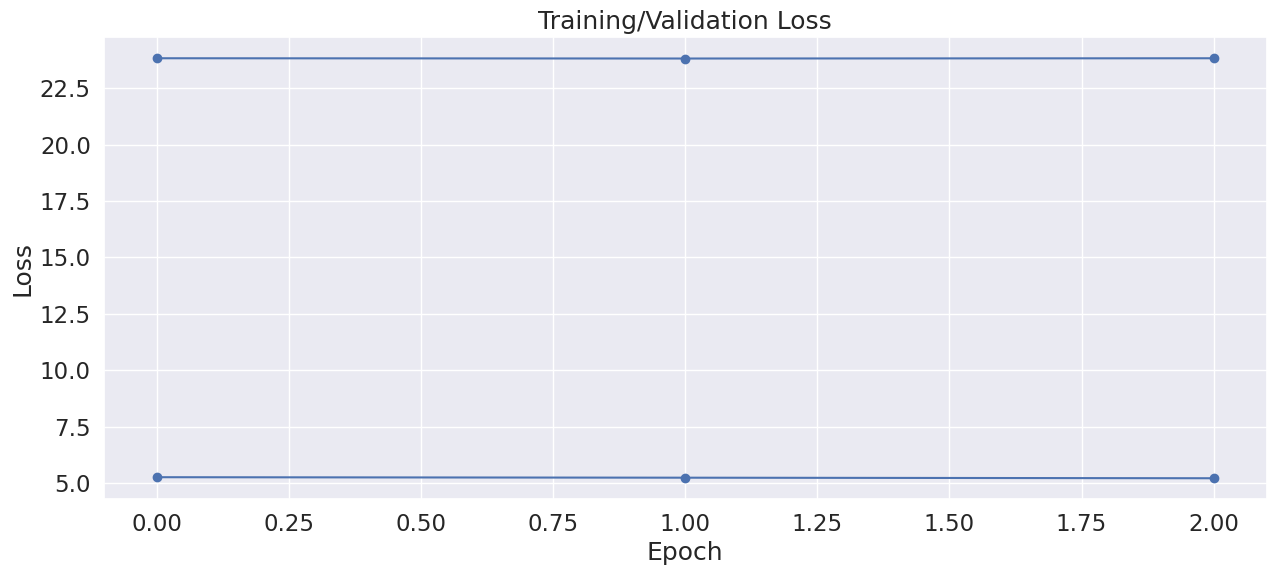

  0%|          | 0/3 [00:00<?, ?it/s]

[2023-09-03 20:13:59,364][INFO] ## epoch: best, acc: 0.53164557, f1: 0.28785607, best_f1: 0.28785607

[2023-09-03 20:13:59,364][INFO] ## epoch: best, acc: 0.53164557, f1: 0.28785607, best_f1: 0.28785607

INFO:mylogger:epoch: best, acc: 0.53164557, f1: 0.28785607, best_f1: 0.28785607



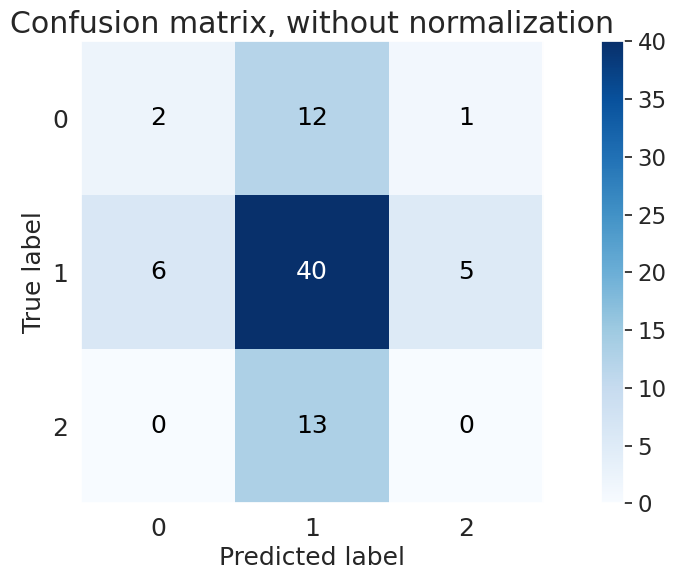

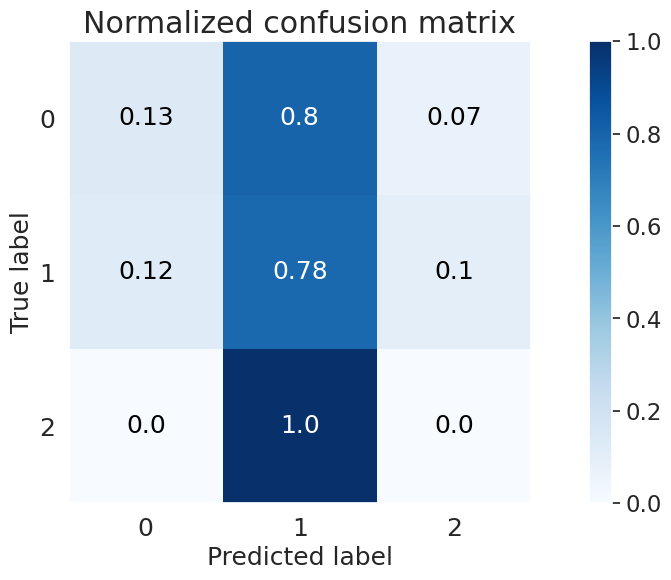

[2023-09-03 20:14:00,008][INFO] ## ================     fold 1        ===============
[2023-09-03 20:14:00,008][INFO] ## ================     fold 1        ===============
INFO:mylogger:================     fold 1        ===============
[2023-09-03 20:14:01,961][INFO] ## ================     epoch 1        ===============
[2023-09-03 20:14:01,961][INFO] ## ================     epoch 1        ===============
INFO:mylogger:================     epoch 1        ===============


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

[2023-09-03 20:14:22,805][INFO] ## epoch: 0, train loss: 13.53171077, valid loss: 8.81369543, acc: 0.60759494, f1: 0.33126722, best_f1: 0.33126722

[2023-09-03 20:14:22,805][INFO] ## epoch: 0, train loss: 13.53171077, valid loss: 8.81369543, acc: 0.60759494, f1: 0.33126722, best_f1: 0.33126722

INFO:mylogger:epoch: 0, train loss: 13.53171077, valid loss: 8.81369543, acc: 0.60759494, f1: 0.33126722, best_f1: 0.33126722

[2023-09-03 20:14:22,914][INFO] ## ================     epoch 2        ===============
[2023-09-03 20:14:22,914][INFO] ## ================     epoch 2        ===============
INFO:mylogger:================     epoch 2        ===============


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

[2023-09-03 20:14:33,151][INFO] ## epoch: 1, train loss: 13.44175448, valid loss: 8.81039540, acc: 0.60759494, f1: 0.33126722, best_f1: 0.33126722

[2023-09-03 20:14:33,151][INFO] ## epoch: 1, train loss: 13.44175448, valid loss: 8.81039540, acc: 0.60759494, f1: 0.33126722, best_f1: 0.33126722

INFO:mylogger:epoch: 1, train loss: 13.44175448, valid loss: 8.81039540, acc: 0.60759494, f1: 0.33126722, best_f1: 0.33126722

[2023-09-03 20:14:33,278][INFO] ## ================     epoch 3        ===============
[2023-09-03 20:14:33,278][INFO] ## ================     epoch 3        ===============
INFO:mylogger:================     epoch 3        ===============


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

[2023-09-03 20:14:43,667][INFO] ## epoch: 2, train loss: 13.42510710, valid loss: 8.82390451, acc: 0.60759494, f1: 0.33126722, best_f1: 0.33126722

[2023-09-03 20:14:43,667][INFO] ## epoch: 2, train loss: 13.42510710, valid loss: 8.82390451, acc: 0.60759494, f1: 0.33126722, best_f1: 0.33126722

INFO:mylogger:epoch: 2, train loss: 13.42510710, valid loss: 8.82390451, acc: 0.60759494, f1: 0.33126722, best_f1: 0.33126722



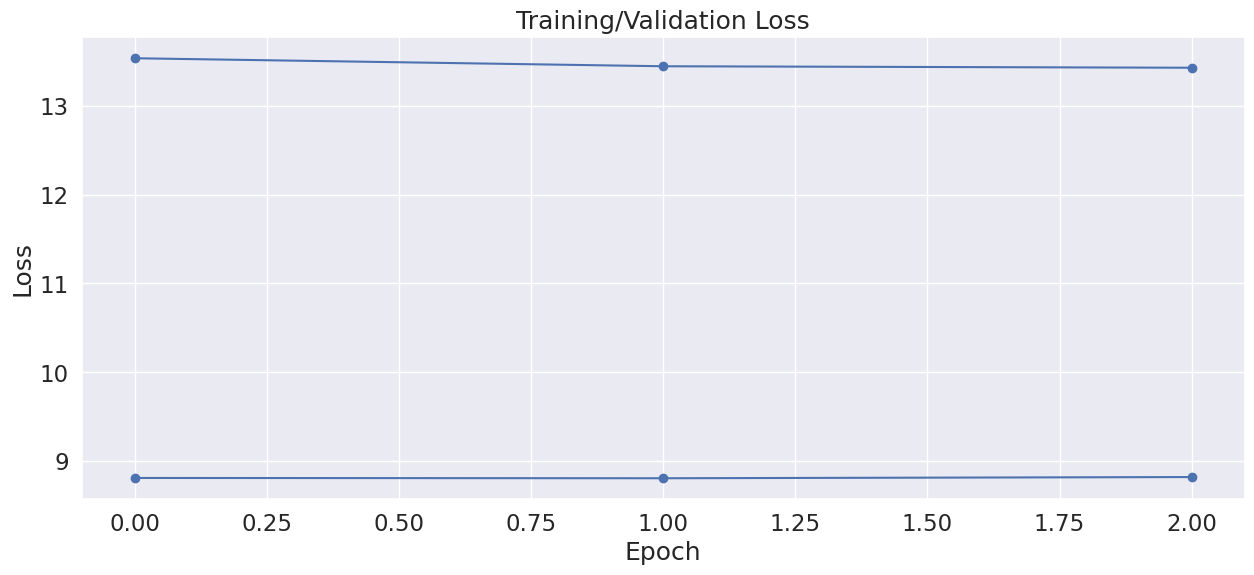

  0%|          | 0/3 [00:00<?, ?it/s]

[2023-09-03 20:14:45,778][INFO] ## epoch: best, acc: 0.60759494, f1: 0.33126722, best_f1: 0.33126722

[2023-09-03 20:14:45,778][INFO] ## epoch: best, acc: 0.60759494, f1: 0.33126722, best_f1: 0.33126722

INFO:mylogger:epoch: best, acc: 0.60759494, f1: 0.33126722, best_f1: 0.33126722



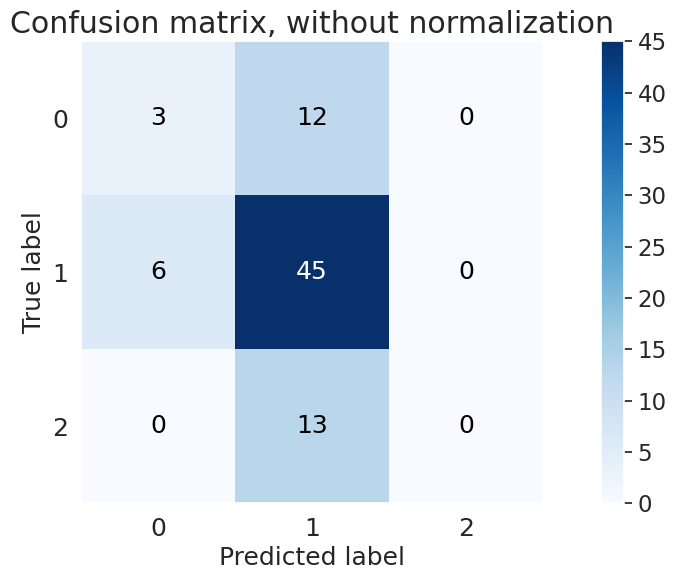

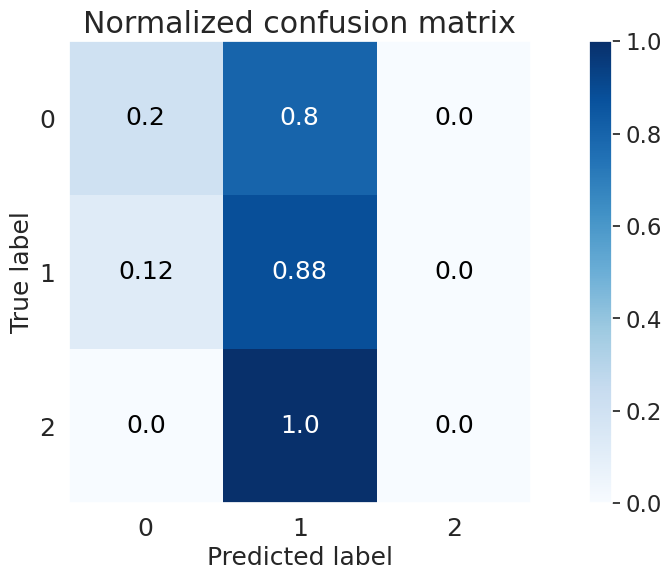

[2023-09-03 20:14:46,411][INFO] ## ================     fold 2        ===============
[2023-09-03 20:14:46,411][INFO] ## ================     fold 2        ===============
INFO:mylogger:================     fold 2        ===============
[2023-09-03 20:14:48,169][INFO] ## ================     epoch 1        ===============
[2023-09-03 20:14:48,169][INFO] ## ================     epoch 1        ===============
INFO:mylogger:================     epoch 1        ===============


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

[2023-09-03 20:15:07,764][INFO] ## epoch: 0, train loss: 15.78683500, valid loss: 11.28558636, acc: 0.25641026, f1: 0.29057471, best_f1: 0.29057471

[2023-09-03 20:15:07,764][INFO] ## epoch: 0, train loss: 15.78683500, valid loss: 11.28558636, acc: 0.25641026, f1: 0.29057471, best_f1: 0.29057471

INFO:mylogger:epoch: 0, train loss: 15.78683500, valid loss: 11.28558636, acc: 0.25641026, f1: 0.29057471, best_f1: 0.29057471

[2023-09-03 20:15:07,872][INFO] ## ================     epoch 2        ===============
[2023-09-03 20:15:07,872][INFO] ## ================     epoch 2        ===============
INFO:mylogger:================     epoch 2        ===============


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

[2023-09-03 20:15:18,126][INFO] ## epoch: 1, train loss: 15.99286280, valid loss: 11.29817867, acc: 0.25641026, f1: 0.28163205, best_f1: 0.29057471

[2023-09-03 20:15:18,126][INFO] ## epoch: 1, train loss: 15.99286280, valid loss: 11.29817867, acc: 0.25641026, f1: 0.28163205, best_f1: 0.29057471

INFO:mylogger:epoch: 1, train loss: 15.99286280, valid loss: 11.29817867, acc: 0.25641026, f1: 0.28163205, best_f1: 0.29057471

[2023-09-03 20:15:18,259][INFO] ## ================     epoch 3        ===============
[2023-09-03 20:15:18,259][INFO] ## ================     epoch 3        ===============
INFO:mylogger:================     epoch 3        ===============


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

[2023-09-03 20:15:28,558][INFO] ## epoch: 2, train loss: 15.80769224, valid loss: 11.29086844, acc: 0.25641026, f1: 0.29057471, best_f1: 0.29057471

[2023-09-03 20:15:28,558][INFO] ## epoch: 2, train loss: 15.80769224, valid loss: 11.29086844, acc: 0.25641026, f1: 0.29057471, best_f1: 0.29057471

INFO:mylogger:epoch: 2, train loss: 15.80769224, valid loss: 11.29086844, acc: 0.25641026, f1: 0.29057471, best_f1: 0.29057471



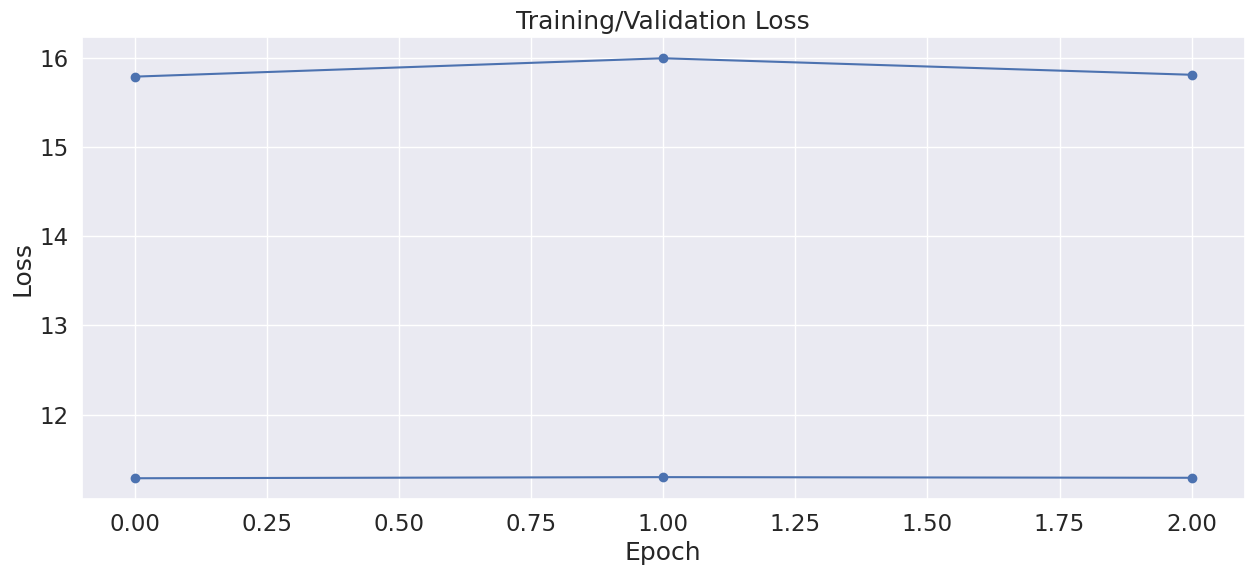

  0%|          | 0/3 [00:00<?, ?it/s]

[2023-09-03 20:15:30,513][INFO] ## epoch: best, acc: 0.25641026, f1: 0.28588589, best_f1: 0.29057471

[2023-09-03 20:15:30,513][INFO] ## epoch: best, acc: 0.25641026, f1: 0.28588589, best_f1: 0.29057471

INFO:mylogger:epoch: best, acc: 0.25641026, f1: 0.28588589, best_f1: 0.29057471



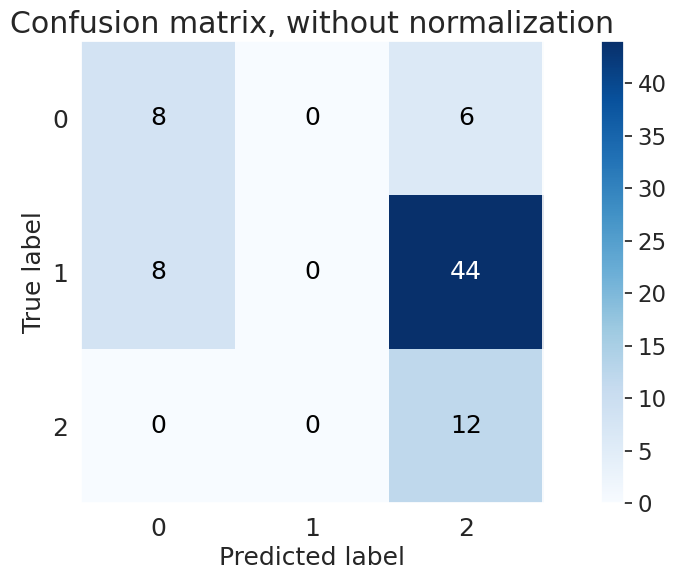

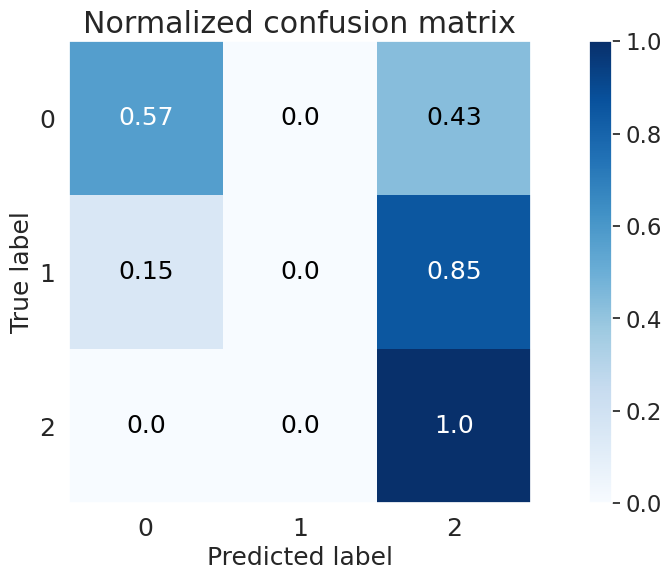

[2023-09-03 20:15:31,143][INFO] ## ================     fold 3        ===============
[2023-09-03 20:15:31,143][INFO] ## ================     fold 3        ===============
INFO:mylogger:================     fold 3        ===============
[2023-09-03 20:15:32,258][INFO] ## ================     epoch 1        ===============
[2023-09-03 20:15:32,258][INFO] ## ================     epoch 1        ===============
INFO:mylogger:================     epoch 1        ===============


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

[2023-09-03 20:15:55,057][INFO] ## epoch: 0, train loss: 18.07084255, valid loss: 27.14413897, acc: 0.21794872, f1: 0.18161915, best_f1: 0.18161915

[2023-09-03 20:15:55,057][INFO] ## epoch: 0, train loss: 18.07084255, valid loss: 27.14413897, acc: 0.21794872, f1: 0.18161915, best_f1: 0.18161915

INFO:mylogger:epoch: 0, train loss: 18.07084255, valid loss: 27.14413897, acc: 0.21794872, f1: 0.18161915, best_f1: 0.18161915

[2023-09-03 20:15:55,171][INFO] ## ================     epoch 2        ===============
[2023-09-03 20:15:55,171][INFO] ## ================     epoch 2        ===============
INFO:mylogger:================     epoch 2        ===============


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

[2023-09-03 20:16:11,918][INFO] ## epoch: 1, train loss: 18.19336119, valid loss: 27.14089775, acc: 0.23076923, f1: 0.19350636, best_f1: 0.19350636

[2023-09-03 20:16:11,918][INFO] ## epoch: 1, train loss: 18.19336119, valid loss: 27.14089775, acc: 0.23076923, f1: 0.19350636, best_f1: 0.19350636

INFO:mylogger:epoch: 1, train loss: 18.19336119, valid loss: 27.14089775, acc: 0.23076923, f1: 0.19350636, best_f1: 0.19350636

[2023-09-03 20:16:12,045][INFO] ## ================     epoch 3        ===============
[2023-09-03 20:16:12,045][INFO] ## ================     epoch 3        ===============
INFO:mylogger:================     epoch 3        ===============


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

[2023-09-03 20:16:23,062][INFO] ## epoch: 2, train loss: 18.17959881, valid loss: 27.12604745, acc: 0.23076923, f1: 0.19350636, best_f1: 0.19350636

[2023-09-03 20:16:23,062][INFO] ## epoch: 2, train loss: 18.17959881, valid loss: 27.12604745, acc: 0.23076923, f1: 0.19350636, best_f1: 0.19350636

INFO:mylogger:epoch: 2, train loss: 18.17959881, valid loss: 27.12604745, acc: 0.23076923, f1: 0.19350636, best_f1: 0.19350636



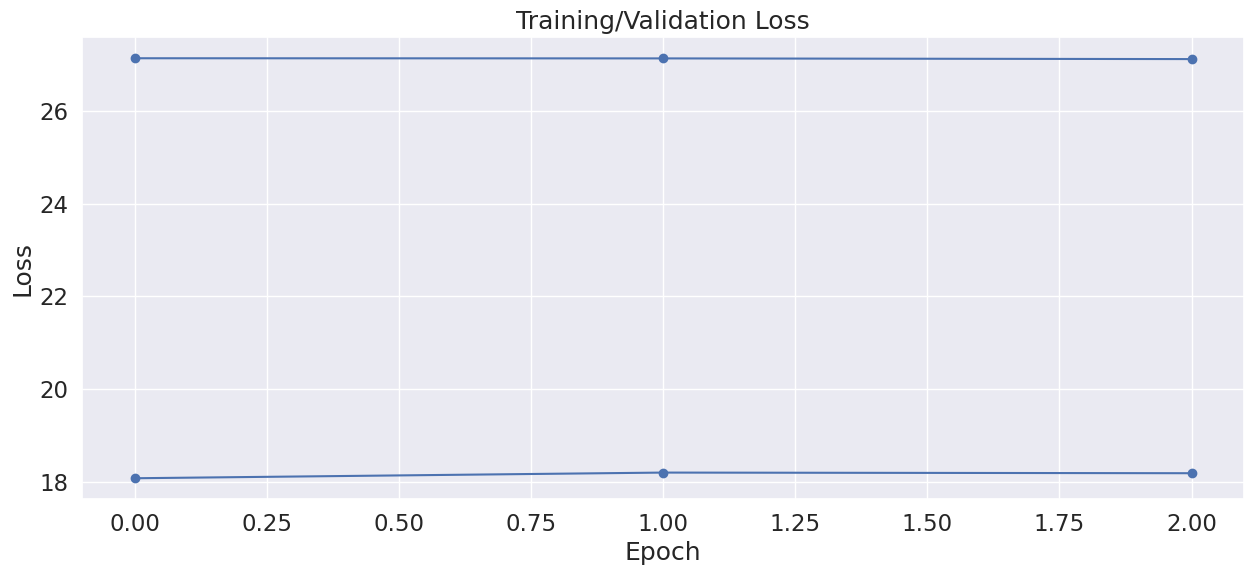

  0%|          | 0/3 [00:00<?, ?it/s]

[2023-09-03 20:16:26,182][INFO] ## epoch: best, acc: 0.23076923, f1: 0.19350636, best_f1: 0.19350636

[2023-09-03 20:16:26,182][INFO] ## epoch: best, acc: 0.23076923, f1: 0.19350636, best_f1: 0.19350636

INFO:mylogger:epoch: best, acc: 0.23076923, f1: 0.19350636, best_f1: 0.19350636



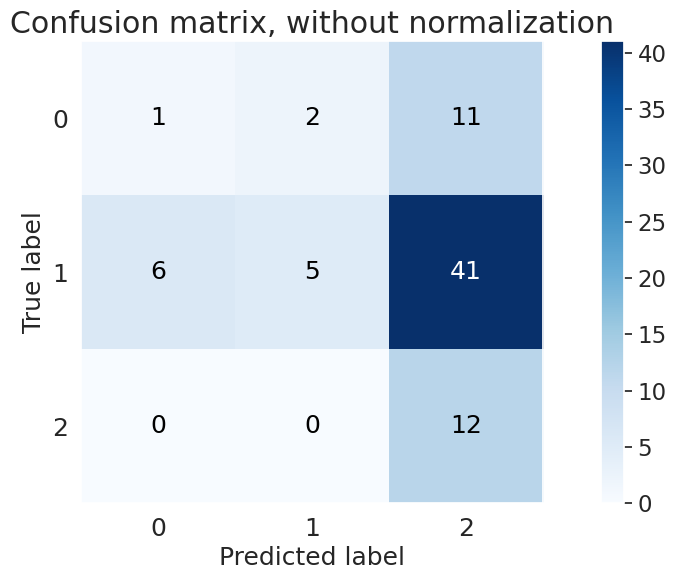

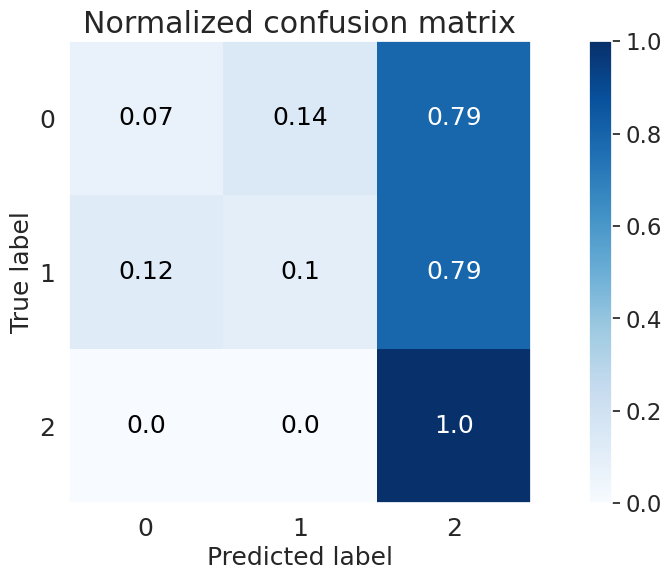

[2023-09-03 20:16:26,989][INFO] ## ================     fold 4        ===============
[2023-09-03 20:16:26,989][INFO] ## ================     fold 4        ===============
INFO:mylogger:================     fold 4        ===============
[2023-09-03 20:16:28,369][INFO] ## ================     epoch 1        ===============
[2023-09-03 20:16:28,369][INFO] ## ================     epoch 1        ===============
INFO:mylogger:================     epoch 1        ===============


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

[2023-09-03 20:16:51,974][INFO] ## epoch: 0, train loss: 12.28652196, valid loss: 11.79122225, acc: 0.12820513, f1: 0.10832209, best_f1: 0.10832209

[2023-09-03 20:16:51,974][INFO] ## epoch: 0, train loss: 12.28652196, valid loss: 11.79122225, acc: 0.12820513, f1: 0.10832209, best_f1: 0.10832209

INFO:mylogger:epoch: 0, train loss: 12.28652196, valid loss: 11.79122225, acc: 0.12820513, f1: 0.10832209, best_f1: 0.10832209

[2023-09-03 20:16:52,079][INFO] ## ================     epoch 2        ===============
[2023-09-03 20:16:52,079][INFO] ## ================     epoch 2        ===============
INFO:mylogger:================     epoch 2        ===============


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

[2023-09-03 20:17:02,896][INFO] ## epoch: 1, train loss: 12.28476272, valid loss: 11.81190825, acc: 0.12820513, f1: 0.10832209, best_f1: 0.10832209

[2023-09-03 20:17:02,896][INFO] ## epoch: 1, train loss: 12.28476272, valid loss: 11.81190825, acc: 0.12820513, f1: 0.10832209, best_f1: 0.10832209

INFO:mylogger:epoch: 1, train loss: 12.28476272, valid loss: 11.81190825, acc: 0.12820513, f1: 0.10832209, best_f1: 0.10832209

[2023-09-03 20:17:03,008][INFO] ## ================     epoch 3        ===============
[2023-09-03 20:17:03,008][INFO] ## ================     epoch 3        ===============
INFO:mylogger:================     epoch 3        ===============


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

[2023-09-03 20:17:13,841][INFO] ## epoch: 2, train loss: 12.27843633, valid loss: 11.83980926, acc: 0.12820513, f1: 0.10832209, best_f1: 0.10832209

[2023-09-03 20:17:13,841][INFO] ## epoch: 2, train loss: 12.27843633, valid loss: 11.83980926, acc: 0.12820513, f1: 0.10832209, best_f1: 0.10832209

INFO:mylogger:epoch: 2, train loss: 12.27843633, valid loss: 11.83980926, acc: 0.12820513, f1: 0.10832209, best_f1: 0.10832209



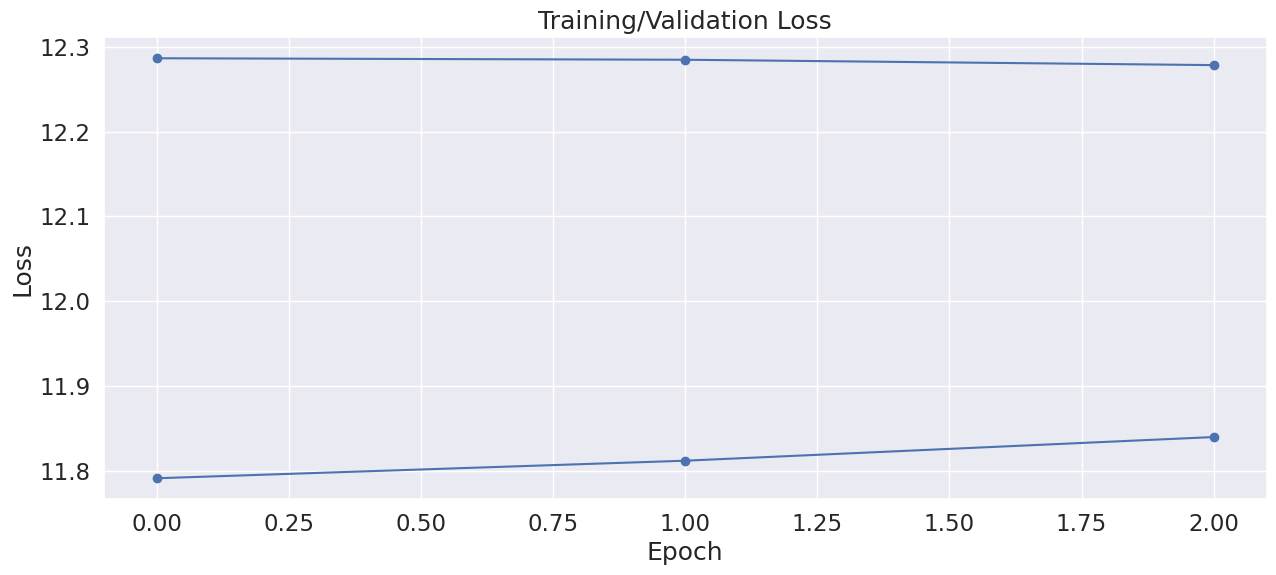

  0%|          | 0/3 [00:00<?, ?it/s]

[2023-09-03 20:17:16,287][INFO] ## epoch: best, acc: 0.12820513, f1: 0.10832209, best_f1: 0.10832209

[2023-09-03 20:17:16,287][INFO] ## epoch: best, acc: 0.12820513, f1: 0.10832209, best_f1: 0.10832209

INFO:mylogger:epoch: best, acc: 0.12820513, f1: 0.10832209, best_f1: 0.10832209



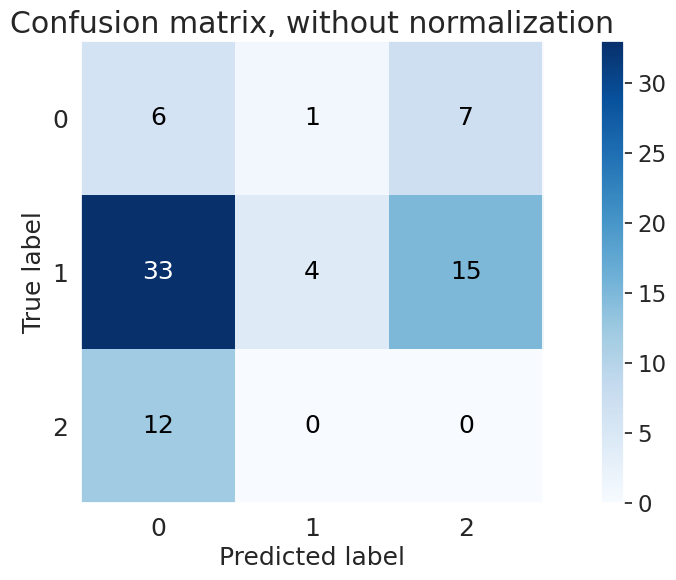

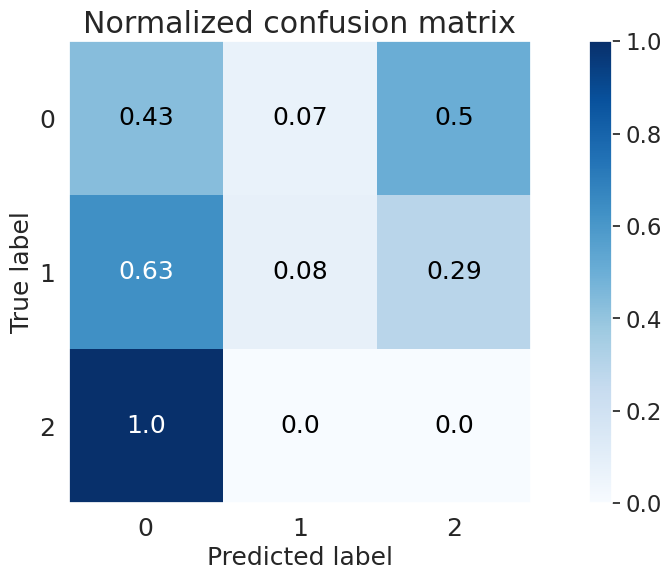

In [ ]:
if use_skf:
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for fold, (train_indices, valid_indices) in enumerate(skf.split(train_valid_labels, train_valid_labels)):
        train_bert(fold, train_indices, valid_indices)

else:
    train_ratio = 0.7
    train_indices = np.arange(0, int(len(train_valid_labels)*train_ratio))
    valid_indices = np.arange(int(len(train_valid_labels)*train_ratio), len(train_valid_labels))

    train_bert(0, train_indices, valid_indices)
    # print('train_indices', train_indices)
    # print('valid_indices', valid_indices)


In [ ]:
# This is only when all folds have been performed
logger.info(f1_score(train_labels, np.argmax(oof_train, axis=1), average='macro'))
split_train_df['pred_target'] = np.argmax(oof_train, axis=1)
split_train_df['pred_target_lower'] = oof_train[:,0]
split_train_df['pred_target_hold'] = oof_train[:,1]
split_train_df['pred_target_raise'] = oof_train[:,2]
split_train_df.head()

[2023-09-03 20:17:16,947][INFO] ## 0.31060617536418494
[2023-09-03 20:17:16,947][INFO] ## 0.31060617536418494
INFO:mylogger:0.31060617536418494


target  prev_decision  GDP_diff_prev  PMI_value  Employ_diff_prev  \
date                                                                            
1982-10-05       0              1       0.456199       38.8            -169.0   
1982-11-16       0              0      -0.382299       39.4            -228.0   
1982-12-21       1              0      -0.382299       39.2            -198.5   
1983-01-14       1              1      -0.382299       42.8             -68.0   
1983-01-21       1              1      -0.382299       42.8             -68.0   

            Rsales_diff_year  Unemp_diff_prev  Inertia_diff  Hsales_diff_year  \
date                                                                            
1982-10-05          2.147714        -0.166667     -0.020483        -15.485275   
1982-11-16          2.147714        -0.200000     -0.020483         -9.537496   
1982-12-21          2.147714        -0.333333     -0.020483         -3.116275   
1983-01-14          2.147714        -0.233333     -0.020483         -0.774432   
1983-01-21          2.147714        -0.233333     -0.044066         -0.774432   

            Balanced_diff text  tone token_ids  pred_target  \
date                                                          
1982-10-05       0.009908        0.0        []            0   
1982-11-16       0.009908        0.0        []            2   
1982-12-21       0.009908        0.0        []            0   
1983-01-14       0.009908        0.0        []            2   
1983-01-21       0.009908        0.0        []            2   

            pred_target_lower  pred_target_hold  pred_target_raise  
date                                                                
1982-10-05       8.953931e-01      1.480974e-04           0.104459  
1982-11-16       1.525370e-12      1.799589e-08           1.000000  
1982-12-21       9.608952e-01      4.842977e-09           0.039105  
1983-01-14       2.152890e-05      1.688231e-03           0.998290  
1983-01-21       8.356134e-02      7.031299e-02           0.846126

In [ ]:
import os
import pickle

def save_data(df, file_name, dir_name=train_dir):
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)

    # Save results to a pickle file
    file = open(os.path.join(dir_name, file_name + '.pickle'), 'wb')
    pickle.dump(df, file)
    file.close()

    # Save results to a csv file
    df.to_csv(os.path.join(dir_name, file_name + '.csv'), index=True)





In [ ]:
train_dir = '/content/drive/MyDrive/DSCI 521 Assignments and Project/Project/models/'
save_data(train_df, 'train_df')
save_data(text_df, 'text_df')
save_data(train_df, 'split_train_df')


##04.8 BERT Model Validation

In [ ]:
# Load model
output_dir = '/content/drive/MyDrive/DSCI 521 Assignments and Project/Project/models/'
model_path = os.path.join(output_dir, 'model_fold_0.dict')  # adjust fold number if necessary

# Initialize your model with appropriate parameters
model = BertTextClassifier(hidden_size=768, dense_size=128, meta_size=10, output_size=3)
model.load_state_dict(torch.load(model_path))
model.eval()

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Prepare example
example_texts = ['example text 1', 'example text 2']
inputs = tokenizer(example_texts, return_tensors='pt', padding=True, truncation=True)

# you also need to prepare your 'nn_input_meta' data, which is not covered in your snippet
nn_input_meta = torch.randn(2, 10)  # replace this with your actual meta data

# Make predictions
with torch.no_grad():
    outputs = model(inputs['input_ids'], nn_input_meta)
    predictions = torch.softmax(outputs, dim=1)

print(predictions)


tensor([[0.2857, 0.3542, 0.3601],
        [0.3442, 0.3058, 0.3500]])


In [ ]:
# Load model
output_dir = '/content/drive/MyDrive/DSCI 521 Assignments and Project/Project/models/'
model_path = os.path.join(output_dir, 'model_fold_0.dict')  # adjust fold number if necessary

# Initialize your model with appropriate parameters
model = BertTextClassifier(hidden_size=768, dense_size=128, meta_size=10, output_size=3)
model.load_state_dict(torch.load(model_path))
model.eval()

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Prepare example
example_texts = [
    "The Committee judges that the current stance of monetary policy is accommodative, supporting strong labor market conditions and a sustained return to 2 percent inflation. In determining the timing and size of future adjustments to the target range for the federal funds rate, the Committee will assess realized and expected economic conditions relative to its maximum employment objective and its symmetric 2 percent inflation objective.",
    "In light of the implications of global developments for the economic outlook as well as muted inflation pressures, the Committee decided to lower the target range for the federal funds rate. This action supports the Committee's view that sustained expansion of economic activity, strong labor market conditions, and inflation near the Committee's symmetric 2 percent objective are the most likely outcomes.",
    "The Committee decided to maintain the target range for the federal funds rate at its current level. The Committee continues to view sustained expansion of economic activity, strong labor market conditions, and inflation near the Committee's symmetric 2 percent objective as the most likely outcomes, but uncertainties about this outlook remain. The Committee will continue to monitor the implications of incoming information for the economic outlook and will act as appropriate to sustain the expansion."
]
inputs = tokenizer(example_texts, return_tensors='pt', padding=True, truncation=True)

nn_input_meta = torch.randn(3, 10)

# Make predictions
with torch.no_grad():
    outputs = model(inputs['input_ids'], nn_input_meta)
    predictions = torch.softmax(outputs, dim=1)

print(predictions)

# output tensor reflects probablities of lower, maintain, raise


tensor([[0.2656, 0.4110, 0.3234],
        [0.3491, 0.3194, 0.3315],
        [0.2244, 0.3883, 0.3873]])


In [ ]:
# Existing code
with torch.no_grad():
    outputs = model(inputs['input_ids'], nn_input_meta)
    predictions = torch.softmax(outputs, dim=1)

# New code to print predictions in clear text
class_names = ['Decrease', 'Neutral', 'Increase']
example_texts = [
    "The Committee judges that the current stance of monetary policy is accommodative,\nsupporting strong labor market conditions and a sustained return to 2 percent inflation.\nIn determining the timing and size of future adjustments to the target range for the federal funds rate, the Committee will assess realized and expected economic conditions relative \nto its maximum employment objective and its symmetric 2 percent inflation objective.",
    "In light of the implications of global developments for the economic outlook as well as muted inflation pressures,\nthe Committee decided to lower the target range for the federal funds rate. \n This action supports the Committee's view that sustained expansion of economic activity, strong labor market conditions, and inflation near the Committee's \nsymmetric 2 percent objective are the most likely outcomes.",
    "The Committee decided to maintain the target range for the federal funds rate at its current level. \nThe Committee continues to view sustained expansion of economic activity, strong labor market conditions, and inflation near the Committee's symmetric 2 percent objective as the most likely outcomes,\nbut uncertainties about this outlook remain. \nThe Committee will continue to monitor the implications of incoming information for the economic outlook and will act as appropriate to sustain the expansion."
]

for i, prediction in enumerate(predictions):
    predicted_class = class_names[torch.argmax(prediction)]
    print(f"Example {i+1}:")
    print(f"Text: {example_texts[i]}")
    print(f"Predicted Class: {predicted_class}")
    print(f"Probabilities: {prediction.tolist()}")
    print("\n")


Example 1:
Text: The Committee judges that the current stance of monetary policy is accommodative,
supporting strong labor market conditions and a sustained return to 2 percent inflation.
In determining the timing and size of future adjustments to the target range for the federal funds rate, the Committee will assess realized and expected economic conditions relative 
to its maximum employment objective and its symmetric 2 percent inflation objective.
Predicted Class: Neutral
Probabilities: [0.26558050513267517, 0.4110129475593567, 0.3234066069126129]


Example 2:
Text: In light of the implications of global developments for the economic outlook as well as muted inflation pressures,
the Committee decided to lower the target range for the federal funds rate. 
 This action supports the Committee's view that sustained expansion of economic activity, strong labor market conditions, and inflation near the Committee's 
symmetric 2 percent objective are the most likely outcomes.
Predicted Cla

# **05. Linear Regression Model for Numerical Data**

(13879.0, 19724.0)

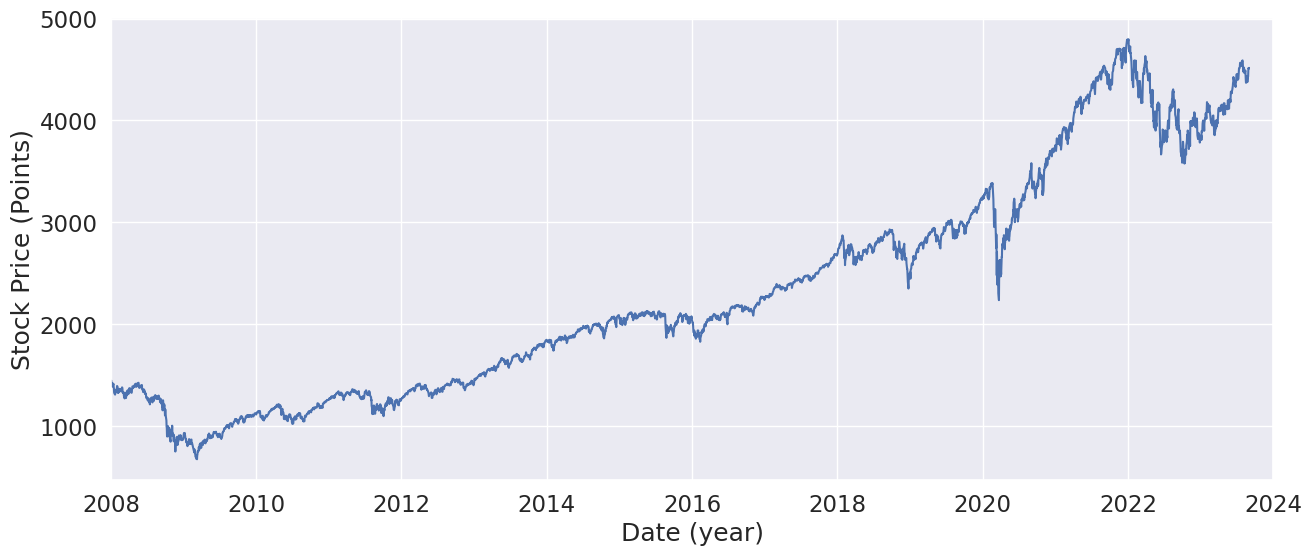

In [ ]:
SP500 = download_stock_price('^GSPC')

#Line plot of SP500
x_date=SP500.index
y=SP500['Close']
plt.plot(x_date,y)
plt.xlabel("Date (year)")
plt.ylabel("Stock Price (Points)")
plt.xlim(pd.to_datetime('2008-01-01'),pd.to_datetime('2024-01-02'))


In [ ]:
#Prediction features
feature_cols = ['Open','High','Low','Volume']
#Feature data
x = SP500[feature_cols]
#Target data
y = SP500['Close']
#Make the training and test data sets
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.25,random_state=0)

In [ ]:
lin_reg = LinearRegression()
#Train the model
lin_reg.fit(x_train,y_train)

LinearRegression()

In [ ]:
#Evaluate model
y_pred = lin_reg.predict(x_test)
y_test = pd.DataFrame(y_test)
y_pred = pd.DataFrame(y_pred)
y_pred = y_pred.set_index(y_test.index)
y_pred = y_pred.sort_index()
y_test = y_test.sort_index()
coeff = lin_reg.coef_
intercept = lin_reg.intercept_
print(coeff,intercept)

[-7.25448773e-01  8.94672076e-01  8.30643688e-01 -1.48055666e-11] 0.6744653259088409


Text(0.5, 1.0, 'Linear-Regression Model of S&P 500\n(2008-Present)')

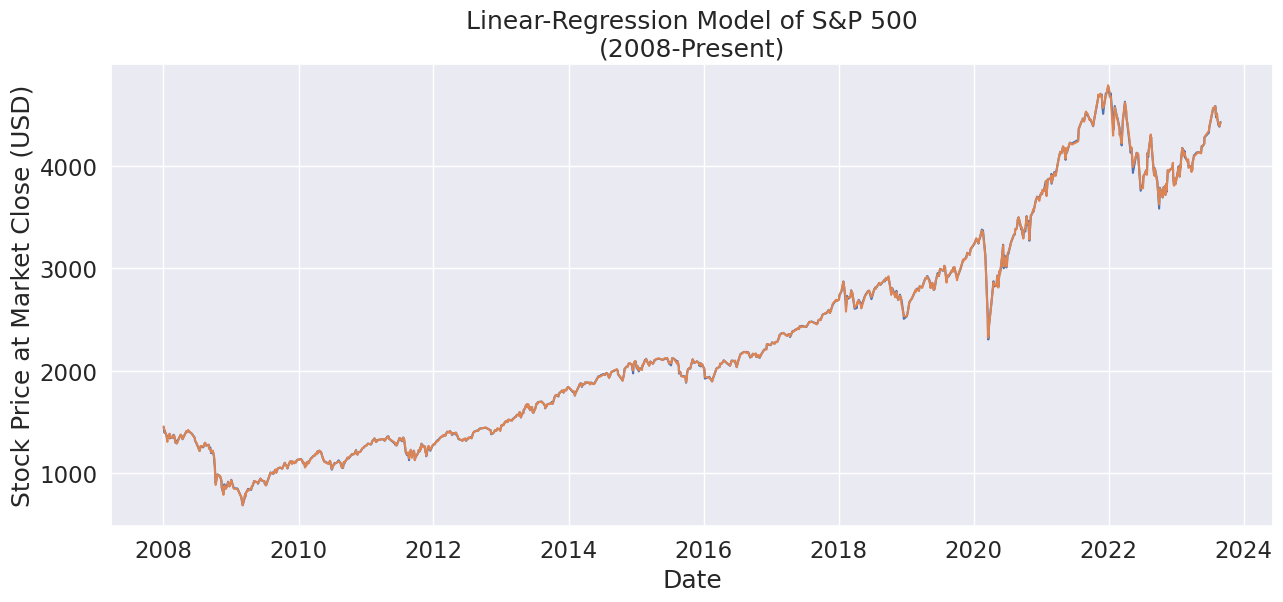

In [ ]:
plt.plot(y_test.index,y_test)
plt.plot(y_pred.index,y_pred[0])
plt.ylabel('Stock Price at Market Close (USD)')
plt.xlabel('Date')
plt.title('Linear-Regression Model of S&P 500\n(2008-Present)')

In [ ]:
#Future features
#Create time lag between future feature values and current values
future_features = SP500[feature_cols].shift(1)[1:]
future_dates = pd.date_range(start=SP500.index[-1],periods=3945,freq='D')[1:]
future_features = future_features.reset_index(drop=True)
future_df = pd.DataFrame(future_features)
future_df.index = future_dates
#Create predicted values
future_pred = lin_reg.predict(future_df)

Text(0.5, 1.0, 'Linear-Regression Model of S&P 500\n(2008-2034})')

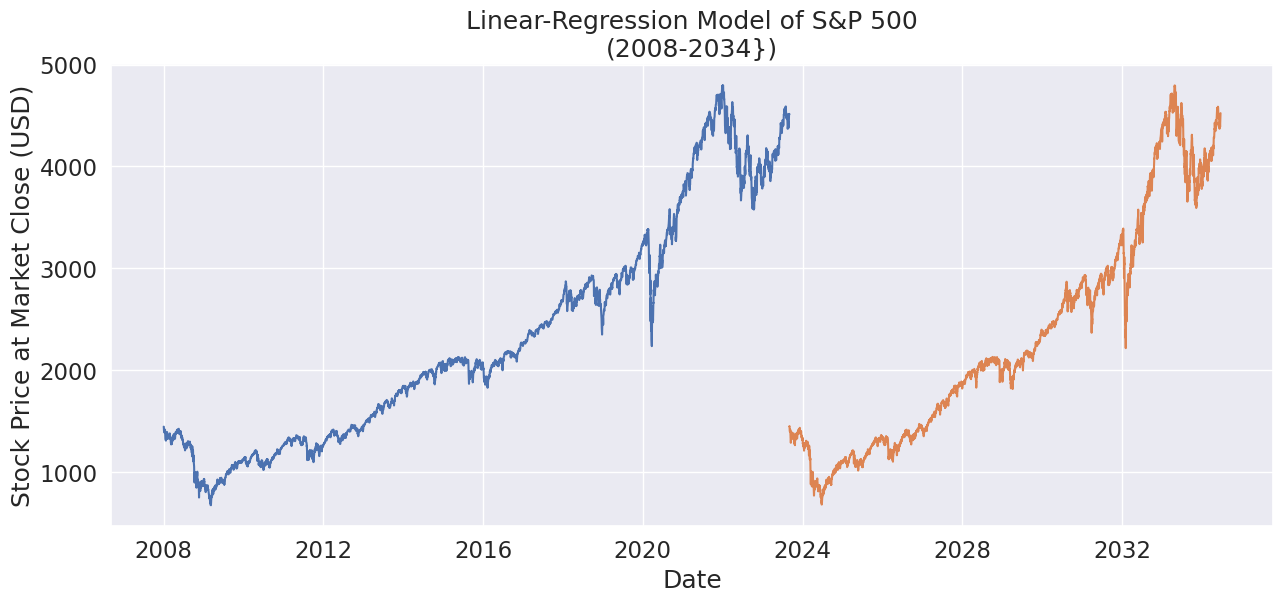

In [ ]:
#Plot predicted values
plt.plot(x.index,y)
plt.plot(future_dates,future_pred)
plt.ylabel('Stock Price at Market Close (USD)')
plt.xlabel('Date')
plt.title('Linear-Regression Model of S&P 500\n(2008-2034})')

## 05.1 Linear-Regression Model Validation

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
#Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test,y_pred)

#Mean Squared Error (MSE)
mse = mean_squared_error(y_test,y_pred)

#Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test, y_pred, squared=False)

#R-squared (R2) Score:
r2 = r2_score(y_test,y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared (R2) Score: {r2}")

Mean Absolute Error: 6.372858234619817
Mean Squared Error: 109.94538504513486
Root Mean Squared Error: 10.485484492627647
R-squared (R2) Score: 0.9999101502527511


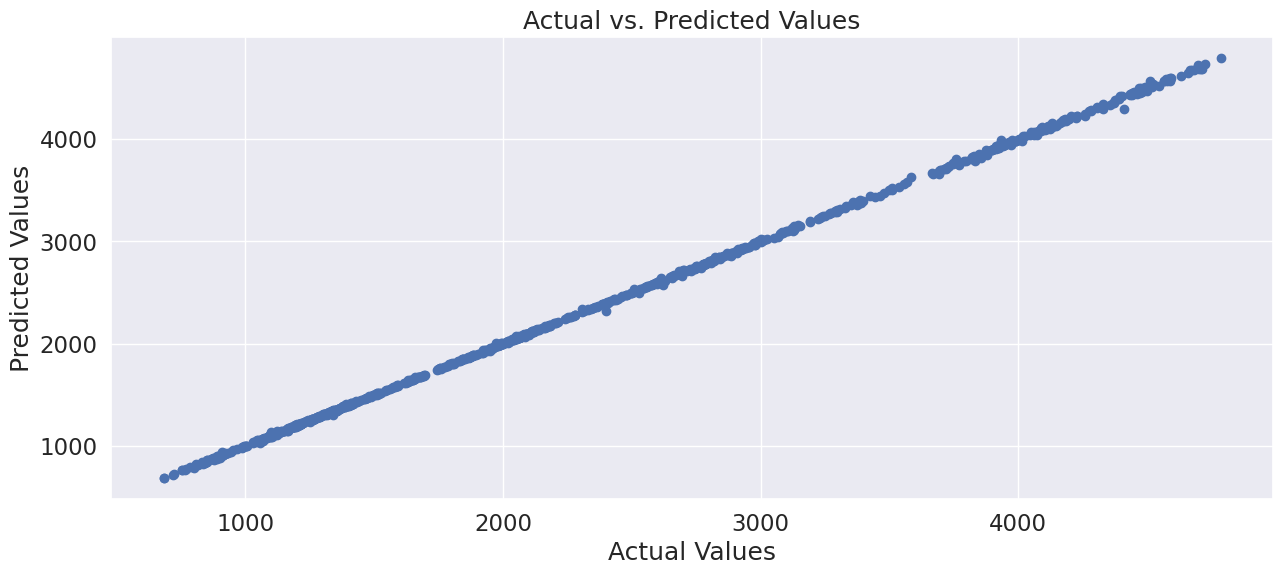

In [ ]:
#Visualization of model validation
plt.scatter(y_test,y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score
cross_scores = cross_val_score(lin_reg,x,y,cv=5)
print(cross_scores)

[0.99846696 0.99941347 0.99788477 0.99745434 0.99812869]
